# STOCK TRADING

Stock trading agent based on Deep Neuro Evolution

* Using state as:
    * Close (detrend)
    * Open (detrend)
    * High (detrend)
    * Low (detrend)
    * CNN Classifier for buy and sell (10 window)
    * RSI n MACD

In [2]:
import os
import sys
import gym
import math
import argparse
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from GA.ga import GeneticNetworks

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from core.technical_analysis import add_technical_indicators_with_intervals

from core.market_env_v1 import MarketEnvironmentV1
from utils.networks import get_session

from cnn_prediction.cnn_data_loader_buy_sell import CNNDataLoaderBuySell
from cnn_prediction.cnn_model import CNNModel

Using TensorFlow backend.


In [3]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
configs = json.load(open('config-EURUSD-30M_v3.0141.json', 'r'))
detrend = configs['agent']['detrend']

## Load data

In [6]:
df_train = pd.read_csv(configs['agent']['data'])
df_test = pd.read_csv(configs['agent']['test_data'])

In [8]:
df_train = add_technical_indicators_with_intervals(
    df_train, 
    indicators=configs['agent']['technical_indicators'], 
    intervals=configs['agent']['intervals']
)
df_test = add_technical_indicators_with_intervals(
    df_test, 
    indicators=configs['agent']['technical_indicators'], 
    intervals=configs['agent']['intervals']
)

In [9]:
cols = []
# Add detrend OHLC
if detrend:
    for col in [a for a in configs['agent']['cols'] if configs['agent']['cols'][a]["detrend"]]:
        cols.append(col + '_detrend')
    for col in [a for a in configs['agent']['cols'] if not configs['agent']['cols'][a]["detrend"]]:
        cols.append(col)
# Add technical indicators
for indicator in configs['agent']['technical_indicators']:
    for interval in configs['agent']['intervals']:
        cols.append(indicator + '_' + str(interval))
cols

['Close_detrend',
 'Open_detrend',
 'High_detrend',
 'Low_detrend',
 'CNNClassifier_hold',
 'CNNClassifier_buy',
 'CNNClassifier_sell',
 'MACDhist_3',
 'MACDhist_5',
 'MACDhist_9',
 'MACDhist_14',
 'RSI_3',
 'RSI_5',
 'RSI_9',
 'RSI_14']

In [10]:
# Add detrended values to df
if detrend:
    for col in [a for a in configs['agent']['cols'] if configs['agent']['cols'][a]["detrend"]]:
        df_train[col + '_detrend'] = df_train.get([col]) - df_train.get([col]).shift()
        df_test[col + '_detrend'] = df_test.get([col]) - df_test.get([col]).shift()
df_train = df_train.dropna()
df_test = df_test.dropna()

### Load CNN Model and include inputs

In [12]:
generative_training = configs['model']['generative_training']
img_size = len(configs['model']['inputs']['technical_indicators'])

# Add LSTM Predictions
model = CNNModel()
model.load_model('saved_models/' + configs['model']['pre_trained_model'])
model.model.load_weights('saved_models/' + configs['model']['pre_trained_weights'])
model.model.summary()

[Model] Loading model from file saved_models/cnn-EURUSD_buy_sell_w10-ep500-2020_06_11.model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
____

In [13]:
cnn_cols = []
for indicator in configs['model']['inputs']['technical_indicators']:
    for interval in configs['model']['inputs']['intervals']:
        cnn_cols.append(indicator + '_' + str(interval))

In [14]:
dataloader = CNNDataLoaderBuySell(
    df_train,
    indicators=configs['model']['inputs']['technical_indicators'],
    intervals=configs['model']['inputs']['intervals'],
    df_test=df_test,
    window_size=10
)

In [15]:
x_train, y_train = dataloader.get_train_data(cnn_cols, window_size=15, class_unbalacing=False)
x_test, y_test  = dataloader.get_test_data(cnn_cols, window_size=15, class_unbalacing=False)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((147281, 15, 15, 3), (147281,), (11577, 15, 15, 3), (11577,))

In [16]:
predictions_train = model.predict(x_train,verbose=True)
predictions_test = model.predict(x_test,verbose=True)

11577/11577 [==============================] - 1s 118us/sample


In [ ]:
df_train["CNNClassifier_hold"] = np.nan
df_train["CNNClassifier_buy"] = np.nan
df_train["CNNClassifier_sell"] = np.nan
df_test["CNNClassifier_hold"] = np.nan
df_test["CNNClassifier_buy"] = np.nan
df_test["CNNClassifier_sell"] = np.nan
index = len(df_test) - len(predictions_test) 

# Train
for i in tqdm(range(len(predictions_train))):
    df_train["CNNClassifier_hold"].iloc[index+i] = predictions_train[i][0]
    df_train["CNNClassifier_buy"].iloc[index+i] = predictions_train[i][1]
    df_train["CNNClassifier_sell"].iloc[index+i] = predictions_train[i][2]

# Test
for i in tqdm(range(len(predictions_test))):
    df_test["CNNClassifier_hold"].iloc[index+i] = predictions_test[i][0]
    df_test["CNNClassifier_buy"].iloc[index+i] = predictions_test[i][1]
    df_test["CNNClassifier_sell"].iloc[index+i] = predictions_test[i][2]

df_train = df_train.dropna()
df_test = df_test.dropna()

 56%|█████▌    | 82133/147281 [00:47<00:28, 2254.07it/s]

In [ ]:
# Force memory deallocation
x_train, y_train, y_train_mov = None, None, None
x_test, y_test, y_test_mov = None, None, None
dataloader, predictions_train, predictions_test = None, None, None

### Data ready

In [ ]:
df_train.head()

In [ ]:
x_train = df_train.get(cols).values
x_test = df_test.get(cols).values
x_train.shape, x_test.shape

In [ ]:
# true values
x_train_undo_detrend = df_train.get(["Close"]).values
x_test_undo_detrend = df_test.get(["Close"]).values

In [ ]:
# Make sure it is right
print(x_train[:8, 0])
print(x_train_undo_detrend[:8, 0])

In [ ]:
print(x_train[0])

In [ ]:
fig = plt.figure(figsize=(18, 5))
# train
fig.add_subplot(1, 2, 1)
plt.axis("off")
plt.title("Train", fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.plot(x_train_undo_detrend[2_200:6_300, 0])
# Test
fig.add_subplot(1, 2, 2)
plt.axis("off")
plt.title("Test", fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.plot(x_test_undo_detrend[:, 0])
plt.show()

## Parameters

In [27]:
### MODEL HYPERPARAMETERS
# Here our possible actions
sit = [1, 0, 0]
buy = [0, 1, 0]
sell = [0, 0, 1]
possible_actions = [sit, buy, sell]

action_size = len(possible_actions)              # 3 possible actions: sit, buy, sell
state_size = x_train.shape[1]

### TRAINING HYPERPARAMETERS
layers = configs['agent']['layers']
population_size = configs['agent']['params']['population_size']
generations = configs['agent']['params']['generations']
episodes = configs['agent']['params']['episodes']
mutation_variance = configs['agent']['params']['mutation_variance']
survival_ratio = configs['agent']['params']['survival_ratio']
max_env_steps = configs['agent']['params']['max_env_steps']
both_parent_percentage = configs['agent']['params']['both_parent_percentage']
one_parent_percentage = configs['agent']['params']['one_parent_percentage']

gpu = True
gather_stats = True
env_name = configs['agent']['params']['env']
type = 'GA'


### Env
initial_cash = configs['agent']['params']['initial_cash']
close_col = configs['agent']['params']['close_col']
profit_window_size = configs['agent']['params']['profit_window_size']
large_holdings_penalty = configs['agent']['params']['large_holdings_penalty']
lost_all_cash_penalty = configs['agent']['params']['lost_all_cash_penalty']
inaction_penalty = configs['agent']['params']['inaction_penalty']
no_trades_penalty = configs['agent']['params']['no_trades_penalty']
reward_function =  configs['agent']['params']['reward_function']
close_padding = configs['agent']['params']['close_padding']

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

In [28]:
tensorboard_logs = type + "/tensorboard_" + env_name + "_v3.0141"
tensorboard_logs

'../../GA/tensorboard_Market_v3.0141'

In [29]:
# Clear any logs from previous runs
import shutil
shutil.rmtree(tensorboard_logs)

In [30]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(tensorboard_logs)

In [31]:
# Environment Initialization
args = {
    'x': x_train, 
    'actions': possible_actions, 
    'state_size': state_size, 
    'start_index': 2_200,
    'end_index': 6_300,
    'initial_cash': initial_cash,
    'close_col': close_col, 
    'undo_detrend': x_train_undo_detrend, 
    'reward_function': reward_function, 
    'profit_window_size': profit_window_size, 
    'inaction_penalty': inaction_penalty,
    'no_trades_penalty': no_trades_penalty,
    'large_holdings_penalty': large_holdings_penalty,
    'close_padding': close_padding
}
test_args = {
    'x': x_test, 
    'actions': possible_actions, 
    'state_size': state_size, 
    'start_index': 0,
    'end_index': 100_000,
    'initial_cash': initial_cash,
    'close_col': close_col, 
    'undo_detrend': x_test_undo_detrend, 
    'reward_function': reward_function, 
    'profit_window_size': profit_window_size, 
    'inaction_penalty': inaction_penalty,
    'no_trades_penalty': no_trades_penalty,
    'large_holdings_penalty': large_holdings_penalty,
    'close_padding': close_padding
}
env = MarketEnvironmentV1(**args)
env.reset()
state_dim = env.get_state_size()
action_dim = env.get_action_size()

SimpleProfit


## Initialize agent

In [32]:
genetic_pop = GeneticNetworks(architecture=(state_dim, ) + tuple(layers) + (action_dim,),
                                population_size=population_size, 
                                generations=generations,
                                episodes=episodes, 
                                mutation_variance=mutation_variance,
                                render_env=False,
                                survival_ratio=survival_ratio,
                                verbose=True,
                                stagnation_end=False,
                                save_path='saved_models/',
                                both_parent_percentage=both_parent_percentage,
                                one_parent_percentage=one_parent_percentage,
                                max_env_steps=max_env_steps)

--------------------------------------------------
Logging params: 
population_size 256
generations 100
mutation_variance 0.005
survival_ratio 0.15
both_parent_percentage 0.8
one_parent_percentage 0.1
episodes 10
max_env_steps 500
--------------------------------------------------


## Train

In [33]:
%%time

genetic_pop.fit(
    env, 
    summary_writer, 
    is_market=True, 
    env_args=args, 
    num_cpus=4, 
    debug=True, 
    test_env_args=test_args
)


Generation:   0%|          | 0/100 [00:00<?, ? gen/s]

SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit
SimpleProfit

Generation:1| Highest Reward:1.4343689798412007| Average Reward:-90.18576897945485| std Reward: 27.372599707715327| Stagnation: 1| Population size: 256:   0%|          | 0/100 [00:51<?, ? gen/s]

Traning Data (best) ->>  {'cash_profit': '0.0', 'cash': '5.0', 'portfolio_value': '0.0', 'net': '5.0', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '0', 'step_value': '4099', 'max_holdings': '0', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '0.0', 'cash': '5.0', 'portfolio_value': '0.0', 'net': '5.0', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '0', 'step_value': '11623', 'max_holdings': '0', 'total_longs': '0', 'total_shorts': '0', 'win_longs': 

Generation:1| Highest Reward:1.4343689798412007| Average Reward:-90.18576897945485| std Reward: 27.372599707715327| Stagnation: 1| Population size: 256:   1%|          | 1/100 [00:55<1:32:18, 55.94s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:2| Highest Reward:1.5080492088381106| Average Reward:-79.23815058169582| std Reward: 38.112452411722956| Stagnation: 1| Population size: 256:   1%|          | 1/100 [01:52<1:32:18, 55.94s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.3916000000000261', 'cash': '9.893699999999999', 'portfolio_value': '-4.96328', 'net': '4.930419999999999', 'total_profit': '-0.050930000000007025', 'win_trades': '473', 'winnning_percent': '0.6945668135095447', 'total_trades': '681', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '347', 'total_shorts': '334', 'win_longs': '0.6772334293948127', 'win_shorts': '0.7125748502994012'}
Traning Data (latest) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '0.3262000000003429', 'cash': '9.603830000000016', 'portfolio_value': '-4.58752', 'net': '5.016310000000017', 'total_profit': '0.023279999

Generation:2| Highest Reward:1.5080492088381106| Average Reward:-79.23815058169582| std Reward: 38.112452411722956| Stagnation: 1| Population size: 256:   2%|▏         | 2/100 [01:56<1:33:50, 57.45s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:3| Highest Reward:1.0524680459407676| Average Reward:-78.48244320699574| std Reward: 39.90443979433635| Stagnation: 2| Population size: 256:   2%|▏         | 2/100 [02:54<1:33:50, 57.45s/ gen] 

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.9821999999997342', 'cash': '10.062389999999986', 'portfolio_value': '-4.96328', 'net': '5.099109999999986', 'total_profit': '0.13722000000000034', 'win_trades': '224', 'winnning_percent': '0.7804878048780488', 'total_trades': '287', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '146', 'total_shorts': '141', 'win_longs': '0.8013698630136986', 'win_shorts': '0.7588652482269503'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0

Generation:3| Highest Reward:1.0524680459407676| Average Reward:-78.48244320699574| std Reward: 39.90443979433635| Stagnation: 2| Population size: 256:   3%|▎         | 3/100 [02:58<1:35:04, 58.81s/ gen]

Test Data (latest)->>  {'cash_profit': '7.473999999999914', 'cash': '9.961219999999996', 'portfolio_value': '-4.58752', 'net': '5.373699999999996', 'total_profit': '0.41867999999999195', 'win_trades': '867', 'winnning_percent': '0.7867513611615246', 'total_trades': '1102', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '558', 'total_shorts': '544', 'win_longs': '0.7777777777777778', 'win_shorts': '0.7959558823529411'}


Generation:4| Highest Reward:0.9616786237434043| Average Reward:-69.34271913944133| std Reward: 44.784970771735466| Stagnation: 3| Population size: 256:   3%|▎         | 3/100 [03:52<1:35:04, 58.81s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '0.21519999999974893', 'cash': '0.04747999999998753', 'portfolio_value': '4.96328', 'net': '5.010759999999988', 'total_profit': '-0.02735000000000687', 'win_trades': '82', 'winnning_percent': '0.20297029702970298', 'total_trades': '404', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '231', 'total_shorts': '173', 'win_longs': '0.22077922077922077', 'win_shorts': '0.1791907514450867'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': 

Generation:4| Highest Reward:0.9616786237434043| Average Reward:-69.34271913944133| std Reward: 44.784970771735466| Stagnation: 3| Population size: 256:   4%|▍         | 4/100 [03:57<1:33:48, 58.64s/ gen]

Test Data (latest)->>  {'cash_profit': '-3.0997999999999415', 'cash': '0.25749000000000355', 'portfolio_value': '4.58752', 'net': '4.845010000000003', 'total_profit': '-0.182500000000007', 'win_trades': '230', 'winnning_percent': '0.24236037934668073', 'total_trades': '949', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '565', 'total_shorts': '384', 'win_longs': '0.25486725663716814', 'win_shorts': '0.22395833333333334'}


Generation:5| Highest Reward:1.110242769762553| Average Reward:-69.27143658749851| std Reward: 45.12448911656495| Stagnation: 4| Population size: 256:   4%|▍         | 4/100 [04:52<1:33:48, 58.64s/ gen]  

Traning Data (best) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '4.689399999999955', 'cash': '9.821989999999998', 'portfolio_value': '-4.58752', 'net': '5.234469999999998', 'total_profit': '0.25799999999999956', 'win_trades': '2', 'winnning_percent': '1.0', 'total_trades': '2', 'holdings':

Generation:5| Highest Reward:1.110242769762553| Average Reward:-69.27143658749851| std Reward: 45.12448911656495| Stagnation: 4| Population size: 256:   5%|▌         | 5/100 [04:56<1:33:21, 58.97s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:6| Highest Reward:1.5589786279658056| Average Reward:-78.84381490257138| std Reward: 39.398756537327635| Stagnation: 1| Population size: 256:   5%|▌         | 5/100 [05:52<1:33:21, 58.97s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.1617999999999906', 'cash': '0.09481000000000006', 'portfolio_value': '4.96328', 'net': '5.05809', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '-3.102200000000488', 'cash': '9.808169999999976', 'portfolio_value': '-4.96328', 'net': '4.8448899999999755', 'total_profit': '-0.11700000000000865', 'win_trades': '475', 'winnning_percent': '0.8246527777777778', 'total_trades': '576', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '293', 'total_shorts': '283', 'win_longs': '0.8122866894197952', 'win_shorts': '0.8374558303886925'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': 

Generation:6| Highest Reward:1.5589786279658056| Average Reward:-78.84381490257138| std Reward: 39.398756537327635| Stagnation: 1| Population size: 256:   6%|▌         | 6/100 [05:57<1:33:05, 59.42s/ gen]

Test Data (latest)->>  {'cash_profit': '-0.09640000000011861', 'cash': '9.582699999999994', 'portfolio_value': '-4.58752', 'net': '4.995179999999994', 'total_profit': '0.0025499999999969436', 'win_trades': '1340', 'winnning_percent': '0.7957244655581948', 'total_trades': '1684', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '870', 'total_shorts': '814', 'win_longs': '0.8045977011494253', 'win_shorts': '0.7862407862407862'}


Generation:7| Highest Reward:1.1479811729514093| Average Reward:-58.42920465356537| std Reward: 47.37802596076296| Stagnation: 2| Population size: 256:   6%|▌         | 6/100 [06:53<1:33:05, 59.42s/ gen] 

Traning Data (best) ->>  {'cash_profit': '-1.656600000000008', 'cash': '9.88045', 'portfolio_value': '-4.96328', 'net': '4.91717', 'total_profit': '0.024849999999999595', 'win_trades': '1', 'winnning_percent': '0.5', 'total_trades': '2', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '1', 'total_shorts': '1', 'win_longs': '0.0', 'win_shorts': '1.0'}
Traning Data (latest) ->>  {'cash_profit': '-1.5346000000000082', 'cash': '9.88655', 'portfolio_value': '-4.96328', 'net': '4.92327', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'ma

Generation:7| Highest Reward:1.1479811729514093| Average Reward:-58.42920465356537| std Reward: 47.37802596076296| Stagnation: 2| Population size: 256:   7%|▋         | 7/100 [06:58<1:33:00, 60.01s/ gen]

Test Data (latest)->>  {'cash_profit': '6.345399999999968', 'cash': '9.904789999999998', 'portfolio_value': '-4.58752', 'net': '5.317269999999999', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:8| Highest Reward:2.1215105971794084| Average Reward:-71.71570013779149| std Reward: 43.993990587232986| Stagnation: 1| Population size: 256:   7%|▋         | 7/100 [07:54<1:33:00, 60.01s/ gen]

Traning Data (best) ->>  {'cash_profit': '7.319200000000259', 'cash': '0.4026800000000128', 'portfolio_value': '4.96328', 'net': '5.365960000000013', 'total_profit': '0.32769000000000625', 'win_trades': '111', 'winnning_percent': '0.42366412213740456', 'total_trades': '262', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '166', 'total_shorts': '96', 'win_longs': '0.37349397590361444', 'win_shorts': '0.5104166666666666'}
Traning Data (latest) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '-3.0469999999988895', 'cash': '0.26013000000005615', 'portfolio_value': '4.58752', 'net': '4.847650000000056', 'total_profit': '-0.161139999

Generation:8| Highest Reward:2.1215105971794084| Average Reward:-71.71570013779149| std Reward: 43.993990587232986| Stagnation: 1| Population size: 256:   8%|▊         | 8/100 [07:59<1:32:14, 60.16s/ gen]

Test Data (latest)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:9| Highest Reward:1.3947675819595853| Average Reward:-63.58692149694461| std Reward: 46.151079533573586| Stagnation: 2| Population size: 256:   8%|▊         | 8/100 [08:56<1:32:14, 60.16s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.1617999999999906', 'cash': '0.09481000000000006', 'portfolio_value': '4.96328', 'net': '5.05809', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '-5.245000000000388', 'cash': '1.0152899999999807', 'portfolio_value': '3.72246', 'net': '4.737749999999981', 'total_profit': '-0.28408000000000255', 'win_trades': '99', 'winnning_percent': '0.20711297071129708', 'total_trades': '478', 'holdings': '3', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '256', 'total_shorts': '222', 'win_longs': '0.2421875', 'win_shorts': '0.16666666666666666'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winn

Generation:9| Highest Reward:1.3947675819595853| Average Reward:-63.58692149694461| std Reward: 46.151079533573586| Stagnation: 2| Population size: 256:   9%|▉         | 9/100 [09:00<1:31:47, 60.53s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.953399999999619', 'cash': '0.16481000000001944', 'portfolio_value': '4.58752', 'net': '4.752330000000019', 'total_profit': '-0.25464000000000087', 'win_trades': '341', 'winnning_percent': '0.2152777777777778', 'total_trades': '1584', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '941', 'total_shorts': '643', 'win_longs': '0.22422954303931988', 'win_shorts': '0.20217729393468117'}


Generation:10| Highest Reward:1.4031699081446367| Average Reward:-52.966825150685075| std Reward: 48.151691447237184| Stagnation: 3| Population size: 256:   9%|▉         | 9/100 [09:57<1:31:47, 60.53s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.2116000000000127', 'cash': '9.9027', 'portfolio_value': '-4.96328', 'net': '4.939419999999999', 'total_profit': '-0.04113000000000655', 'win_trades': '38', 'winnning_percent': '0.5428571428571428', 'total_trades': '70', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '35', 'total_shorts': '35', 'win_longs': '0.6571428571428571', 'win_shorts': '0.42857142857142855'}
Traning Data (latest) ->>  {'cash_profit': '3.1724000000000085', 'cash': '0.19534000000000074', 'portfolio_value': '4.96328', 'net': '5.158620000000001', 'total_profit': '0.14416999999999658', 'win_trades': '26', 'winnning_percent': '0.33766233766233766', 'total_trades': '77', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '56', 'total_shorts': '21', 'win_longs': '0.32142857142857145', 'win_shorts': '0.38095238095238093'}
Test Data (best)->>  {'cash_profit': '5.089999999999728', 'cash': '9.842019999999986', 'portfolio_value':

Generation:10| Highest Reward:1.4031699081446367| Average Reward:-52.966825150685075| std Reward: 48.151691447237184| Stagnation: 3| Population size: 256:  10%|█         | 10/100 [10:02<1:31:21, 60.90s/ gen]

Test Data (latest)->>  {'cash_profit': '-2.01559999999974', 'cash': '0.31170000000001363', 'portfolio_value': '4.58752', 'net': '4.899220000000013', 'total_profit': '-0.14735999999999794', 'win_trades': '116', 'winnning_percent': '0.31351351351351353', 'total_trades': '370', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '242', 'total_shorts': '128', 'win_longs': '0.2768595041322314', 'win_shorts': '0.3828125'}


Generation:11| Highest Reward:1.2272702542522662| Average Reward:-42.934749456090415| std Reward: 47.82681996467941| Stagnation: 4| Population size: 256:  10%|█         | 10/100 [10:58<1:31:21, 60.90s/ gen] 

Traning Data (best) ->>  {'cash_profit': '5.4070000000001395', 'cash': '0.3070700000000064', 'portfolio_value': '4.96328', 'net': '5.270350000000007', 'total_profit': '0.2630000000000081', 'win_trades': '147', 'winnning_percent': '0.8121546961325967', 'total_trades': '181', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '101', 'total_shorts': '80', 'win_longs': '0.801980198019802', 'win_shorts': '0.825'}
Traning Data (latest) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '-1.6559999999999464', 'cash': '2.623440000000003', 'portfolio_value': '2.29376', 'net': '4.917200000000003', 'total_profit': '-0.08909000000000322', 'win_tr

Generation:11| Highest Reward:1.2272702542522662| Average Reward:-42.934749456090415| std Reward: 47.82681996467941| Stagnation: 4| Population size: 256:  11%|█         | 11/100 [11:03<1:30:16, 60.85s/ gen]

Test Data (latest)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:12| Highest Reward:1.4803817358929765| Average Reward:-64.21745986166069| std Reward: 45.8563605181046| Stagnation: 5| Population size: 256:  11%|█         | 11/100 [12:00<1:30:16, 60.85s/ gen]  

Traning Data (best) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '2.5981999999999283', 'cash': '10.093189999999996', 'portfolio_value': '-4.96328', 'net': '5.129909999999996', 'total_profit': '0.14855999999998293', 'win_trades': '789', 'winnning_percent': '0.8150826446280992', 'total_trades': '968', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '506', 'total_shorts': '462', 'win_longs': '0.8241106719367589', 'win_shorts': '0.8051948051948052'}
Test Data (best)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnnin

Generation:12| Highest Reward:1.4803817358929765| Average Reward:-64.21745986166069| std Reward: 45.8563605181046| Stagnation: 5| Population size: 256:  12%|█▏        | 12/100 [12:05<1:29:54, 61.30s/ gen]

Test Data (latest)->>  {'cash_profit': '8.278800000000386', 'cash': '10.00146000000002', 'portfolio_value': '-4.58752', 'net': '5.41394000000002', 'total_profit': '0.4200799999999949', 'win_trades': '2229', 'winnning_percent': '0.7843068261787474', 'total_trades': '2842', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1482', 'total_shorts': '1360', 'win_longs': '0.7975708502024291', 'win_shorts': '0.7698529411764706'}


Generation:13| Highest Reward:1.2783498737649848| Average Reward:-47.87011637635468| std Reward: 48.32639723546877| Stagnation: 6| Population size: 256:  12%|█▏        | 12/100 [13:02<1:29:54, 61.30s/ gen]

Traning Data (best) ->>  {'cash_profit': '5.962999999999652', 'cash': '10.261429999999983', 'portfolio_value': '-4.96328', 'net': '5.298149999999983', 'total_profit': '0.3004099999999905', 'win_trades': '553', 'winnning_percent': '0.45179738562091504', 'total_trades': '1224', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '652', 'total_shorts': '572', 'win_longs': '0.450920245398773', 'win_shorts': '0.4527972027972028'}
Traning Data (latest) ->>  {'cash_profit': '3.8738000000000827', 'cash': '10.156970000000005', 'portfolio_value': '-4.96328', 'net': '5.193690000000005', 'total_profit': '0.21234000000000264', 'win_trades': '929', 'winnning_percent': '0.8369369369369369', 'total_trades': '1110', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '578', 'total_shorts': '532', 'win_longs': '0.8494809688581315', 'win_shorts': '0.8233082706766918'}
Test Data (best)->>  {'cash_profit': '1.1300000000003196', 'cash': '10.051940000000016', '

Generation:13| Highest Reward:1.2783498737649848| Average Reward:-47.87011637635468| std Reward: 48.32639723546877| Stagnation: 6| Population size: 256:  13%|█▎        | 13/100 [13:05<1:28:16, 60.88s/ gen]

Test Data (latest)->>  {'cash_profit': '4.57880000000106', 'cash': '9.816460000000053', 'portfolio_value': '-4.58752', 'net': '5.228940000000053', 'total_profit': '0.2339799999999772', 'win_trades': '2433', 'winnning_percent': '0.8128967591045774', 'total_trades': '2993', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1575', 'total_shorts': '1418', 'win_longs': '0.826031746031746', 'win_shorts': '0.7983074753173484'}


Generation:14| Highest Reward:1.6383780555656025| Average Reward:-46.40976752938808| std Reward: 48.09198734503938| Stagnation: 7| Population size: 256:  13%|█▎        | 13/100 [14:03<1:28:16, 60.88s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.614600000000066', 'cash': '10.044010000000004', 'portfolio_value': '-4.96328', 'net': '5.0807300000000035', 'total_profit': '0.10137000000000507', 'win_trades': '154', 'winnning_percent': '0.7264150943396226', 'total_trades': '212', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '107', 'total_shorts': '105', 'win_longs': '0.8037383177570093', 'win_shorts': '0.6476190476190476'}
Test Data (best)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnnin

Generation:14| Highest Reward:1.6383780555656025| Average Reward:-46.40976752938808| std Reward: 48.09198734503938| Stagnation: 7| Population size: 256:  14%|█▍        | 14/100 [14:08<1:28:08, 61.49s/ gen]

Test Data (latest)->>  {'cash_profit': '5.122399999999949', 'cash': '9.843639999999997', 'portfolio_value': '-4.58752', 'net': '5.2561199999999975', 'total_profit': '0.26928999999999337', 'win_trades': '264', 'winnning_percent': '0.6786632390745502', 'total_trades': '389', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '195', 'total_shorts': '194', 'win_longs': '0.7230769230769231', 'win_shorts': '0.634020618556701'}


Generation:15| Highest Reward:1.4495697076317613| Average Reward:-50.82878844078106| std Reward: 48.53665181822634| Stagnation: 8| Population size: 256:  14%|█▍        | 14/100 [15:05<1:28:08, 61.49s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '2.8739999999998656', 'cash': '8.866159999999994', 'portfolio_value': '-3.72246', 'net': '5.143699999999994', 'total_profit': '0.1439199999999934', 'win_trades': '183', 'winnning_percent': '0.6421052631578947', 'total_trades': '285', 'holdings': '-3', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '174', 'total_shorts': '111', 'win_longs': '0.6494252873563219', 'win_shorts': '0.6306306306306306'}
Test Data (best)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_

Generation:15| Highest Reward:1.4495697076317613| Average Reward:-50.82878844078106| std Reward: 48.53665181822634| Stagnation: 8| Population size: 256:  15%|█▌        | 15/100 [15:09<1:27:12, 61.56s/ gen]

Test Data (latest)->>  {'cash_profit': '4.796400000000167', 'cash': '5.239820000000009', 'portfolio_value': '0.0', 'net': '5.239820000000009', 'total_profit': '0.2398200000000148', 'win_trades': '412', 'winnning_percent': '0.7266313932980599', 'total_trades': '567', 'holdings': '0', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '351', 'total_shorts': '216', 'win_longs': '0.7122507122507122', 'win_shorts': '0.75'}


Generation:16| Highest Reward:1.8365864788038624| Average Reward:-47.79969360596188| std Reward: 48.14309250297379| Stagnation: 9| Population size: 256:  15%|█▌        | 15/100 [16:09<1:27:12, 61.56s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'max_ho

Generation:16| Highest Reward:1.8365864788038624| Average Reward:-47.79969360596188| std Reward: 48.14309250297379| Stagnation: 9| Population size: 256:  16%|█▌        | 16/100 [16:14<1:27:13, 62.30s/ gen]

Test Data (latest)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:17| Highest Reward:1.560279538222677| Average Reward:-65.98337270275152| std Reward: 45.799033242909644| Stagnation: 10| Population size: 256:  16%|█▌        | 16/100 [17:11<1:27:13, 62.30s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.7709999999999892', 'cash': '0.12527', 'portfolio_value': '4.96328', 'net': '5.08855', 'total_profit': '-0.04105999999999832', 'win_trades': '11', 'winnning_percent': '0.34375', 'total_trades': '32', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '21', 'total_shorts': '11', 'win_longs': '0.38095238095238093', 'win_shorts': '0.2727272727272727'}
Traning Data (latest) ->>  {'cash_profit': '-0.6597999999999771', 'cash': '0.0037300000000006772', 'portfolio_value': '4.96328', 'net': '4.967010000000001', 'total_profit': '-0.047190000000000065', 'win_trades': '28', 'winnning_percent': '0.3010752688172043', 'total_trades': '93', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '58', 'total_shorts': '35', 'win_longs': '0.41379310344827586', 'win_shorts': '0.11428571428571428'}
Test Data (best)->>  {'cash_profit': '-4.164399999999835', 'cash': '0.204260000000009', 'portfolio_value': '4.58752', 'net':

Generation:17| Highest Reward:1.560279538222677| Average Reward:-65.98337270275152| std Reward: 45.799033242909644| Stagnation: 10| Population size: 256:  17%|█▋        | 17/100 [17:16<1:26:08, 62.27s/ gen]

Test Data (latest)->>  {'cash_profit': '-3.7248000000001946', 'cash': '0.22623999999999067', 'portfolio_value': '4.58752', 'net': '4.8137599999999905', 'total_profit': '-0.2321600000000119', 'win_trades': '118', 'winnning_percent': '0.3033419023136247', 'total_trades': '389', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '256', 'total_shorts': '133', 'win_longs': '0.3359375', 'win_shorts': '0.24060150375939848'}


Generation:18| Highest Reward:1.6748986192773145| Average Reward:-52.10071430258487| std Reward: 48.15619951642541| Stagnation: 11| Population size: 256:  17%|█▋        | 17/100 [18:13<1:26:08, 62.27s/ gen]

Traning Data (best) ->>  {'cash_profit': '-0.6114000000002839', 'cash': '9.932709999999986', 'portfolio_value': '-4.96328', 'net': '4.969429999999986', 'total_profit': '-0.0009700000000061326', 'win_trades': '467', 'winnning_percent': '0.8093587521663779', 'total_trades': '577', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '295', 'total_shorts': '282', 'win_longs': '0.8169491525423729', 'win_shorts': '0.8014184397163121'}
Traning Data (latest) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '2.388799999999547', 'cash': '9.706959999999977', 'portfolio_value': '-4.58752', 'net': '5.119439999999978', 'total_profit': '0.135619999

Generation:18| Highest Reward:1.6748986192773145| Average Reward:-52.10071430258487| std Reward: 48.15619951642541| Stagnation: 11| Population size: 256:  18%|█▊        | 18/100 [18:18<1:25:01, 62.22s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:19| Highest Reward:1.5304148600726677| Average Reward:-58.79139136512302| std Reward: 47.71919456481063| Stagnation: 12| Population size: 256:  18%|█▊        | 18/100 [19:13<1:25:01, 62.22s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.38879999999999', 'cash': '9.89384', 'portfolio_value': '-4.96328', 'net': '4.930560000000001', 'total_profit': '0.03396000000000021', 'win_trades': '2', 'winnning_percent': '1.0', 'total_trades': '2', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '1', 'total_shorts': '1', 'win_longs': '1.0', 'win_shorts': '1.0'}
Traning Data (latest) ->>  {'cash_profit': '1.3295999999999975', 'cash': '3.825659999999999', 'portfolio_value': '1.24082', 'net': '5.066479999999999', 'total_profit': '0.06647999999999987', 'win_trades': '929', 'winnning_percent': '0.7602291325695582', 'total_trades': '1222', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '637', 'total_shorts': '585', 'win_longs': '0.7770800627943485', 'win_shorts': '0.7418803418803419'}
Test Data (best)->>  {'cash_profit': '3.670399999999985', 'cash': '9.77104', 'portfolio_value': '-4.58752', 'net': '5.18352', 'total_profit': '0.112519999999

Generation:19| Highest Reward:1.5304148600726677| Average Reward:-58.79139136512302| std Reward: 47.71919456481063| Stagnation: 12| Population size: 256:  19%|█▉        | 19/100 [19:18<1:23:11, 61.62s/ gen]

Test Data (latest)->>  {'cash_profit': '7.636000000000642', 'cash': '9.969320000000032', 'portfolio_value': '-4.58752', 'net': '5.381800000000032', 'total_profit': '0.3868400000000243', 'win_trades': '2518', 'winnning_percent': '0.7658150851581509', 'total_trades': '3288', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1704', 'total_shorts': '1584', 'win_longs': '0.778755868544601', 'win_shorts': '0.7518939393939394'}


Generation:20| Highest Reward:1.857929458504477| Average Reward:-51.77248490097131| std Reward: 48.12192103204465| Stagnation: 13| Population size: 256:  19%|█▉        | 19/100 [20:14<1:23:11, 61.62s/ gen] 

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.6647999999999996', 'cash': '0.11995999999999984', 'portfolio_value': '4.96328', 'net': '5.08324', 'total_profit': '0.04436000000000129', 'win_trades': '16', 'winnning_percent': '0.4444444444444444', 'total_trades': '36', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '32', 'total_shorts': '4', 'win_longs': '0.46875', 'win_shorts': '0.25'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades

Generation:20| Highest Reward:1.857929458504477| Average Reward:-51.77248490097131| std Reward: 48.12192103204465| Stagnation: 13| Population size: 256:  20%|██        | 20/100 [20:18<1:21:37, 61.21s/ gen]

Test Data (latest)->>  {'cash_profit': '-3.705000000000158', 'cash': '0.22722999999999227', 'portfolio_value': '4.58752', 'net': '4.814749999999992', 'total_profit': '-0.23023000000000216', 'win_trades': '74', 'winnning_percent': '0.3333333333333333', 'total_trades': '222', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '163', 'total_shorts': '59', 'win_longs': '0.3374233128834356', 'win_shorts': '0.3220338983050847'}


Generation:21| Highest Reward:1.900068774805628| Average Reward:-49.622272061929195| std Reward: 48.36463393006672| Stagnation: 14| Population size: 256:  20%|██        | 20/100 [21:14<1:21:37, 61.21s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623'

Generation:21| Highest Reward:1.900068774805628| Average Reward:-49.622272061929195| std Reward: 48.36463393006672| Stagnation: 14| Population size: 256:  21%|██        | 21/100 [21:18<1:20:11, 60.90s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:22| Highest Reward:1.7112227745186754| Average Reward:-66.90045092979551| std Reward: 45.1029838593256| Stagnation: 15| Population size: 256:  21%|██        | 21/100 [22:13<1:20:11, 60.90s/ gen] 

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '-1.0115999999999459', 'cash': '9.912700000000003', 'portfolio_value': '-4.96328', 'net': '4.949420000000003', 'total_profit': '0.09305000000000052', 'win_trades': '3', 'winnning_percent': '0.75', 'total_trades': '4', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '2', 'total_shorts': '2', 'win_longs': '0.5', 'win_shorts': '1.0'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'ho

Generation:22| Highest Reward:1.7112227745186754| Average Reward:-66.90045092979551| std Reward: 45.1029838593256| Stagnation: 15| Population size: 256:  22%|██▏       | 22/100 [22:18<1:18:33, 60.43s/ gen]

Test Data (latest)->>  {'cash_profit': '4.633200000000026', 'cash': '9.819180000000001', 'portfolio_value': '-4.58752', 'net': '5.2316600000000015', 'total_profit': '0.18970999999999938', 'win_trades': '2', 'winnning_percent': '1.0', 'total_trades': '2', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1', 'total_shorts': '1', 'win_longs': '1.0', 'win_shorts': '1.0'}


Generation:23| Highest Reward:1.3927370688148206| Average Reward:-55.96590709047803| std Reward: 46.899925513389185| Stagnation: 16| Population size: 256:  22%|██▏       | 22/100 [23:14<1:18:33, 60.43s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.270799999999972', 'cash': '9.899740000000001', 'portfolio_value': '-4.96328', 'net': '4.936460000000001', 'total_profit': '0.10084000000000093', 'win_trades': '2', 'winnning_percent': '1.0', 'total_trades': '2', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '1', 'total_shorts': '1', 'win_longs': '1.0', 'win_shorts': '1.0'}
Traning Data (latest) ->>  {'cash_profit': '-0.3649999999995268', 'cash': '0.018470000000023523', 'portfolio_value': '4.96328', 'net': '4.981750000000024', 'total_profit': '-0.036899999999992605', 'win_trades': '159', 'winnning_percent': '0.18772136953955135', 'total_trades': '847', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '451', 'total_shorts': '396', 'win_longs': '0.17960088691796008', 'win_shorts': '0.19696969696969696'}


Generation:23| Highest Reward:1.3927370688148206| Average Reward:-55.96590709047803| std Reward: 46.899925513389185| Stagnation: 16| Population size: 256:  23%|██▎       | 23/100 [23:17<1:17:05, 60.07s/ gen]

Test Data (best)->>  {'cash_profit': '4.691600000000018', 'cash': '9.8221', 'portfolio_value': '-4.58752', 'net': '5.234580000000001', 'total_profit': '0.30369999999999986', 'win_trades': '4', 'winnning_percent': '0.6666666666666666', 'total_trades': '6', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '3', 'total_shorts': '3', 'win_longs': '0.6666666666666666', 'win_shorts': '0.6666666666666666'}
Test Data (latest)->>  {'cash_profit': '-0.624600000000064', 'cash': '9.963009999999997', 'portfolio_value': '-4.9942400000000005', 'net': '4.968769999999997', 'total_profit': '-0.045360000000007616', 'win_trades': '51', 'winnning_percent': '0.20481927710843373', 'total_trades': '249', 'holdings': '-4', 'step_value': '1216', 'max_holdings': '4', 'total_longs': '131', 'total_shorts': '118', 'win_longs': '0.24427480916030533', 'win_shorts': '0.16101694915254236'}


Generation:24| Highest Reward:1.030451841494571| Average Reward:-57.99099228965149| std Reward: 46.65491474490582| Stagnation: 17| Population size: 256:  23%|██▎       | 23/100 [24:13<1:17:05, 60.07s/ gen]  

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '3.8811999999999625', 'cash': '3.9532399999999983', 'portfolio_value': '1.24082', 'net': '5.194059999999999', 'total_profit': '0.19406000000000656', 'win_trades': '171', 'winnning_percent': '0.76', 'total_trades': '225', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '156', 'total_shorts': '69', 'win_longs': '0.7243589743589743', 'win_shorts': '0.8405797101449275'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_perc

Generation:24| Highest Reward:1.030451841494571| Average Reward:-57.99099228965149| std Reward: 46.65491474490582| Stagnation: 17| Population size: 256:  24%|██▍       | 24/100 [24:17<1:16:11, 60.15s/ gen]

Test Data (latest)->>  {'cash_profit': '1.5093999999996166', 'cash': '5.075469999999981', 'portfolio_value': '0.0', 'net': '5.075469999999981', 'total_profit': '0.07546999999999926', 'win_trades': '597', 'winnning_percent': '0.7271619975639464', 'total_trades': '821', 'holdings': '0', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '536', 'total_shorts': '285', 'win_longs': '0.6809701492537313', 'win_shorts': '0.8140350877192982'}


Generation:25| Highest Reward:1.5477797806908962| Average Reward:-45.88863291082659| std Reward: 48.0658677998196| Stagnation: 18| Population size: 256:  24%|██▍       | 24/100 [25:12<1:16:11, 60.15s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623'

Generation:25| Highest Reward:1.5477797806908962| Average Reward:-45.88863291082659| std Reward: 48.0658677998196| Stagnation: 18| Population size: 256:  25%|██▌       | 25/100 [25:16<1:14:40, 59.74s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:26| Highest Reward:1.4453837661550804| Average Reward:-67.45169309006549| std Reward: 44.305231689562596| Stagnation: 19| Population size: 256:  25%|██▌       | 25/100 [26:11<1:14:40, 59.74s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.08239999999978', 'cash': '10.36739999999999', 'portfolio_value': '-4.96328', 'net': '5.404119999999989', 'total_profit': '0.4127600000000067', 'win_trades': '553', 'winnning_percent': '0.6536643026004728', 'total_trades': '846', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '432', 'total_shorts': '414', 'win_longs': '0.6620370370370371', 'win_shorts': '0.644927536231884'}
Traning Data (latest) ->>  {'cash_profit': '-0.2742000000005129', 'cash': '9.949569999999975', 'portfolio_value': '-4.96328', 'net': '4.986289999999975', 'total_profit': '0.0021599999999923902', 'win_trades': '666', 'winnning_percent': '0.8222222222222222', 'total_trades': '810', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '443', 'total_shorts': '367', 'win_longs': '0.835214446952596', 'win_shorts': '0.8065395095367848'}
Test Data (best)->>  {'cash_profit': '13.860000000000493', 'cash': '10.280520000000024', 'port

Generation:26| Highest Reward:1.4453837661550804| Average Reward:-67.45169309006549| std Reward: 44.305231689562596| Stagnation: 19| Population size: 256:  26%|██▌       | 26/100 [26:15<1:13:30, 59.60s/ gen]

Test Data (latest)->>  {'cash_profit': '6.041399999999619', 'cash': '9.88958999999998', 'portfolio_value': '-4.58752', 'net': '5.302069999999981', 'total_profit': '0.30710999999997624', 'win_trades': '1798', 'winnning_percent': '0.8217550274223034', 'total_trades': '2188', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1206', 'total_shorts': '982', 'win_longs': '0.8291873963515755', 'win_shorts': '0.8126272912423625'}


Generation:27| Highest Reward:1.3008438278614025| Average Reward:-45.24285820588504| std Reward: 47.75915897869899| Stagnation: 20| Population size: 256:  26%|██▌       | 26/100 [27:12<1:13:30, 59.60s/ gen] 

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '0.0', 'cash': '5.0', 'portfolio_value': '0.0', 'net': '5.0', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '0', 'step_value': '4099', 'max_holdings': '0', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': 

Generation:27| Highest Reward:1.3008438278614025| Average Reward:-45.24285820588504| std Reward: 47.75915897869899| Stagnation: 20| Population size: 256:  27%|██▋       | 27/100 [27:16<1:12:53, 59.91s/ gen]

Test Data (latest)->>  {'cash_profit': '-0.5921999999999983', 'cash': '3.8235099999999997', 'portfolio_value': '1.14688', 'net': '4.97039', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '1', 'step_value': '11623', 'max_holdings': '1', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:28| Highest Reward:1.239044343063916| Average Reward:-60.9826033644804| std Reward: 47.33267354094885| Stagnation: 21| Population size: 256:  27%|██▋       | 27/100 [28:12<1:12:53, 59.91s/ gen]  

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '2.430799999999933', 'cash': '10.084819999999997', 'portfolio_value': '-4.96328', 'net': '5.121539999999997', 'total_profit': '0.14431999999999867', 'win_trades': '518', 'winnning_percent': '0.8055987558320373', 'total_trades': '643', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '333', 'total_shorts': '310', 'win_longs': '0.8018018018018018', 'win_shorts': '0.8096774193548387'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0'

Generation:28| Highest Reward:1.239044343063916| Average Reward:-60.9826033644804| std Reward: 47.33267354094885| Stagnation: 21| Population size: 256:  28%|██▊       | 28/100 [28:16<1:11:54, 59.92s/ gen]

Test Data (latest)->>  {'cash_profit': '0.6431999999999549', 'cash': '9.619679999999997', 'portfolio_value': '-4.58752', 'net': '5.0321599999999975', 'total_profit': '0.03811999999997995', 'win_trades': '1542', 'winnning_percent': '0.7875383043922369', 'total_trades': '1958', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1024', 'total_shorts': '934', 'win_longs': '0.7939453125', 'win_shorts': '0.7805139186295503'}


Generation:29| Highest Reward:1.4429483506025402| Average Reward:-47.123521017530294| std Reward: 46.79125199612162| Stagnation: 22| Population size: 256:  28%|██▊       | 28/100 [29:15<1:11:54, 59.92s/ gen]

Traning Data (best) ->>  {'cash_profit': '7.791399999999582', 'cash': '10.352849999999979', 'portfolio_value': '-4.96328', 'net': '5.389569999999979', 'total_profit': '0.39182999999998036', 'win_trades': '673', 'winnning_percent': '0.7926972909305064', 'total_trades': '849', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '487', 'total_shorts': '362', 'win_longs': '0.7802874743326489', 'win_shorts': '0.8093922651933702'}
Traning Data (latest) ->>  {'cash_profit': '2.0804000000000045', 'cash': '0.14074000000000053', 'portfolio_value': '4.96328', 'net': '5.10402', 'total_profit': '0.06625000000000081', 'win_trades': '6', 'winnning_percent': '0.5', 'total_trades': '12', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '11', 'total_shorts': '1', 'win_longs': '0.45454545454545453', 'win_shorts': '1.0'}
Test Data (best)->>  {'cash_profit': '4.027399999999526', 'cash': '7.4951299999999765', 'portfolio_value': '-2.29376', 'net': '5.20136999

Generation:29| Highest Reward:1.4429483506025402| Average Reward:-47.123521017530294| std Reward: 46.79125199612162| Stagnation: 22| Population size: 256:  29%|██▉       | 29/100 [29:20<1:12:15, 61.07s/ gen]

Test Data (latest)->>  {'cash_profit': '-4.611799999999954', 'cash': '0.18189000000000277', 'portfolio_value': '4.58752', 'net': '4.769410000000002', 'total_profit': '-0.26597999999999744', 'win_trades': '15', 'winnning_percent': '0.5357142857142857', 'total_trades': '28', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '23', 'total_shorts': '5', 'win_longs': '0.4782608695652174', 'win_shorts': '0.8'}


Generation:30| Highest Reward:1.2493981561118166| Average Reward:-51.542365543240564| std Reward: 45.30669285243687| Stagnation: 23| Population size: 256:  29%|██▉       | 29/100 [30:16<1:12:15, 61.07s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.9973999999999936', 'cash': '0.13658999999999955', 'portfolio_value': '4.96328', 'net': '5.099869999999999', 'total_profit': '-0.02974000000000121', 'win_trades': '10', 'winnning_percent': '0.5', 'total_trades': '20', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '16', 'total_shorts': '4', 'win_longs': '0.375', 'win_shorts': '1.0'}
Traning Data (latest) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (best)->>  {'cash_profit': '-4.623999999999951', 'cash': '0.18128000000000322', 'portfolio_value': '4.58752', 'net': '4.768800000000002', 'total_profit': '-0.24280000000000035', 'win_trades': '72', 'winnning_percen

Generation:30| Highest Reward:1.2493981561118166| Average Reward:-51.542365543240564| std Reward: 45.30669285243687| Stagnation: 23| Population size: 256:  30%|███       | 30/100 [30:20<1:10:59, 60.85s/ gen]

Test Data (latest)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}


Generation:31| Highest Reward:1.4271317590022796| Average Reward:-39.05605019498739| std Reward: 46.29753416778983| Stagnation: 24| Population size: 256:  30%|███       | 30/100 [31:17<1:10:59, 60.85s/ gen] 

Traning Data (best) ->>  {'cash_profit': '2.000800000000025', 'cash': '0.1367600000000011', 'portfolio_value': '4.96328', 'net': '5.100040000000002', 'total_profit': '-0.0614499999999949', 'win_trades': '15', 'winnning_percent': '0.2830188679245283', 'total_trades': '53', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '31', 'total_shorts': '22', 'win_longs': '0.25806451612903225', 'win_shorts': '0.3181818181818182'}
Traning Data (latest) ->>  {'cash_profit': '8.586399999999905', 'cash': '7.910959999999996', 'portfolio_value': '-2.48164', 'net': '5.429319999999995', 'total_profit': '0.42953999999999604', 'win_trades': '67', 'winnning_percent': '0.7976190476190477', 'total_trades': '84', 'holdings': '-2', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '45', 'total_shorts': '39', 'win_longs': '0.8', 'win_shorts': '0.7948717948717948'}
Test Data (best)->>  {'cash_profit': '-3.031400000000095', 'cash': '0.2609099999999951', 'portfolio_value': '4.58752'

Generation:31| Highest Reward:1.4271317590022796| Average Reward:-39.05605019498739| std Reward: 46.29753416778983| Stagnation: 24| Population size: 256:  31%|███       | 31/100 [31:21<1:10:03, 60.93s/ gen]

Test Data (latest)->>  {'cash_profit': '-2.9695999999999834', 'cash': '9.43904', 'portfolio_value': '-4.58752', 'net': '4.851520000000001', 'total_profit': '-0.12984000000000617', 'win_trades': '101', 'winnning_percent': '0.6516129032258065', 'total_trades': '155', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '90', 'total_shorts': '65', 'win_longs': '0.6', 'win_shorts': '0.7230769230769231'}


Generation:32| Highest Reward:2.1145788980373275| Average Reward:-40.10048376711447| std Reward: 45.56625861724266| Stagnation: 25| Population size: 256:  31%|███       | 31/100 [32:18<1:10:03, 60.93s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.5298000000000922', 'cash': '0.11321000000000536', 'portfolio_value': '4.96328', 'net': '5.076490000000005', 'total_profit': '0.04387000000000296', 'win_trades': '31', 'winnning_percent': '0.5961538461538461', 'total_trades': '52', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '38', 'total_shorts': '14', 'win_longs': '0.5526315789473685', 'win_shorts': '0.7142857142857143'}
Traning Data (latest) ->>  {'cash_profit': '7.454799999999739', 'cash': '10.336019999999987', 'portfolio_value': '-4.96328', 'net': '5.372739999999987', 'total_profit': '0.3813799999999885', 'win_trades': '460', 'winnning_percent': '0.8112874779541446', 'total_trades': '567', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '334', 'total_shorts': '233', 'win_longs': '0.7844311377245509', 'win_shorts': '0.8497854077253219'}
Test Data (best)->>  {'cash_profit': '-3.699599999999992', 'cash': '0.22750000000000048', 'portfo

Generation:32| Highest Reward:2.1145788980373275| Average Reward:-40.10048376711447| std Reward: 45.56625861724266| Stagnation: 25| Population size: 256:  32%|███▏      | 32/100 [32:23<1:09:11, 61.05s/ gen]

Test Data (latest)->>  {'cash_profit': '4.049399999999759', 'cash': '7.496229999999988', 'portfolio_value': '-2.29376', 'net': '5.202469999999988', 'total_profit': '0.20306000000002133', 'win_trades': '1900', 'winnning_percent': '0.7929883138564274', 'total_trades': '2396', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1330', 'total_shorts': '1066', 'win_longs': '0.7924812030075188', 'win_shorts': '0.7936210131332082'}


Generation:33| Highest Reward:1.8371534280640147| Average Reward:-47.13269741562285| std Reward: 46.91260027719328| Stagnation: 26| Population size: 256:  32%|███▏      | 32/100 [33:19<1:09:11, 61.05s/ gen]

Traning Data (best) ->>  {'cash_profit': '-2.122799999999836', 'cash': '9.857140000000008', 'portfolio_value': '-4.96328', 'net': '4.893860000000008', 'total_profit': '-0.06802999999999249', 'win_trades': '334', 'winnning_percent': '0.7324561403508771', 'total_trades': '456', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '234', 'total_shorts': '222', 'win_longs': '0.7307692307692307', 'win_shorts': '0.7342342342342343'}
Traning Data (latest) ->>  {'cash_profit': '3.557999999999195', 'cash': '10.14117999999996', 'portfolio_value': '-4.96328', 'net': '5.177899999999959', 'total_profit': '0.1865399999999886', 'win_trades': '872', 'winnning_percent': '0.8014705882352942', 'total_trades': '1088', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '597', 'total_shorts': '491', 'win_longs': '0.7906197654941374', 'win_shorts': '0.814663951120163'}
Test Data (best)->>  {'cash_profit': '2.4409999999999155', 'cash': '9.709569999999996', 'port

Generation:33| Highest Reward:1.8371534280640147| Average Reward:-47.13269741562285| std Reward: 46.91260027719328| Stagnation: 26| Population size: 256:  33%|███▎      | 33/100 [33:24<1:08:13, 61.10s/ gen]

Test Data (latest)->>  {'cash_profit': '2.6668000000003245', 'cash': '9.720860000000016', 'portfolio_value': '-4.58752', 'net': '5.1333400000000164', 'total_profit': '0.1383799999999995', 'win_trades': '2460', 'winnning_percent': '0.7925257731958762', 'total_trades': '3104', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1694', 'total_shorts': '1410', 'win_longs': '0.7981109799291618', 'win_shorts': '0.7858156028368795'}


Generation:34| Highest Reward:1.7560454812116943| Average Reward:-38.966783892824594| std Reward: 47.040214602776196| Stagnation: 27| Population size: 256:  33%|███▎      | 33/100 [34:21<1:08:13, 61.10s/ gen]

Traning Data (best) ->>  {'cash_profit': '-6.6844000000003785', 'cash': '9.629059999999981', 'portfolio_value': '-4.96328', 'net': '4.665779999999981', 'total_profit': '-0.31556999999999524', 'win_trades': '469', 'winnning_percent': '0.6541143654114365', 'total_trades': '717', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '384', 'total_shorts': '333', 'win_longs': '0.6432291666666666', 'win_shorts': '0.6666666666666666'}
Traning Data (latest) ->>  {'cash_profit': '0.08839999999987747', 'cash': '9.967699999999994', 'portfolio_value': '-4.96328', 'net': '5.004419999999993', 'total_profit': '0.02306999999998438', 'win_trades': '801', 'winnning_percent': '0.7868369351669942', 'total_trades': '1018', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '516', 'total_shorts': '502', 'win_longs': '0.8023255813953488', 'win_shorts': '0.7709163346613546'}
Test Data (best)->>  {'cash_profit': '-0.328599999999446', 'cash': '7.277330000000028', 

Generation:34| Highest Reward:1.7560454812116943| Average Reward:-38.966783892824594| std Reward: 47.040214602776196| Stagnation: 27| Population size: 256:  34%|███▍      | 34/100 [34:25<1:07:20, 61.22s/ gen]

Test Data (latest)->>  {'cash_profit': '9.330800000000504', 'cash': '10.054060000000025', 'portfolio_value': '-4.58752', 'net': '5.466540000000025', 'total_profit': '0.4735099999999848', 'win_trades': '1902', 'winnning_percent': '0.7611044417767107', 'total_trades': '2499', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1276', 'total_shorts': '1223', 'win_longs': '0.7829153605015674', 'win_shorts': '0.7383483237939493'}


Generation:35| Highest Reward:1.690835687346477| Average Reward:-40.8738771175576| std Reward: 46.96497737883267| Stagnation: 28| Population size: 256:  34%|███▍      | 34/100 [35:22<1:07:20, 61.22s/ gen]    

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '5.803599999999642', 'cash': '10.253459999999983', 'portfolio_value': '-4.96328', 'net': '5.290179999999983', 'total_profit': '0.29881999999998965', 'win_trades': '1012', 'winnning_percent': '0.8329218106995885', 'total_trades': '1215', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '650', 'total_shorts': '565', 'win_longs': '0.8323076923076923', 'win_shorts': '0.8336283185840708'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '

Generation:35| Highest Reward:1.690835687346477| Average Reward:-40.8738771175576| std Reward: 46.96497737883267| Stagnation: 28| Population size: 256:  35%|███▌      | 35/100 [35:26<1:06:10, 61.08s/ gen]

Test Data (latest)->>  {'cash_profit': '4.763800000001095', 'cash': '9.825710000000054', 'portfolio_value': '-4.58752', 'net': '5.2381900000000545', 'total_profit': '0.24323000000001294', 'win_trades': '2679', 'winnning_percent': '0.8100997883277895', 'total_trades': '3307', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1774', 'total_shorts': '1533', 'win_longs': '0.814543404735062', 'win_shorts': '0.8049575994781474'}


Generation:36| Highest Reward:2.0777256744300567| Average Reward:-36.54356576101161| std Reward: 44.7563620358947| Stagnation: 29| Population size: 256:  35%|███▌      | 35/100 [36:24<1:06:10, 61.08s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.301799999999716', 'cash': '0.4518099999999856', 'portfolio_value': '4.96328', 'net': '5.415089999999986', 'total_profit': '0.39909000000000217', 'win_trades': '236', 'winnning_percent': '0.3592085235920852', 'total_trades': '657', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '376', 'total_shorts': '281', 'win_longs': '0.36436170212765956', 'win_shorts': '0.35231316725978645'}
Traning Data (latest) ->>  {'cash_profit': '4.553199999999946', 'cash': '10.190939999999998', 'portfolio_value': '-4.96328', 'net': '5.2276599999999975', 'total_profit': '0.2299199999999877', 'win_trades': '634', 'winnning_percent': '0.6264822134387352', 'total_trades': '1012', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '537', 'total_shorts': '475', 'win_longs': '0.6443202979515829', 'win_shorts': '0.6063157894736843'}
Test Data (best)->>  {'cash_profit': '-0.9912000000001031', 'cash': '0.3629199999999957', '

Generation:36| Highest Reward:2.0777256744300567| Average Reward:-36.54356576101161| std Reward: 44.7563620358947| Stagnation: 29| Population size: 256:  36%|███▌      | 36/100 [36:29<1:05:36, 61.51s/ gen]

Test Data (latest)->>  {'cash_profit': '-1.2515999999998528', 'cash': '7.231180000000007', 'portfolio_value': '-2.29376', 'net': '4.9374200000000075', 'total_profit': '-0.06198999999998733', 'win_trades': '1917', 'winnning_percent': '0.5992497655517349', 'total_trades': '3199', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1680', 'total_shorts': '1519', 'win_longs': '0.611904761904762', 'win_shorts': '0.5852534562211982'}


Generation:37| Highest Reward:2.287877597525869| Average Reward:-26.440432606297893| std Reward: 41.154975694634174| Stagnation: 1| Population size: 256:  36%|███▌      | 36/100 [37:27<1:05:36, 61.51s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.8856000000002204', 'cash': '9.86899999999999', 'portfolio_value': '-4.96328', 'net': '4.905719999999989', 'total_profit': '-0.08071000000000916', 'win_trades': '755', 'winnning_percent': '0.7294685990338164', 'total_trades': '1035', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '533', 'total_shorts': '502', 'win_longs': '0.7335834896810507', 'win_shorts': '0.7250996015936255'}
Traning Data (latest) ->>  {'cash_profit': '0.6552000000000113', 'cash': '9.99604', 'portfolio_value': '-4.96328', 'net': '5.032760000000001', 'total_profit': '0.06921999999999362', 'win_trades': '279', 'winnning_percent': '0.6957605985037406', 'total_trades': '401', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '204', 'total_shorts': '197', 'win_longs': '0.696078431372549', 'win_shorts': '0.6954314720812182'}
Test Data (best)->>  {'cash_profit': '5.579399999999701', 'cash': '9.866489999999985', 'portfolio_val

Generation:37| Highest Reward:2.287877597525869| Average Reward:-26.440432606297893| std Reward: 41.154975694634174| Stagnation: 1| Population size: 256:  37%|███▋      | 37/100 [37:31<1:04:57, 61.87s/ gen]

Test Data (latest)->>  {'cash_profit': '3.524999999999845', 'cash': '9.763769999999992', 'portfolio_value': '-4.58752', 'net': '5.1762499999999925', 'total_profit': '0.19243000000001342', 'win_trades': '281', 'winnning_percent': '0.669047619047619', 'total_trades': '420', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '211', 'total_shorts': '209', 'win_longs': '0.7061611374407583', 'win_shorts': '0.631578947368421'}


Generation:38| Highest Reward:1.955707261323596| Average Reward:-24.318973236624366| std Reward: 39.04334775243358| Stagnation: 2| Population size: 256:  37%|███▋      | 37/100 [38:29<1:04:57, 61.87s/ gen] 

Traning Data (best) ->>  {'cash_profit': '9.726599999999518', 'cash': '0.5230499999999756', 'portfolio_value': '4.96328', 'net': '5.486329999999976', 'total_profit': '0.48155999999998955', 'win_trades': '584', 'winnning_percent': '0.674364896073903', 'total_trades': '866', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '476', 'total_shorts': '390', 'win_longs': '0.6722689075630253', 'win_shorts': '0.676923076923077'}
Traning Data (latest) ->>  {'cash_profit': '6.021800000000033', 'cash': '0.33781000000000083', 'portfolio_value': '4.96328', 'net': '5.301090000000001', 'total_profit': '0.28243999999999736', 'win_trades': '135', 'winnning_percent': '0.23893805309734514', 'total_trades': '565', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '304', 'total_shorts': '261', 'win_longs': '0.26973684210526316', 'win_shorts': '0.20306513409961685'}


Generation:38| Highest Reward:1.955707261323596| Average Reward:-24.318973236624366| std Reward: 39.04334775243358| Stagnation: 2| Population size: 256:  38%|███▊      | 38/100 [38:32<1:03:32, 61.50s/ gen]

Test Data (best)->>  {'cash_profit': '2.6055999999998525', 'cash': '2.836519999999993', 'portfolio_value': '2.29376', 'net': '5.130279999999993', 'total_profit': '0.12968999999997832', 'win_trades': '1806', 'winnning_percent': '0.6706275529149647', 'total_trades': '2693', 'holdings': '2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1448', 'total_shorts': '1245', 'win_longs': '0.6747237569060773', 'win_shorts': '0.665863453815261'}
Test Data (latest)->>  {'cash_profit': '-2.5355999999998047', 'cash': '9.86746000000001', 'portfolio_value': '-4.9942400000000005', 'net': '4.87322000000001', 'total_profit': '-0.13724000000000403', 'win_trades': '49', 'winnning_percent': '0.22897196261682243', 'total_trades': '214', 'holdings': '-4', 'step_value': '1216', 'max_holdings': '4', 'total_longs': '113', 'total_shorts': '101', 'win_longs': '0.3008849557522124', 'win_shorts': '0.1485148514851485'}


Generation:39| Highest Reward:1.964462767947745| Average Reward:-29.888632344937946| std Reward: 42.97885078495621| Stagnation: 3| Population size: 256:  38%|███▊      | 38/100 [39:31<1:03:32, 61.50s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.157599999999924', 'cash': '0.594599999999996', 'portfolio_value': '4.96328', 'net': '5.557879999999996', 'total_profit': '0.5302799999999908', 'win_trades': '307', 'winnning_percent': '0.7580246913580246', 'total_trades': '405', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '267', 'total_shorts': '138', 'win_longs': '0.6966292134831461', 'win_shorts': '0.8768115942028986'}
Traning Data (latest) ->>  {'cash_profit': '3.4003999999999035', 'cash': '10.133299999999995', 'portfolio_value': '-4.96328', 'net': '5.170019999999995', 'total_profit': '0.1996199999999997', 'win_trades': '350', 'winnning_percent': '0.6972111553784861', 'total_trades': '502', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '252', 'total_shorts': '250', 'win_longs': '0.7380952380952381', 'win_shorts': '0.656'}


Generation:39| Highest Reward:1.964462767947745| Average Reward:-29.888632344937946| std Reward: 42.97885078495621| Stagnation: 3| Population size: 256:  39%|███▉      | 39/100 [39:34<1:02:35, 61.57s/ gen]

Test Data (best)->>  {'cash_profit': '-2.4311999999996226', 'cash': '6.025320000000018', 'portfolio_value': '-1.14688', 'net': '4.878440000000019', 'total_profit': '-0.12155999999997369', 'win_trades': '915', 'winnning_percent': '0.7093023255813954', 'total_trades': '1290', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '825', 'total_shorts': '465', 'win_longs': '0.696969696969697', 'win_shorts': '0.7311827956989247'}
Test Data (latest)->>  {'cash_profit': '-3.4846000000001154', 'cash': '9.820009999999995', 'portfolio_value': '-4.9942400000000005', 'net': '4.825769999999994', 'total_profit': '-0.1883600000000034', 'win_trades': '108', 'winnning_percent': '0.7605633802816901', 'total_trades': '142', 'holdings': '-4', 'step_value': '1216', 'max_holdings': '4', 'total_longs': '71', 'total_shorts': '71', 'win_longs': '0.8169014084507042', 'win_shorts': '0.704225352112676'}


Generation:40| Highest Reward:1.8910147581912309| Average Reward:-25.868598071482246| std Reward: 41.407231747075045| Stagnation: 4| Population size: 256:  39%|███▉      | 39/100 [40:30<1:02:35, 61.57s/ gen]

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '5.57720000000026', 'cash': '10.242140000000013', 'portfolio_value': '-4.96328', 'net': '5.278860000000013', 'total_profit': '0.30845999999999574', 'win_trades': '458', 'winnning_percent': '0.7937608318890814', 'total_trades': '577', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '289', 'total_shorts': '288', 'win_longs': '0.8304498269896193', 'win_shorts': '0.7569444444444444'}


Generation:40| Highest Reward:1.8910147581912309| Average Reward:-25.868598071482246| std Reward: 41.407231747075045| Stagnation: 4| Population size: 256:  40%|████      | 40/100 [40:33<1:00:53, 60.89s/ gen]

Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Test Data (latest)->>  {'cash_profit': '-2.0487999999999396', 'cash': '9.897680000000003', 'portfolio_value': '-5.00012', 'net': '4.897560000000003', 'total_profit': '-0.10444000000000253', 'win_trades': '69', 'winnning_percent': '0.7840909090909091', 'total_trades': '88', 'holdings': '-4', 'step_value': '722', 'max_holdings': '4', 'total_longs': '44', 'total_shorts': '44', 'win_longs': '0.8863636363636364', 'win_shorts': '0.6818181818181818'}


Generation:41| Highest Reward:2.33369261998358| Average Reward:-17.913942416716917| std Reward: 34.97782148707288| Stagnation: 1| Population size: 256:  40%|████      | 40/100 [41:31<1:00:53, 60.89s/ gen]   

Traning Data (best) ->>  {'cash_profit': '3.537200000000329', 'cash': '10.140140000000017', 'portfolio_value': '-4.96328', 'net': '5.1768600000000164', 'total_profit': '0.2033999999999947', 'win_trades': '271', 'winnning_percent': '0.653012048192771', 'total_trades': '415', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '208', 'total_shorts': '207', 'win_longs': '0.6875', 'win_shorts': '0.6183574879227053'}
Traning Data (latest) ->>  {'cash_profit': '4.371799999999859', 'cash': '10.181869999999993', 'portfolio_value': '-4.96328', 'net': '5.218589999999993', 'total_profit': '0.237239999999991', 'win_trades': '916', 'winnning_percent': '0.8380603842634949', 'total_trades': '1093', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '572', 'total_shorts': '521', 'win_longs': '0.8444055944055944', 'win_shorts': '0.8310940499040307'}
Test Data (best)->>  {'cash_profit': '7.70059999999948', 'cash': '9.972549999999973', 'portfolio_value': '

Generation:41| Highest Reward:2.33369261998358| Average Reward:-17.913942416716917| std Reward: 34.97782148707288| Stagnation: 1| Population size: 256:  41%|████      | 41/100 [41:35<1:00:21, 61.38s/ gen]

Test Data (latest)->>  {'cash_profit': '7.843000000001821', 'cash': '9.979670000000091', 'portfolio_value': '-4.58752', 'net': '5.3921500000000915', 'total_profit': '0.39718999999998994', 'win_trades': '2448', 'winnning_percent': '0.816', 'total_trades': '3000', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1594', 'total_shorts': '1406', 'win_longs': '0.820577164366374', 'win_shorts': '0.8108108108108109'}


Generation:42| Highest Reward:2.3992487523869093| Average Reward:-31.41763857540466| std Reward: 44.57337157820111| Stagnation: 1| Population size: 256:  41%|████      | 41/100 [42:35<1:00:21, 61.38s/ gen]

Traning Data (best) ->>  {'cash_profit': '-2.244199999999963', 'cash': '9.851070000000002', 'portfolio_value': '-4.96328', 'net': '4.887790000000002', 'total_profit': '0.08749999999999925', 'win_trades': '2', 'winnning_percent': '0.5', 'total_trades': '4', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '2', 'total_shorts': '2', 'win_longs': '0.0', 'win_shorts': '1.0'}
Traning Data (latest) ->>  {'cash_profit': '5.774000000000057', 'cash': '10.251980000000003', 'portfolio_value': '-4.96328', 'net': '5.288700000000003', 'total_profit': '0.30226999999999826', 'win_trades': '905', 'winnning_percent': '0.7662997459779848', 'total_trades': '1181', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '616', 'total_shorts': '565', 'win_longs': '0.7775974025974026', 'win_shorts': '0.7539823008849558'}
Test Data (best)->>  {'cash_profit': '4.3314000000000075', 'cash': '9.80409', 'portfolio_value': '-4.58752', 'net': '5.216570000000001', 'total_

Generation:42| Highest Reward:2.3992487523869093| Average Reward:-31.41763857540466| std Reward: 44.57337157820111| Stagnation: 1| Population size: 256:  42%|████▏     | 42/100 [42:40<1:00:14, 62.31s/ gen]

Test Data (latest)->>  {'cash_profit': '11.688800000000409', 'cash': '10.17196000000002', 'portfolio_value': '-4.58752', 'net': '5.58444000000002', 'total_profit': '0.5894799999999922', 'win_trades': '2561', 'winnning_percent': '0.7686074429771909', 'total_trades': '3332', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1754', 'total_shorts': '1578', 'win_longs': '0.7782212086659065', 'win_shorts': '0.7579214195183777'}


Generation:43| Highest Reward:1.7480167446404322| Average Reward:-20.731132243855242| std Reward: 38.140832478169926| Stagnation: 2| Population size: 256:  42%|████▏     | 42/100 [43:39<1:00:14, 62.31s/ gen]

Traning Data (best) ->>  {'cash_profit': '-0.5515999999999854', 'cash': '9.9357', 'portfolio_value': '-4.96328', 'net': '4.9724200000000005', 'total_profit': '0.07380000000000075', 'win_trades': '11', 'winnning_percent': '0.5238095238095238', 'total_trades': '21', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '11', 'total_shorts': '10', 'win_longs': '0.5454545454545454', 'win_shorts': '0.5'}
Traning Data (latest) ->>  {'cash_profit': '8.30459999999944', 'cash': '0.45194999999997165', 'portfolio_value': '4.96328', 'net': '5.415229999999972', 'total_profit': '0.41045999999998073', 'win_trades': '477', 'winnning_percent': '0.75', 'total_trades': '636', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '377', 'total_shorts': '259', 'win_longs': '0.7347480106100795', 'win_shorts': '0.7722007722007722'}
Test Data (best)->>  {'cash_profit': '5.091200000000096', 'cash': '9.842080000000005', 'portfolio_value': '-4.58752', 'net': '5.25456000

Generation:43| Highest Reward:1.7480167446404322| Average Reward:-20.731132243855242| std Reward: 38.140832478169926| Stagnation: 2| Population size: 256:  43%|████▎     | 43/100 [43:44<59:40, 62.81s/ gen]  

Test Data (latest)->>  {'cash_profit': '1.4416000000002427', 'cash': '1.6314400000000129', 'portfolio_value': '3.4406399999999997', 'net': '5.072080000000012', 'total_profit': '0.07027999999999568', 'win_trades': '2116', 'winnning_percent': '0.7677793904208998', 'total_trades': '2756', 'holdings': '3', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1531', 'total_shorts': '1225', 'win_longs': '0.7700849118223383', 'win_shorts': '0.7648979591836734'}


Generation:44| Highest Reward:1.8446388121562223| Average Reward:-24.050398033608133| std Reward: 40.317609388954786| Stagnation: 3| Population size: 256:  43%|████▎     | 43/100 [44:42<59:40, 62.81s/ gen]

Traning Data (best) ->>  {'cash_profit': '2.3625999999999703', 'cash': '10.081409999999998', 'portfolio_value': '-4.96328', 'net': '5.118129999999998', 'total_profit': '0.13677999999998836', 'win_trades': '723', 'winnning_percent': '0.791894852135816', 'total_trades': '913', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '465', 'total_shorts': '448', 'win_longs': '0.8086021505376344', 'win_shorts': '0.7745535714285714'}
Traning Data (latest) ->>  {'cash_profit': '5.700999999999912', 'cash': '10.248329999999996', 'portfolio_value': '-4.96328', 'net': '5.285049999999996', 'total_profit': '0.2873099999999922', 'win_trades': '500', 'winnning_percent': '0.7849293563579278', 'total_trades': '637', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '386', 'total_shorts': '251', 'win_longs': '0.7694300518134715', 'win_shorts': '0.8087649402390438'}
Test Data (best)->>  {'cash_profit': '9.427400000000619', 'cash': '10.05889000000003', 'portf

Generation:44| Highest Reward:1.8446388121562223| Average Reward:-24.050398033608133| std Reward: 40.317609388954786| Stagnation: 3| Population size: 256:  44%|████▍     | 44/100 [44:47<58:36, 62.79s/ gen]

Test Data (latest)->>  {'cash_profit': '2.886799999999723', 'cash': '7.438099999999986', 'portfolio_value': '-2.29376', 'net': '5.144339999999986', 'total_profit': '0.14493000000001044', 'win_trades': '1069', 'winnning_percent': '0.7528169014084507', 'total_trades': '1420', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '895', 'total_shorts': '525', 'win_longs': '0.7307262569832402', 'win_shorts': '0.7904761904761904'}


Generation:45| Highest Reward:2.1184916073798696| Average Reward:-17.35105334907597| std Reward: 34.675282092770644| Stagnation: 4| Population size: 256:  44%|████▍     | 44/100 [45:45<58:36, 62.79s/ gen] 

Traning Data (best) ->>  {'cash_profit': '1.199400000000117', 'cash': '0.09669000000000616', 'portfolio_value': '4.96328', 'net': '5.059970000000006', 'total_profit': '-0.06945999999999475', 'win_trades': '19', 'winnning_percent': '0.27941176470588236', 'total_trades': '68', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '42', 'total_shorts': '26', 'win_longs': '0.2857142857142857', 'win_shorts': '0.2692307692307692'}
Traning Data (latest) ->>  {'cash_profit': '-1.7143999999998827', 'cash': '9.877560000000006', 'portfolio_value': '-4.96328', 'net': '4.914280000000006', 'total_profit': '-0.06707000000001195', 'win_trades': '713', 'winnning_percent': '0.7843784378437844', 'total_trades': '909', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '464', 'total_shorts': '445', 'win_longs': '0.7974137931034483', 'win_shorts': '0.7707865168539326'}
Test Data (best)->>  {'cash_profit': '-3.360599999999825', 'cash': '0.24445000000000916', 'po

Generation:45| Highest Reward:2.1184916073798696| Average Reward:-17.35105334907597| std Reward: 34.675282092770644| Stagnation: 4| Population size: 256:  45%|████▌     | 45/100 [45:50<57:35, 62.83s/ gen]

Test Data (latest)->>  {'cash_profit': '9.967000000000791', 'cash': '10.085870000000039', 'portfolio_value': '-4.58752', 'net': '5.498350000000039', 'total_profit': '0.5053200000000158', 'win_trades': '1840', 'winnning_percent': '0.7790008467400508', 'total_trades': '2362', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1214', 'total_shorts': '1148', 'win_longs': '0.7940691927512356', 'win_shorts': '0.7630662020905923'}


Generation:46| Highest Reward:1.9264227757060621| Average Reward:-18.487016966480745| std Reward: 35.7303225798301| Stagnation: 5| Population size: 256:  45%|████▌     | 45/100 [46:48<57:35, 62.83s/ gen] 

Traning Data (best) ->>  {'cash_profit': '0.6846000000002794', 'cash': '9.997510000000014', 'portfolio_value': '-4.96328', 'net': '5.034230000000014', 'total_profit': '0.06541999999999404', 'win_trades': '480', 'winnning_percent': '0.6274509803921569', 'total_trades': '765', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '385', 'total_shorts': '380', 'win_longs': '0.6311688311688312', 'win_shorts': '0.6236842105263158'}
Traning Data (latest) ->>  {'cash_profit': '8.470799999999468', 'cash': '4.182719999999973', 'portfolio_value': '1.24082', 'net': '5.423539999999973', 'total_profit': '0.42353999999998315', 'win_trades': '581', 'winnning_percent': '0.7624671916010499', 'total_trades': '762', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '435', 'total_shorts': '327', 'win_longs': '0.7402298850574712', 'win_shorts': '0.7920489296636085'}
Test Data (best)->>  {'cash_profit': '-2.9824000000001627', 'cash': '9.845119999999993', 'portf

Generation:46| Highest Reward:1.9264227757060621| Average Reward:-18.487016966480745| std Reward: 35.7303225798301| Stagnation: 5| Population size: 256:  46%|████▌     | 46/100 [46:51<56:14, 62.49s/ gen]

Test Data (latest)->>  {'cash_profit': '10.060400000000014', 'cash': '8.943660000000001', 'portfolio_value': '-3.4406399999999997', 'net': '5.503020000000001', 'total_profit': '0.5048200000000098', 'win_trades': '2188', 'winnning_percent': '0.7384407694903814', 'total_trades': '2963', 'holdings': '-3', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1609', 'total_shorts': '1354', 'win_longs': '0.742697327532629', 'win_shorts': '0.7333825701624815'}


Generation:47| Highest Reward:2.0898308678468274| Average Reward:-24.522774476259492| std Reward: 41.571333093197076| Stagnation: 6| Population size: 256:  46%|████▌     | 46/100 [47:50<56:14, 62.49s/ gen]

Traning Data (best) ->>  {'cash_profit': '7.174999999999532', 'cash': '10.322029999999977', 'portfolio_value': '-4.96328', 'net': '5.358749999999977', 'total_profit': '0.3740499999999918', 'win_trades': '576', 'winnning_percent': '0.6873508353221957', 'total_trades': '838', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '427', 'total_shorts': '411', 'win_longs': '0.711943793911007', 'win_shorts': '0.6618004866180048'}
Traning Data (latest) ->>  {'cash_profit': '12.053399999999726', 'cash': '10.565949999999987', 'portfolio_value': '-4.96328', 'net': '5.6026699999999865', 'total_profit': '0.6113099999999982', 'win_trades': '1059', 'winnning_percent': '0.7926646706586826', 'total_trades': '1336', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '685', 'total_shorts': '651', 'win_longs': '0.8014598540145985', 'win_shorts': '0.783410138248848'}
Test Data (best)->>  {'cash_profit': '-3.9964000000000666', 'cash': '9.800299999999996', 'po

Generation:47| Highest Reward:2.0898308678468274| Average Reward:-24.522774476259492| std Reward: 41.571333093197076| Stagnation: 6| Population size: 256:  47%|████▋     | 47/100 [47:53<54:55, 62.18s/ gen]

Test Data (latest)->>  {'cash_profit': '14.232400000001522', 'cash': '10.299140000000076', 'portfolio_value': '-4.58752', 'net': '5.711620000000076', 'total_profit': '0.7166599999999985', 'win_trades': '2594', 'winnning_percent': '0.749494365790234', 'total_trades': '3461', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '5', 'total_longs': '1770', 'total_shorts': '1691', 'win_longs': '0.7536723163841808', 'win_shorts': '0.7451212300413956'}


Generation:48| Highest Reward:2.045789514633206| Average Reward:-15.791622361350534| std Reward: 34.711487711120114| Stagnation: 7| Population size: 256:  47%|████▋     | 47/100 [48:51<54:55, 62.18s/ gen] 

Traning Data (best) ->>  {'cash_profit': '4.8210000000002085', 'cash': '0.2777700000000096', 'portfolio_value': '4.96328', 'net': '5.24105000000001', 'total_profit': '0.20488000000000306', 'win_trades': '32', 'winnning_percent': '0.3595505617977528', 'total_trades': '89', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '57', 'total_shorts': '32', 'win_longs': '0.2631578947368421', 'win_shorts': '0.53125'}
Traning Data (latest) ->>  {'cash_profit': '6.655000000000166', 'cash': '10.296030000000009', 'portfolio_value': '-4.96328', 'net': '5.332750000000009', 'total_profit': '0.3463199999999915', 'win_trades': '884', 'winnning_percent': '0.768695652173913', 'total_trades': '1150', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '585', 'total_shorts': '565', 'win_longs': '0.7777777777777778', 'win_shorts': '0.7592920353982301'}
Test Data (best)->>  {'cash_profit': '1.1781999999999293', 'cash': '0.47138999999999665', 'portfolio_value': '

Generation:48| Highest Reward:2.045789514633206| Average Reward:-15.791622361350534| std Reward: 34.711487711120114| Stagnation: 7| Population size: 256:  48%|████▊     | 48/100 [48:55<53:59, 62.29s/ gen]

Test Data (latest)->>  {'cash_profit': '8.420799999999918', 'cash': '10.008559999999996', 'portfolio_value': '-4.58752', 'net': '5.421039999999996', 'total_profit': '0.4260799999999829', 'win_trades': '2212', 'winnning_percent': '0.7490687436505249', 'total_trades': '2953', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1506', 'total_shorts': '1447', 'win_longs': '0.7529880478087649', 'win_shorts': '0.7449896337249482'}


Generation:49| Highest Reward:1.9642530278277532| Average Reward:-12.254362183770473| std Reward: 31.7496499184656| Stagnation: 8| Population size: 256:  48%|████▊     | 48/100 [49:53<53:59, 62.29s/ gen] 

Traning Data (best) ->>  {'cash_profit': '7.395599999999636', 'cash': '0.40649999999998165', 'portfolio_value': '4.96328', 'net': '5.369779999999982', 'total_profit': '0.33725999999999545', 'win_trades': '179', 'winnning_percent': '0.38085106382978723', 'total_trades': '470', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '292', 'total_shorts': '178', 'win_longs': '0.4075342465753425', 'win_shorts': '0.33707865168539325'}
Traning Data (latest) ->>  {'cash_profit': '4.693999999999843', 'cash': '3.993879999999992', 'portfolio_value': '1.24082', 'net': '5.234699999999992', 'total_profit': '0.2346999999999968', 'win_trades': '100', 'winnning_percent': '0.7575757575757576', 'total_trades': '132', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '98', 'total_shorts': '34', 'win_longs': '0.7346938775510204', 'win_shorts': '0.8235294117647058'}
Test Data (best)->>  {'cash_profit': '0.756799999999691', 'cash': '5.037839999999984', 'portfolio

Generation:49| Highest Reward:1.9642530278277532| Average Reward:-12.254362183770473| std Reward: 31.7496499184656| Stagnation: 8| Population size: 256:  49%|████▉     | 49/100 [49:57<52:50, 62.16s/ gen]

Test Data (latest)->>  {'cash_profit': '-1.4225999999997851', 'cash': '6.07575000000001', 'portfolio_value': '-1.14688', 'net': '4.9288700000000105', 'total_profit': '-0.07113000000000502', 'win_trades': '271', 'winnning_percent': '0.6302325581395349', 'total_trades': '430', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '282', 'total_shorts': '148', 'win_longs': '0.599290780141844', 'win_shorts': '0.6891891891891891'}


Generation:50| Highest Reward:2.4872781051889534| Average Reward:-17.833355830830975| std Reward: 36.19169908795217| Stagnation: 1| Population size: 256:  49%|████▉     | 49/100 [50:55<52:50, 62.16s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.276199999999983', 'cash': '9.89947', 'portfolio_value': '-4.96328', 'net': '4.936190000000001', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '6.109599999999893', 'cash': '10.268759999999995', 'portfolio_value': '-4.96328', 'net': '5.305479999999995', 'total_profit': '0.33201999999998444', 'win_trades': '465', 'winnning_percent': '0.7451923076923077', 'total_trades': '624', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '314', 'total_shorts': '310', 'win_longs': '0.7834394904458599', 'win_shorts': '0.7064516129032258'}
Test Data (best)->>  {'cash_profit': '4.627399999999993', 'cash': '9.81889', 'portfolio_value': '-4.58752', 'net': '5.23137', 'total_profit': '0.0', 'win_trades': '0', 'winnning

Generation:50| Highest Reward:2.4872781051889534| Average Reward:-17.833355830830975| std Reward: 36.19169908795217| Stagnation: 1| Population size: 256:  50%|█████     | 50/100 [51:00<51:51, 62.24s/ gen]

Test Data (latest)->>  {'cash_profit': '12.007599999999785', 'cash': '10.187899999999988', 'portfolio_value': '-4.58752', 'net': '5.600379999999989', 'total_profit': '0.6054199999999907', 'win_trades': '1112', 'winnning_percent': '0.714193962748876', 'total_trades': '1557', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '787', 'total_shorts': '770', 'win_longs': '0.7509529860228716', 'win_shorts': '0.6766233766233766'}


Generation:51| Highest Reward:2.2931235598479844| Average Reward:-18.627430615476637| std Reward: 37.713592088959686| Stagnation: 2| Population size: 256:  50%|█████     | 50/100 [51:58<51:51, 62.24s/ gen]

Traning Data (best) ->>  {'cash_profit': '5.4620000000000335', 'cash': '10.236380000000002', 'portfolio_value': '-4.96328', 'net': '5.273100000000002', 'total_profit': '0.28666999999999665', 'win_trades': '846', 'winnning_percent': '0.782608695652174', 'total_trades': '1081', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '585', 'total_shorts': '496', 'win_longs': '0.8068376068376069', 'win_shorts': '0.7540322580645161'}
Traning Data (latest) ->>  {'cash_profit': '3.608999999999707', 'cash': '10.143729999999985', 'portfolio_value': '-4.96328', 'net': '5.180449999999985', 'total_profit': '0.206989999999992', 'win_trades': '607', 'winnning_percent': '0.7903645833333334', 'total_trades': '768', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '390', 'total_shorts': '378', 'win_longs': '0.7974358974358975', 'win_shorts': '0.783068783068783'}
Test Data (best)->>  {'cash_profit': '4.217999999999944', 'cash': '9.798419999999997', 'portfo

Generation:51| Highest Reward:2.2931235598479844| Average Reward:-18.627430615476637| std Reward: 37.713592088959686| Stagnation: 2| Population size: 256:  51%|█████     | 51/100 [52:02<50:55, 62.36s/ gen]

Test Data (latest)->>  {'cash_profit': '9.095400000000575', 'cash': '10.042290000000028', 'portfolio_value': '-4.58752', 'net': '5.454770000000028', 'total_profit': '0.4645999999999948', 'win_trades': '1481', 'winnning_percent': '0.7693506493506493', 'total_trades': '1925', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '975', 'total_shorts': '950', 'win_longs': '0.7764102564102564', 'win_shorts': '0.7621052631578947'}


Generation:52| Highest Reward:2.2157853321942826| Average Reward:-7.401735861588258| std Reward: 23.78221328705607| Stagnation: 3| Population size: 256:  51%|█████     | 51/100 [52:59<50:55, 62.36s/ gen]  

Traning Data (best) ->>  {'cash_profit': '1.276199999999994', 'cash': '0.10052999999999956', 'portfolio_value': '4.96328', 'net': '5.06381', 'total_profit': '0.0', 'win_trades': '0', 'winnning_percent': '0', 'total_trades': '0', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '0', 'total_shorts': '0', 'win_longs': '0', 'win_shorts': '0'}
Traning Data (latest) ->>  {'cash_profit': '7.1673999999998905', 'cash': '10.321649999999995', 'portfolio_value': '-4.96328', 'net': '5.3583699999999945', 'total_profit': '0.3770199999999908', 'win_trades': '750', 'winnning_percent': '0.8012820512820513', 'total_trades': '936', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '474', 'total_shorts': '462', 'win_longs': '0.8248945147679325', 'win_shorts': '0.7770562770562771'}
Test Data (best)->>  {'cash_profit': '-4.627400000000003', 'cash': '0.18111000000000033', 'portfolio_value': '4.58752', 'net': '4.76863', 'total_profit': '0.0', 'win_trades': '0

Generation:52| Highest Reward:2.2157853321942826| Average Reward:-7.401735861588258| std Reward: 23.78221328705607| Stagnation: 3| Population size: 256:  52%|█████▏    | 52/100 [53:04<49:43, 62.16s/ gen]

Test Data (latest)->>  {'cash_profit': '12.500799999999646', 'cash': '10.212559999999982', 'portfolio_value': '-4.58752', 'net': '5.6250399999999825', 'total_profit': '0.6311799999999796', 'win_trades': '1867', 'winnning_percent': '0.766735112936345', 'total_trades': '2435', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1240', 'total_shorts': '1195', 'win_longs': '0.7879032258064517', 'win_shorts': '0.7447698744769874'}


Generation:53| Highest Reward:2.059553350933838| Average Reward:-13.441240569991| std Reward: 31.477416290771448| Stagnation: 4| Population size: 256:  52%|█████▏    | 52/100 [54:02<49:43, 62.16s/ gen]  

Traning Data (best) ->>  {'cash_profit': '12.052000000000419', 'cash': '10.565880000000021', 'portfolio_value': '-4.96328', 'net': '5.602600000000021', 'total_profit': '0.6112399999999965', 'win_trades': '903', 'winnning_percent': '0.8076923076923077', 'total_trades': '1118', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '577', 'total_shorts': '541', 'win_longs': '0.830155979202773', 'win_shorts': '0.7837338262476895'}
Traning Data (latest) ->>  {'cash_profit': '4.536399999999974', 'cash': '10.1901', 'portfolio_value': '-4.96328', 'net': '5.226819999999999', 'total_profit': '0.25336000000000514', 'win_trades': '407', 'winnning_percent': '0.7537037037037037', 'total_trades': '540', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '271', 'total_shorts': '269', 'win_longs': '0.7970479704797048', 'win_shorts': '0.7100371747211895'}
Test Data (best)->>  {'cash_profit': '13.269200000000115', 'cash': '10.250980000000006', 'portfolio_val

Generation:53| Highest Reward:2.059553350933838| Average Reward:-13.441240569991| std Reward: 31.477416290771448| Stagnation: 4| Population size: 256:  53%|█████▎    | 53/100 [54:07<48:50, 62.36s/ gen]

Test Data (latest)->>  {'cash_profit': '9.689199999999442', 'cash': '10.071979999999972', 'portfolio_value': '-4.58752', 'net': '5.484459999999972', 'total_profit': '0.4914299999999725', 'win_trades': '1068', 'winnning_percent': '0.7325102880658436', 'total_trades': '1458', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '736', 'total_shorts': '722', 'win_longs': '0.751358695652174', 'win_shorts': '0.7132963988919667'}


Generation:54| Highest Reward:2.5797721171252634| Average Reward:-8.387526069639772| std Reward: 24.901440768475695| Stagnation: 1| Population size: 256:  53%|█████▎    | 53/100 [55:04<48:50, 62.36s/ gen]

Traning Data (best) ->>  {'cash_profit': '9.903399999999628', 'cash': '10.458449999999981', 'portfolio_value': '-4.96328', 'net': '5.495169999999981', 'total_profit': '0.5138199999999871', 'win_trades': '616', 'winnning_percent': '0.8268456375838926', 'total_trades': '745', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '410', 'total_shorts': '335', 'win_longs': '0.8121951219512196', 'win_shorts': '0.844776119402985'}
Traning Data (latest) ->>  {'cash_profit': '5.791800000000302', 'cash': '10.252870000000016', 'portfolio_value': '-4.96328', 'net': '5.289590000000016', 'total_profit': '0.30316000000000964', 'win_trades': '789', 'winnning_percent': '0.7571976967370442', 'total_trades': '1042', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '532', 'total_shorts': '510', 'win_longs': '0.7706766917293233', 'win_shorts': '0.7431372549019608'}
Test Data (best)->>  {'cash_profit': '3.9950000000002373', 'cash': '9.787270000000012', 'port

Generation:54| Highest Reward:2.5797721171252634| Average Reward:-8.387526069639772| std Reward: 24.901440768475695| Stagnation: 1| Population size: 256:  54%|█████▍    | 54/100 [55:08<47:40, 62.18s/ gen]

Test Data (latest)->>  {'cash_profit': '11.334200000000184', 'cash': '10.154230000000009', 'portfolio_value': '-4.58752', 'net': '5.566710000000009', 'total_profit': '0.5717499999999787', 'win_trades': '1972', 'winnning_percent': '0.7572964669738863', 'total_trades': '2604', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1327', 'total_shorts': '1277', 'win_longs': '0.7701582516955539', 'win_shorts': '0.7439310884886453'}


Generation:55| Highest Reward:1.9729248012439906| Average Reward:-9.455127840654677| std Reward: 27.026470014350483| Stagnation: 2| Population size: 256:  54%|█████▍    | 54/100 [56:05<47:40, 62.18s/ gen]

Traning Data (best) ->>  {'cash_profit': '6.312599999999913', 'cash': '10.278909999999996', 'portfolio_value': '-4.96328', 'net': '5.315629999999996', 'total_profit': '0.3421699999999894', 'win_trades': '650', 'winnning_percent': '0.7765830346475507', 'total_trades': '837', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '426', 'total_shorts': '411', 'win_longs': '0.7934272300469484', 'win_shorts': '0.7591240875912408'}
Traning Data (latest) ->>  {'cash_profit': '10.810399999999687', 'cash': '10.503799999999984', 'portfolio_value': '-4.96328', 'net': '5.540519999999984', 'total_profit': '0.5427799999999852', 'win_trades': '853', 'winnning_percent': '0.800187617260788', 'total_trades': '1066', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '596', 'total_shorts': '470', 'win_longs': '0.7919463087248322', 'win_shorts': '0.8106382978723404'}
Test Data (best)->>  {'cash_profit': '-2.0701999999999443', 'cash': '9.896610000000003', 'por

Generation:55| Highest Reward:1.9729248012439906| Average Reward:-9.455127840654677| std Reward: 27.026470014350483| Stagnation: 2| Population size: 256:  55%|█████▌    | 55/100 [56:08<46:06, 61.48s/ gen]

Test Data (latest)->>  {'cash_profit': '6.815199999998933', 'cash': '7.634519999999947', 'portfolio_value': '-2.29376', 'net': '5.340759999999947', 'total_profit': '0.3413499999999967', 'win_trades': '2423', 'winnning_percent': '0.793126022913257', 'total_trades': '3055', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1699', 'total_shorts': '1356', 'win_longs': '0.794585050029429', 'win_shorts': '0.7912979351032449'}


Generation:56| Highest Reward:2.4809081163059146| Average Reward:-4.519961760938122| std Reward: 18.688810663809733| Stagnation: 3| Population size: 256:  55%|█████▌    | 55/100 [57:05<46:06, 61.48s/ gen]

Traning Data (best) ->>  {'cash_profit': '2.5043999999999844', 'cash': '0.16193999999999842', 'portfolio_value': '4.96328', 'net': '5.125219999999999', 'total_profit': '-0.03566999999999765', 'win_trades': '16', 'winnning_percent': '0.32653061224489793', 'total_trades': '49', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '30', 'total_shorts': '19', 'win_longs': '0.36666666666666664', 'win_shorts': '0.2631578947368421'}
Traning Data (latest) ->>  {'cash_profit': '8.637199999999456', 'cash': '10.395139999999973', 'portfolio_value': '-4.96328', 'net': '5.431859999999973', 'total_profit': '0.4341199999999801', 'win_trades': '778', 'winnning_percent': '0.7914547304170906', 'total_trades': '983', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '562', 'total_shorts': '421', 'win_longs': '0.7811387900355872', 'win_shorts': '0.8052256532066508'}
Test Data (best)->>  {'cash_profit': '-4.133199999999948', 'cash': '0.20582000000000233', 'por

Generation:56| Highest Reward:2.4809081163059146| Average Reward:-4.519961760938122| std Reward: 18.688810663809733| Stagnation: 3| Population size: 256:  56%|█████▌    | 56/100 [57:10<45:08, 61.57s/ gen]

Test Data (latest)->>  {'cash_profit': '7.965999999999673', 'cash': '7.692059999999984', 'portfolio_value': '-2.29376', 'net': '5.398299999999984', 'total_profit': '0.39889000000000174', 'win_trades': '2294', 'winnning_percent': '0.7736930860033727', 'total_trades': '2965', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1660', 'total_shorts': '1305', 'win_longs': '0.7740963855421686', 'win_shorts': '0.7731800766283525'}


Generation:57| Highest Reward:2.5039401157551686| Average Reward:-4.0818281101256| std Reward: 18.36840052403042| Stagnation: 4| Population size: 256:  56%|█████▌    | 56/100 [58:07<45:08, 61.57s/ gen]   

Traning Data (best) ->>  {'cash_profit': '3.1415999999999444', 'cash': '0.1937999999999973', 'portfolio_value': '4.96328', 'net': '5.157079999999997', 'total_profit': '0.12505999999999973', 'win_trades': '33', 'winnning_percent': '0.66', 'total_trades': '50', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '33', 'total_shorts': '17', 'win_longs': '0.5757575757575758', 'win_shorts': '0.8235294117647058'}
Traning Data (latest) ->>  {'cash_profit': '10.747399999999875', 'cash': '6.778189999999994', 'portfolio_value': '-1.24082', 'net': '5.537369999999994', 'total_profit': '0.5370799999999964', 'win_trades': '274', 'winnning_percent': '0.6171171171171171', 'total_trades': '444', 'holdings': '-1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '273', 'total_shorts': '171', 'win_longs': '0.5970695970695971', 'win_shorts': '0.6491228070175439'}
Test Data (best)->>  {'cash_profit': '-0.841800000000037', 'cash': '0.37038999999999844', 'portfolio_value': '4.

Generation:57| Highest Reward:2.5039401157551686| Average Reward:-4.0818281101256| std Reward: 18.36840052403042| Stagnation: 4| Population size: 256:  57%|█████▋    | 57/100 [58:12<44:08, 61.59s/ gen]

Test Data (latest)->>  {'cash_profit': '6.388599999999878', 'cash': '6.466309999999993', 'portfolio_value': '-1.14688', 'net': '5.319429999999993', 'total_profit': '0.3194299999999983', 'win_trades': '765', 'winnning_percent': '0.58530986993114', 'total_trades': '1307', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '776', 'total_shorts': '531', 'win_longs': '0.5644329896907216', 'win_shorts': '0.615819209039548'}


Generation:58| Highest Reward:2.942773710766932| Average Reward:-5.6011045753232| std Reward: 20.79121628646868| Stagnation: 1| Population size: 256:  57%|█████▋    | 57/100 [59:08<44:08, 61.59s/ gen] 

Traning Data (best) ->>  {'cash_profit': '2.101400000000031', 'cash': '0.14179000000000075', 'portfolio_value': '4.96328', 'net': '5.105070000000001', 'total_profit': '-0.056419999999995696', 'win_trades': '15', 'winnning_percent': '0.3333333333333333', 'total_trades': '45', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '27', 'total_shorts': '18', 'win_longs': '0.3333333333333333', 'win_shorts': '0.3333333333333333'}
Traning Data (latest) ->>  {'cash_profit': '5.380799999999963', 'cash': '10.232319999999998', 'portfolio_value': '-4.96328', 'net': '5.269039999999998', 'total_profit': '0.2876899999999851', 'win_trades': '859', 'winnning_percent': '0.8065727699530516', 'total_trades': '1065', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '540', 'total_shorts': '525', 'win_longs': '0.825925925925926', 'win_shorts': '0.7866666666666666'}
Test Data (best)->>  {'cash_profit': '-3.355399999999986', 'cash': '0.24471000000000087', 'portf

Generation:58| Highest Reward:2.942773710766932| Average Reward:-5.6011045753232| std Reward: 20.79121628646868| Stagnation: 1| Population size: 256:  58%|█████▊    | 58/100 [59:13<42:58, 61.40s/ gen]

Test Data (latest)->>  {'cash_profit': '13.171800000000179', 'cash': '10.246110000000009', 'portfolio_value': '-4.58752', 'net': '5.658590000000009', 'total_profit': '0.664729999999983', 'win_trades': '2104', 'winnning_percent': '0.7783943766185719', 'total_trades': '2703', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '5', 'total_longs': '1379', 'total_shorts': '1324', 'win_longs': '0.8013052936910805', 'win_shorts': '0.7545317220543807'}


Generation:59| Highest Reward:2.246410089785311| Average Reward:-4.10729605776845| std Reward: 17.455999541818077| Stagnation: 2| Population size: 256:  58%|█████▊    | 58/100 [1:00:10<42:58, 61.40s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.188400000000096', 'cash': '4.168600000000004', 'portfolio_value': '1.24082', 'net': '5.409420000000004', 'total_profit': '0.40942000000001166', 'win_trades': '491', 'winnning_percent': '0.42957130358705164', 'total_trades': '1143', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '614', 'total_shorts': '529', 'win_longs': '0.44136807817589574', 'win_shorts': '0.4158790170132325'}
Traning Data (latest) ->>  {'cash_profit': '7.079799999999903', 'cash': '4.113169999999995', 'portfolio_value': '1.24082', 'net': '5.353989999999995', 'total_profit': '0.3539900000000056', 'win_trades': '170', 'winnning_percent': '0.7555555555555555', 'total_trades': '225', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '161', 'total_shorts': '64', 'win_longs': '0.7142857142857143', 'win_shorts': '0.859375'}
Test Data (best)->>  {'cash_profit': '0.5050000000003996', 'cash': '10.01949000000002', 'portfolio_value': 

Generation:59| Highest Reward:2.246410089785311| Average Reward:-4.10729605776845| std Reward: 17.455999541818077| Stagnation: 2| Population size: 256:  59%|█████▉    | 59/100 [1:00:13<41:44, 61.08s/ gen]

Test Data (latest)->>  {'cash_profit': '1.9270000000000786', 'cash': '5.096350000000004', 'portfolio_value': '0.0', 'net': '5.096350000000004', 'total_profit': '0.09635000000000371', 'win_trades': '510', 'winnning_percent': '0.7083333333333334', 'total_trades': '720', 'holdings': '0', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '487', 'total_shorts': '233', 'win_longs': '0.6694045174537988', 'win_shorts': '0.7896995708154506'}


Generation:60| Highest Reward:2.4767891377754916| Average Reward:-3.032250981515154| std Reward: 15.450160020329895| Stagnation: 3| Population size: 256:  59%|█████▉    | 59/100 [1:01:11<41:44, 61.08s/ gen]

Traning Data (best) ->>  {'cash_profit': '9.452199999999799', 'cash': '10.43588999999999', 'portfolio_value': '-4.96328', 'net': '5.47260999999999', 'total_profit': '0.4748699999999886', 'win_trades': '457', 'winnning_percent': '0.7865748709122203', 'total_trades': '581', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '355', 'total_shorts': '226', 'win_longs': '0.7464788732394366', 'win_shorts': '0.8495575221238938'}
Traning Data (latest) ->>  {'cash_profit': '10.863399999999812', 'cash': '10.50644999999999', 'portfolio_value': '-4.96328', 'net': '5.54316999999999', 'total_profit': '0.5454300000000081', 'win_trades': '518', 'winnning_percent': '0.7540029112081513', 'total_trades': '687', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '409', 'total_shorts': '278', 'win_longs': '0.7457212713936431', 'win_shorts': '0.7661870503597122'}
Test Data (best)->>  {'cash_profit': '4.34959999999962', 'cash': '7.511239999999981', 'portfolio_

Generation:60| Highest Reward:2.4767891377754916| Average Reward:-3.032250981515154| std Reward: 15.450160020329895| Stagnation: 3| Population size: 256:  60%|██████    | 60/100 [1:01:15<40:58, 61.47s/ gen]

Test Data (latest)->>  {'cash_profit': '12.160399999999205', 'cash': '6.75489999999996', 'portfolio_value': '-1.14688', 'net': '5.608019999999961', 'total_profit': '0.6080200000000042', 'win_trades': '1094', 'winnning_percent': '0.624785836664763', 'total_trades': '1751', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '5', 'total_longs': '1027', 'total_shorts': '724', 'win_longs': '0.629016553067186', 'win_shorts': '0.6187845303867403'}


Generation:61| Highest Reward:2.253702647149113| Average Reward:-2.5893867375672865| std Reward: 14.693818478189998| Stagnation: 4| Population size: 256:  60%|██████    | 60/100 [1:02:14<40:58, 61.47s/ gen]

Traning Data (best) ->>  {'cash_profit': '12.557399999999518', 'cash': '10.591149999999976', 'portfolio_value': '-4.96328', 'net': '5.627869999999976', 'total_profit': '0.6422299999999939', 'win_trades': '387', 'winnning_percent': '0.730188679245283', 'total_trades': '530', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '288', 'total_shorts': '242', 'win_longs': '0.7118055555555556', 'win_shorts': '0.7520661157024794'}
Traning Data (latest) ->>  {'cash_profit': '12.557399999999518', 'cash': '10.591149999999976', 'portfolio_value': '-4.96328', 'net': '5.627869999999976', 'total_profit': '0.6422299999999939', 'win_trades': '387', 'winnning_percent': '0.730188679245283', 'total_trades': '530', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '288', 'total_shorts': '242', 'win_longs': '0.7118055555555556', 'win_shorts': '0.7520661157024794'}
Test Data (best)->>  {'cash_profit': '6.834000000000162', 'cash': '9.929220000000008', 'portfo

Generation:61| Highest Reward:2.253702647149113| Average Reward:-2.5893867375672865| std Reward: 14.693818478189998| Stagnation: 4| Population size: 256:  61%|██████    | 61/100 [1:02:19<40:18, 62.01s/ gen]

Test Data (latest)->>  {'cash_profit': '6.834000000000162', 'cash': '9.929220000000008', 'portfolio_value': '-4.58752', 'net': '5.341700000000008', 'total_profit': '0.3446399999999983', 'win_trades': '1014', 'winnning_percent': '0.6791694574681849', 'total_trades': '1493', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '794', 'total_shorts': '699', 'win_longs': '0.6662468513853904', 'win_shorts': '0.6938483547925608'}


Generation:62| Highest Reward:2.2468968642135136| Average Reward:-4.7572844269377885| std Reward: 20.702736457668262| Stagnation: 5| Population size: 256:  61%|██████    | 61/100 [1:03:18<40:18, 62.01s/ gen]

Traning Data (best) ->>  {'cash_profit': '-1.027999999999929', 'cash': '9.911880000000004', 'portfolio_value': '-4.96328', 'net': '4.948600000000003', 'total_profit': '0.04740999999999551', 'win_trades': '23', 'winnning_percent': '0.3709677419354839', 'total_trades': '62', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '31', 'total_shorts': '31', 'win_longs': '0.3870967741935484', 'win_shorts': '0.3548387096774194'}
Traning Data (latest) ->>  {'cash_profit': '8.947199999999578', 'cash': '10.41063999999998', 'portfolio_value': '-4.96328', 'net': '5.447359999999979', 'total_profit': '0.45599999999998664', 'win_trades': '890', 'winnning_percent': '0.8061594202898551', 'total_trades': '1104', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '596', 'total_shorts': '508', 'win_longs': '0.8104026845637584', 'win_shorts': '0.8011811023622047'}
Test Data (best)->>  {'cash_profit': '5.111400000000144', 'cash': '9.843090000000007', 'portfoli

Generation:62| Highest Reward:2.2468968642135136| Average Reward:-4.7572844269377885| std Reward: 20.702736457668262| Stagnation: 5| Population size: 256:  62%|██████▏   | 62/100 [1:03:23<39:42, 62.71s/ gen]

Test Data (latest)->>  {'cash_profit': '13.560999999999845', 'cash': '7.9718099999999925', 'portfolio_value': '-2.29376', 'net': '5.678049999999993', 'total_profit': '0.6786400000000081', 'win_trades': '2311', 'winnning_percent': '0.7791638570465274', 'total_trades': '2966', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '5', 'total_longs': '1602', 'total_shorts': '1364', 'win_longs': '0.7752808988764045', 'win_shorts': '0.783724340175953'}


Generation:63| Highest Reward:2.181568725876769| Average Reward:-4.1008684311318895| std Reward: 17.530544043677633| Stagnation: 6| Population size: 256:  62%|██████▏   | 62/100 [1:04:20<39:42, 62.71s/ gen] 

Traning Data (best) ->>  {'cash_profit': '11.594400000000004', 'cash': '0.6164399999999999', 'portfolio_value': '4.96328', 'net': '5.57972', 'total_profit': '0.5472000000000059', 'win_trades': '177', 'winnning_percent': '0.6389891696750902', 'total_trades': '277', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '162', 'total_shorts': '115', 'win_longs': '0.5987654320987654', 'win_shorts': '0.6956521739130435'}
Traning Data (latest) ->>  {'cash_profit': '11.594400000000004', 'cash': '0.6164399999999999', 'portfolio_value': '4.96328', 'net': '5.57972', 'total_profit': '0.5472000000000059', 'win_trades': '177', 'winnning_percent': '0.6389891696750902', 'total_trades': '277', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '162', 'total_shorts': '115', 'win_longs': '0.5987654320987654', 'win_shorts': '0.6956521739130435'}
Test Data (best)->>  {'cash_profit': '7.20040000000004', 'cash': '0.7725000000000022', 'portfolio_value': '4.58752',

Generation:63| Highest Reward:2.181568725876769| Average Reward:-4.1008684311318895| std Reward: 17.530544043677633| Stagnation: 6| Population size: 256:  63%|██████▎   | 63/100 [1:04:24<38:24, 62.29s/ gen]

Test Data (latest)->>  {'cash_profit': '7.20040000000004', 'cash': '0.7725000000000022', 'portfolio_value': '4.58752', 'net': '5.360020000000002', 'total_profit': '0.3484200000000015', 'win_trades': '587', 'winnning_percent': '0.5771878072763028', 'total_trades': '1017', 'holdings': '4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '597', 'total_shorts': '420', 'win_longs': '0.5644891122278057', 'win_shorts': '0.5952380952380952'}


Generation:64| Highest Reward:2.368286610188439| Average Reward:-12.874361568539738| std Reward: 27.195290873258287| Stagnation: 7| Population size: 256:  63%|██████▎   | 63/100 [1:05:20<38:24, 62.29s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.84759999999998', 'cash': '10.55566', 'portfolio_value': '-4.96328', 'net': '5.5923799999999995', 'total_profit': '0.597150000000011', 'win_trades': '432', 'winnning_percent': '0.6967741935483871', 'total_trades': '620', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '342', 'total_shorts': '278', 'win_longs': '0.6900584795321637', 'win_shorts': '0.7050359712230215'}
Traning Data (latest) ->>  {'cash_profit': '9.72479999999929', 'cash': '10.449519999999964', 'portfolio_value': '-4.96328', 'net': '5.486239999999964', 'total_profit': '0.49487999999998045', 'win_trades': '1026', 'winnning_percent': '0.8280871670702179', 'total_trades': '1239', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '665', 'total_shorts': '574', 'win_longs': '0.8285714285714286', 'win_shorts': '0.8275261324041812'}
Test Data (best)->>  {'cash_profit': '8.236600000000639', 'cash': '8.852470000000032', 'portfolio_valu

Generation:64| Highest Reward:2.368286610188439| Average Reward:-12.874361568539738| std Reward: 27.195290873258287| Stagnation: 7| Population size: 256:  64%|██████▍   | 64/100 [1:05:25<37:03, 61.76s/ gen]

Test Data (latest)->>  {'cash_profit': '5.9670000000001', 'cash': '9.885870000000004', 'portfolio_value': '-4.58752', 'net': '5.298350000000005', 'total_profit': '0.3033900000000118', 'win_trades': '2689', 'winnning_percent': '0.7962688777021024', 'total_trades': '3377', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1816', 'total_shorts': '1561', 'win_longs': '0.7984581497797357', 'win_shorts': '0.7937219730941704'}


Generation:65| Highest Reward:2.095121668379442| Average Reward:-3.232552121653423| std Reward: 14.298977446109017| Stagnation: 8| Population size: 256:  64%|██████▍   | 64/100 [1:06:21<37:03, 61.76s/ gen] 

Traning Data (best) ->>  {'cash_profit': '9.547600000000012', 'cash': '10.440660000000001', 'portfolio_value': '-4.96328', 'net': '5.477380000000001', 'total_profit': '0.47963999999999407', 'win_trades': '628', 'winnning_percent': '0.7639902676399026', 'total_trades': '822', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '483', 'total_shorts': '339', 'win_longs': '0.7681159420289855', 'win_shorts': '0.7581120943952803'}
Traning Data (latest) ->>  {'cash_profit': '3.1072000000003985', 'cash': '10.11864000000002', 'portfolio_value': '-4.96328', 'net': '5.15536000000002', 'total_profit': '0.17814000000000352', 'win_trades': '375', 'winnning_percent': '0.7470119521912351', 'total_trades': '502', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '254', 'total_shorts': '248', 'win_longs': '0.7401574803149606', 'win_shorts': '0.7540322580645161'}
Test Data (best)->>  {'cash_profit': '6.479999999999686', 'cash': '7.6177599999999845', 'port

Generation:65| Highest Reward:2.095121668379442| Average Reward:-3.232552121653423| std Reward: 14.298977446109017| Stagnation: 8| Population size: 256:  65%|██████▌   | 65/100 [1:06:25<35:49, 61.42s/ gen]

Test Data (latest)->>  {'cash_profit': '9.839399999999788', 'cash': '10.07948999999999', 'portfolio_value': '-4.58752', 'net': '5.49196999999999', 'total_profit': '0.5039999999999836', 'win_trades': '694', 'winnning_percent': '0.6711798839458414', 'total_trades': '1034', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '521', 'total_shorts': '513', 'win_longs': '0.6525911708253359', 'win_shorts': '0.6900584795321637'}


Generation:66| Highest Reward:2.294541934783683| Average Reward:-1.382374250236145| std Reward: 11.245891977781497| Stagnation: 9| Population size: 256:  65%|██████▌   | 65/100 [1:07:23<35:49, 61.42s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.657999999999522', 'cash': '10.396179999999976', 'portfolio_value': '-4.96328', 'net': '5.432899999999976', 'total_profit': '0.4415399999999825', 'win_trades': '916', 'winnning_percent': '0.8200537153088631', 'total_trades': '1117', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '606', 'total_shorts': '511', 'win_longs': '0.8217821782178217', 'win_shorts': '0.8180039138943248'}
Traning Data (latest) ->>  {'cash_profit': '12.399599999999689', 'cash': '10.583259999999985', 'portfolio_value': '-4.96328', 'net': '5.619979999999985', 'total_profit': '0.6222399999999881', 'win_trades': '712', 'winnning_percent': '0.8146453089244852', 'total_trades': '874', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '496', 'total_shorts': '378', 'win_longs': '0.7983870967741935', 'win_shorts': '0.8359788359788359'}
Test Data (best)->>  {'cash_profit': '6.490000000000107', 'cash': '9.912020000000005', 'port

Generation:66| Highest Reward:2.294541934783683| Average Reward:-1.382374250236145| std Reward: 11.245891977781497| Stagnation: 9| Population size: 256:  66%|██████▌   | 66/100 [1:07:27<34:51, 61.51s/ gen]

Test Data (latest)->>  {'cash_profit': '2.9859999999996', 'cash': '7.44305999999998', 'portfolio_value': '-2.29376', 'net': '5.14929999999998', 'total_profit': '0.14988999999998986', 'win_trades': '1998', 'winnning_percent': '0.7909738717339667', 'total_trades': '2526', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1428', 'total_shorts': '1098', 'win_longs': '0.7822128851540616', 'win_shorts': '0.802367941712204'}


Generation:67| Highest Reward:2.5272193672996677| Average Reward:-1.7208294385527454| std Reward: 14.003522486566325| Stagnation: 10| Population size: 256:  66%|██████▌   | 66/100 [1:08:23<34:51, 61.51s/ gen]

Traning Data (best) ->>  {'cash_profit': '13.796599999999671', 'cash': '10.653109999999984', 'portfolio_value': '-4.96328', 'net': '5.689829999999984', 'total_profit': '0.6920899999999863', 'win_trades': '757', 'winnning_percent': '0.7407045009784736', 'total_trades': '1022', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '554', 'total_shorts': '468', 'win_longs': '0.7563176895306859', 'win_shorts': '0.7222222222222222'}
Traning Data (latest) ->>  {'cash_profit': '12.96679999999968', 'cash': '10.611619999999984', 'portfolio_value': '-4.96328', 'net': '5.648339999999984', 'total_profit': '0.6569799999999848', 'win_trades': '883', 'winnning_percent': '0.810091743119266', 'total_trades': '1090', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '600', 'total_shorts': '490', 'win_longs': '0.8066666666666666', 'win_shorts': '0.8142857142857143'}
Test Data (best)->>  {'cash_profit': '-0.08919999999996708', 'cash': '9.990940000000002', 'p

Generation:67| Highest Reward:2.5272193672996677| Average Reward:-1.7208294385527454| std Reward: 14.003522486566325| Stagnation: 10| Population size: 256:  67%|██████▋   | 67/100 [1:08:26<33:26, 60.82s/ gen]

Test Data (latest)->>  {'cash_profit': '9.062399999999847', 'cash': '7.746879999999992', 'portfolio_value': '-2.29376', 'net': '5.453119999999992', 'total_profit': '0.4537100000000127', 'win_trades': '2335', 'winnning_percent': '0.7843466577091032', 'total_trades': '2977', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1617', 'total_shorts': '1360', 'win_longs': '0.7891156462585034', 'win_shorts': '0.7786764705882353'}


Generation:68| Highest Reward:2.8817972677832215| Average Reward:-1.9250821669341085| std Reward: 12.966839727515454| Stagnation: 11| Population size: 256:  67%|██████▋   | 67/100 [1:09:22<33:26, 60.82s/ gen]

Traning Data (best) ->>  {'cash_profit': '13.868800000000414', 'cash': '10.656720000000021', 'portfolio_value': '-4.96328', 'net': '5.693440000000021', 'total_profit': '0.7015000000000124', 'win_trades': '348', 'winnning_percent': '0.759825327510917', 'total_trades': '458', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '234', 'total_shorts': '224', 'win_longs': '0.7393162393162394', 'win_shorts': '0.78125'}
Traning Data (latest) ->>  {'cash_profit': '9.024999999999196', 'cash': '10.41452999999996', 'portfolio_value': '-4.96328', 'net': '5.45124999999996', 'total_profit': '0.4598899999999879', 'win_trades': '1000', 'winnning_percent': '0.819672131147541', 'total_trades': '1220', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '652', 'total_shorts': '568', 'win_longs': '0.8128834355828221', 'win_shorts': '0.8274647887323944'}
Test Data (best)->>  {'cash_profit': '-1.708199999999871', 'cash': '9.917110000000006', 'portfolio_value':

Generation:68| Highest Reward:2.8817972677832215| Average Reward:-1.9250821669341085| std Reward: 12.966839727515454| Stagnation: 11| Population size: 256:  68%|██████▊   | 68/100 [1:09:25<32:05, 60.18s/ gen]

Test Data (latest)->>  {'cash_profit': '7.505800000000806', 'cash': '9.96281000000004', 'portfolio_value': '-4.58752', 'net': '5.3752900000000405', 'total_profit': '0.3803300000000096', 'win_trades': '2626', 'winnning_percent': '0.7883518462924047', 'total_trades': '3331', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1792', 'total_shorts': '1539', 'win_longs': '0.7940848214285714', 'win_shorts': '0.7816764132553606'}


Generation:69| Highest Reward:2.7233484579242506| Average Reward:-0.028749106851299944| std Reward: 5.969876037877987| Stagnation: 12| Population size: 256:  68%|██████▊   | 68/100 [1:10:21<32:05, 60.18s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.631599999999631', 'cash': '10.544859999999982', 'portfolio_value': '-4.96328', 'net': '5.581579999999982', 'total_profit': '0.5902199999999778', 'win_trades': '983', 'winnning_percent': '0.8281381634372368', 'total_trades': '1187', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '645', 'total_shorts': '542', 'win_longs': '0.8217054263565892', 'win_shorts': '0.8357933579335793'}
Traning Data (latest) ->>  {'cash_profit': '10.179199999999277', 'cash': '10.472239999999964', 'portfolio_value': '-4.96328', 'net': '5.508959999999964', 'total_profit': '0.5175999999999898', 'win_trades': '982', 'winnning_percent': '0.8003259983700082', 'total_trades': '1227', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '663', 'total_shorts': '564', 'win_longs': '0.8129713423831071', 'win_shorts': '0.7854609929078015'}
Test Data (best)->>  {'cash_profit': '5.178000000000749', 'cash': '9.846420000000037', 'po

Generation:69| Highest Reward:2.7233484579242506| Average Reward:-0.028749106851299944| std Reward: 5.969876037877987| Stagnation: 12| Population size: 256:  69%|██████▉   | 69/100 [1:10:25<31:06, 60.21s/ gen]

Test Data (latest)->>  {'cash_profit': '8.919199999999972', 'cash': '7.739719999999998', 'portfolio_value': '-2.29376', 'net': '5.445959999999999', 'total_profit': '0.4465500000000091', 'win_trades': '2623', 'winnning_percent': '0.7758059745637386', 'total_trades': '3381', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1828', 'total_shorts': '1553', 'win_longs': '0.7806345733041575', 'win_shorts': '0.7701223438506117'}


Generation:70| Highest Reward:2.5163477771578386| Average Reward:-0.23907899539290367| std Reward: 6.647467285520316| Stagnation: 13| Population size: 256:  69%|██████▉   | 69/100 [1:11:21<31:06, 60.21s/ gen] 

Traning Data (best) ->>  {'cash_profit': '6.346800000000252', 'cash': '10.280620000000013', 'portfolio_value': '-4.96328', 'net': '5.317340000000013', 'total_profit': '0.3359899999999989', 'win_trades': '292', 'winnning_percent': '0.7411167512690355', 'total_trades': '394', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '198', 'total_shorts': '196', 'win_longs': '0.7878787878787878', 'win_shorts': '0.6938775510204082'}
Traning Data (latest) ->>  {'cash_profit': '-0.4358000000000417', 'cash': '9.941489999999998', 'portfolio_value': '-4.96328', 'net': '4.978209999999998', 'total_profit': '0.01436999999999311', 'win_trades': '93', 'winnning_percent': '0.6642857142857143', 'total_trades': '140', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '70', 'total_shorts': '70', 'win_longs': '0.7142857142857143', 'win_shorts': '0.6142857142857143'}
Test Data (best)->>  {'cash_profit': '-2.6524000000000214', 'cash': '9.863299999999999', 'portf

Generation:70| Highest Reward:2.5163477771578386| Average Reward:-0.23907899539290367| std Reward: 6.647467285520316| Stagnation: 13| Population size: 256:  70%|███████   | 70/100 [1:11:25<29:57, 59.92s/ gen]

Test Data (latest)->>  {'cash_profit': '2.275200000000299', 'cash': '9.701280000000015', 'portfolio_value': '-4.58752', 'net': '5.113760000000015', 'total_profit': '0.15968000000000404', 'win_trades': '358', 'winnning_percent': '0.6884615384615385', 'total_trades': '520', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '260', 'total_shorts': '260', 'win_longs': '0.6961538461538461', 'win_shorts': '0.6807692307692308'}


Generation:71| Highest Reward:2.830739114186757| Average Reward:0.27450231203066167| std Reward: 4.967537643005744| Stagnation: 14| Population size: 256:  70%|███████   | 70/100 [1:12:22<29:57, 59.92s/ gen]  

Traning Data (best) ->>  {'cash_profit': '9.37459999999981', 'cash': '10.432009999999991', 'portfolio_value': '-4.96328', 'net': '5.468729999999991', 'total_profit': '0.47098999999999225', 'win_trades': '618', 'winnning_percent': '0.7852604828462516', 'total_trades': '787', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '469', 'total_shorts': '318', 'win_longs': '0.767590618336887', 'win_shorts': '0.8113207547169812'}
Traning Data (latest) ->>  {'cash_profit': '11.028599999999278', 'cash': '10.514709999999964', 'portfolio_value': '-4.96328', 'net': '5.5514299999999634', 'total_profit': '0.565789999999992', 'win_trades': '501', 'winnning_percent': '0.7346041055718475', 'total_trades': '682', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '355', 'total_shorts': '327', 'win_longs': '0.7408450704225352', 'win_shorts': '0.72782874617737'}
Test Data (best)->>  {'cash_profit': '1.164199999999349', 'cash': '7.351969999999968', 'portfoli

Generation:71| Highest Reward:2.830739114186757| Average Reward:0.27450231203066167| std Reward: 4.967537643005744| Stagnation: 14| Population size: 256:  71%|███████   | 71/100 [1:12:26<29:13, 60.48s/ gen]

Test Data (latest)->>  {'cash_profit': '9.10059999999997', 'cash': '10.042549999999999', 'portfolio_value': '-4.58752', 'net': '5.455029999999999', 'total_profit': '0.4606699999999895', 'win_trades': '1086', 'winnning_percent': '0.6817325800376648', 'total_trades': '1593', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '819', 'total_shorts': '774', 'win_longs': '0.6764346764346765', 'win_shorts': '0.6873385012919897'}


Generation:72| Highest Reward:2.5675672315164397| Average Reward:0.45053630515737975| std Reward: 3.8924037512326644| Stagnation: 15| Population size: 256:  71%|███████   | 71/100 [1:13:24<29:13, 60.48s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.148800000000179', 'cash': '10.37072000000001', 'portfolio_value': '-4.96328', 'net': '5.407440000000009', 'total_profit': '0.41923999999999806', 'win_trades': '946', 'winnning_percent': '0.8283712784588442', 'total_trades': '1142', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '598', 'total_shorts': '544', 'win_longs': '0.8260869565217391', 'win_shorts': '0.8308823529411765'}
Traning Data (latest) ->>  {'cash_profit': '12.367999999999824', 'cash': '10.581679999999992', 'portfolio_value': '-4.96328', 'net': '5.618399999999991', 'total_profit': '0.6231699999999825', 'win_trades': '891', 'winnning_percent': '0.8070652173913043', 'total_trades': '1104', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '610', 'total_shorts': '494', 'win_longs': '0.8016393442622951', 'win_shorts': '0.8137651821862348'}
Test Data (best)->>  {'cash_profit': '9.906400000001225', 'cash': '10.082840000000061', 'po

Generation:72| Highest Reward:2.5675672315164397| Average Reward:0.45053630515737975| std Reward: 3.8924037512326644| Stagnation: 15| Population size: 256:  72%|███████▏  | 72/100 [1:13:28<28:24, 60.86s/ gen]

Test Data (latest)->>  {'cash_profit': '8.027999999999702', 'cash': '7.695159999999985', 'portfolio_value': '-2.29376', 'net': '5.4013999999999855', 'total_profit': '0.4019900000000063', 'win_trades': '2467', 'winnning_percent': '0.7816856780735107', 'total_trades': '3156', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1715', 'total_shorts': '1441', 'win_longs': '0.7819241982507289', 'win_shorts': '0.7814018043025677'}


Generation:73| Highest Reward:2.318351853896388| Average Reward:0.7266569150925268| std Reward: 2.729057270443009| Stagnation: 16| Population size: 256:  72%|███████▏  | 72/100 [1:14:26<28:24, 60.86s/ gen]   

Traning Data (best) ->>  {'cash_profit': '11.75799999999998', 'cash': '10.551179999999999', 'portfolio_value': '-4.96328', 'net': '5.5878999999999985', 'total_profit': '0.592669999999996', 'win_trades': '843', 'winnning_percent': '0.7990521327014218', 'total_trades': '1055', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '585', 'total_shorts': '470', 'win_longs': '0.8085470085470086', 'win_shorts': '0.7872340425531915'}
Traning Data (latest) ->>  {'cash_profit': '11.68179999999972', 'cash': '10.547369999999987', 'portfolio_value': '-4.96328', 'net': '5.5840899999999865', 'total_profit': '0.59272999999999', 'win_trades': '1031', 'winnning_percent': '0.8105345911949685', 'total_trades': '1272', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '670', 'total_shorts': '602', 'win_longs': '0.817910447761194', 'win_shorts': '0.8023255813953488'}
Test Data (best)->>  {'cash_profit': '9.425399999999605', 'cash': '7.76502999999998', 'portfo

Generation:73| Highest Reward:2.318351853896388| Average Reward:0.7266569150925268| std Reward: 2.729057270443009| Stagnation: 16| Population size: 256:  73%|███████▎  | 73/100 [1:14:31<27:40, 61.49s/ gen]

Test Data (latest)->>  {'cash_profit': '11.414000000000723', 'cash': '10.158220000000036', 'portfolio_value': '-4.58752', 'net': '5.570700000000036', 'total_profit': '0.5757399999999921', 'win_trades': '2524', 'winnning_percent': '0.7763764995386035', 'total_trades': '3251', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1716', 'total_shorts': '1535', 'win_longs': '0.7837995337995338', 'win_shorts': '0.7680781758957654'}


Generation:74| Highest Reward:2.406675451918708| Average Reward:0.6280947748226613| std Reward: 3.568138272818126| Stagnation: 17| Population size: 256:  73%|███████▎  | 73/100 [1:15:28<27:40, 61.49s/ gen]

Traning Data (best) ->>  {'cash_profit': '2.4135999999999713', 'cash': '0.15739999999999776', 'portfolio_value': '4.96328', 'net': '5.120679999999998', 'total_profit': '-0.00893000000000077', 'win_trades': '15', 'winnning_percent': '0.5555555555555556', 'total_trades': '27', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '19', 'total_shorts': '8', 'win_longs': '0.47368421052631576', 'win_shorts': '0.75'}
Traning Data (latest) ->>  {'cash_profit': '11.844600000000183', 'cash': '4.351410000000009', 'portfolio_value': '1.24082', 'net': '5.59223000000001', 'total_profit': '0.592230000000004', 'win_trades': '355', 'winnning_percent': '0.7426778242677824', 'total_trades': '478', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '287', 'total_shorts': '191', 'win_longs': '0.6968641114982579', 'win_shorts': '0.8115183246073299'}
Test Data (best)->>  {'cash_profit': '-3.521199999999891', 'cash': '0.23642000000000563', 'portfolio_value': '4.58

Generation:74| Highest Reward:2.406675451918708| Average Reward:0.6280947748226613| std Reward: 3.568138272818126| Stagnation: 17| Population size: 256:  74%|███████▍  | 74/100 [1:15:32<26:35, 61.38s/ gen]

Test Data (latest)->>  {'cash_profit': '6.590200000000346', 'cash': '6.476390000000016', 'portfolio_value': '-1.14688', 'net': '5.329510000000017', 'total_profit': '0.32951000000000574', 'win_trades': '958', 'winnning_percent': '0.6931982633863966', 'total_trades': '1382', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '826', 'total_shorts': '556', 'win_longs': '0.6634382566585957', 'win_shorts': '0.737410071942446'}


Generation:75| Highest Reward:2.9230775931054196| Average Reward:0.240243381512871| std Reward: 4.732032973682414| Stagnation: 18| Population size: 256:  74%|███████▍  | 74/100 [1:16:29<26:35, 61.38s/ gen]

Traning Data (best) ->>  {'cash_profit': '3.8612000000002533', 'cash': '10.156340000000013', 'portfolio_value': '-4.96328', 'net': '5.193060000000012', 'total_profit': '0.21678999999998894', 'win_trades': '429', 'winnning_percent': '0.7126245847176079', 'total_trades': '602', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '306', 'total_shorts': '296', 'win_longs': '0.7352941176470589', 'win_shorts': '0.6891891891891891'}
Traning Data (latest) ->>  {'cash_profit': '3.5999999999999144', 'cash': '10.143279999999995', 'portfolio_value': '-4.96328', 'net': '5.179999999999995', 'total_profit': '0.20653999999998707', 'win_trades': '561', 'winnning_percent': '0.7323759791122716', 'total_trades': '766', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '387', 'total_shorts': '379', 'win_longs': '0.7441860465116279', 'win_shorts': '0.7203166226912929'}


Generation:75| Highest Reward:2.9230775931054196| Average Reward:0.240243381512871| std Reward: 4.732032973682414| Stagnation: 18| Population size: 256:  75%|███████▌  | 75/100 [1:16:32<25:22, 60.88s/ gen]

Test Data (best)->>  {'cash_profit': '10.266999999999227', 'cash': '10.100869999999961', 'portfolio_value': '-4.58752', 'net': '5.513349999999962', 'total_profit': '0.519739999999983', 'win_trades': '1140', 'winnning_percent': '0.7102803738317757', 'total_trades': '1605', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '816', 'total_shorts': '789', 'win_longs': '0.7242647058823529', 'win_shorts': '0.6958174904942965'}
Test Data (latest)->>  {'cash_profit': '-1.482199999999756', 'cash': '9.920130000000013', 'portfolio_value': '-4.9942400000000005', 'net': '4.925890000000012', 'total_profit': '-0.0875699999999926', 'win_trades': '185', 'winnning_percent': '0.7459677419354839', 'total_trades': '248', 'holdings': '-4', 'step_value': '1216', 'max_holdings': '4', 'total_longs': '125', 'total_shorts': '123', 'win_longs': '0.792', 'win_shorts': '0.6991869918699187'}


Generation:76| Highest Reward:2.471348986589848| Average Reward:0.5789912907042678| std Reward: 6.391253512129833| Stagnation: 19| Population size: 256:  75%|███████▌  | 75/100 [1:17:29<25:22, 60.88s/ gen]

Traning Data (best) ->>  {'cash_profit': '10.176199999999923', 'cash': '10.472089999999996', 'portfolio_value': '-4.96328', 'net': '5.508809999999996', 'total_profit': '0.5231699999999975', 'win_trades': '383', 'winnning_percent': '0.7644710578842315', 'total_trades': '501', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '271', 'total_shorts': '230', 'win_longs': '0.7638376383763837', 'win_shorts': '0.7652173913043478'}
Traning Data (latest) ->>  {'cash_profit': '12.293199999999317', 'cash': '10.577939999999966', 'portfolio_value': '-4.96328', 'net': '5.614659999999966', 'total_profit': '0.6232999999999818', 'win_trades': '964', 'winnning_percent': '0.8190314358538657', 'total_trades': '1177', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '639', 'total_shorts': '538', 'win_longs': '0.8247261345852895', 'win_shorts': '0.8122676579925651'}
Test Data (best)->>  {'cash_profit': '5.206199999999761', 'cash': '9.847829999999988', 'por

Generation:76| Highest Reward:2.471348986589848| Average Reward:0.5789912907042678| std Reward: 6.391253512129833| Stagnation: 19| Population size: 256:  76%|███████▌  | 76/100 [1:17:34<24:27, 61.17s/ gen]

Test Data (latest)->>  {'cash_profit': '10.276200000000335', 'cash': '10.101330000000017', 'portfolio_value': '-4.58752', 'net': '5.513810000000017', 'total_profit': '0.5180200000000177', 'win_trades': '2532', 'winnning_percent': '0.790015600624025', 'total_trades': '3205', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1734', 'total_shorts': '1471', 'win_longs': '0.7952710495963091', 'win_shorts': '0.7838205302515295'}


Generation:77| Highest Reward:2.572291959852966| Average Reward:-0.06989211766797881| std Reward: 6.941267119805517| Stagnation: 20| Population size: 256:  76%|███████▌  | 76/100 [1:18:40<24:27, 61.17s/ gen]

Traning Data (best) ->>  {'cash_profit': '6.551799999999597', 'cash': '10.29086999999998', 'portfolio_value': '-4.96328', 'net': '5.32758999999998', 'total_profit': '0.3362299999999887', 'win_trades': '860', 'winnning_percent': '0.7610619469026548', 'total_trades': '1130', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '588', 'total_shorts': '542', 'win_longs': '0.7789115646258503', 'win_shorts': '0.7416974169741697'}
Traning Data (latest) ->>  {'cash_profit': '12.872999999999823', 'cash': '10.606929999999991', 'portfolio_value': '-4.96328', 'net': '5.643649999999991', 'total_profit': '0.645909999999994', 'win_trades': '619', 'winnning_percent': '0.7815656565656566', 'total_trades': '792', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '460', 'total_shorts': '332', 'win_longs': '0.7695652173913043', 'win_shorts': '0.7981927710843374'}
Test Data (best)->>  {'cash_profit': '9.642400000000851', 'cash': '10.069640000000042', 'portfo

Generation:77| Highest Reward:2.572291959852966| Average Reward:-0.06989211766797881| std Reward: 6.941267119805517| Stagnation: 20| Population size: 256:  77%|███████▋  | 77/100 [1:18:45<24:36, 64.20s/ gen]

Test Data (latest)->>  {'cash_profit': '6.539000000000117', 'cash': '7.620710000000006', 'portfolio_value': '-2.29376', 'net': '5.326950000000006', 'total_profit': '0.3275399999999944', 'win_trades': '1923', 'winnning_percent': '0.7615841584158416', 'total_trades': '2525', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1418', 'total_shorts': '1107', 'win_longs': '0.7566995768688294', 'win_shorts': '0.7678410117434508'}


Generation:78| Highest Reward:2.5649846982348867| Average Reward:0.8864869199168695| std Reward: 3.4416940194192307| Stagnation: 21| Population size: 256:  77%|███████▋  | 77/100 [1:19:43<24:36, 64.20s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.944600000000325', 'cash': '0.48395000000001587', 'portfolio_value': '4.96328', 'net': '5.447230000000016', 'total_profit': '0.4196300000000084', 'win_trades': '175', 'winnning_percent': '0.6809338521400778', 'total_trades': '257', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '171', 'total_shorts': '86', 'win_longs': '0.6666666666666666', 'win_shorts': '0.7093023255813954'}
Traning Data (latest) ->>  {'cash_profit': '14.792599999999979', 'cash': '10.70291', 'portfolio_value': '-4.96328', 'net': '5.739629999999999', 'total_profit': '0.744399999999996', 'win_trades': '853', 'winnning_percent': '0.7920148560817084', 'total_trades': '1077', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '595', 'total_shorts': '482', 'win_longs': '0.7949579831932773', 'win_shorts': '0.7883817427385892'}
Test Data (best)->>  {'cash_profit': '3.2431999999998906', 'cash': '6.309039999999994', 'portfolio_value'

Generation:78| Highest Reward:2.5649846982348867| Average Reward:0.8864869199168695| std Reward: 3.4416940194192307| Stagnation: 21| Population size: 256:  78%|███████▊  | 78/100 [1:19:47<23:19, 63.60s/ gen]

Test Data (latest)->>  {'cash_profit': '10.857199999999834', 'cash': '7.836619999999991', 'portfolio_value': '-2.29376', 'net': '5.542859999999991', 'total_profit': '0.5434499999999967', 'win_trades': '2316', 'winnning_percent': '0.7694352159468438', 'total_trades': '3010', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1641', 'total_shorts': '1369', 'win_longs': '0.7720901889092017', 'win_shorts': '0.7662527392257122'}


Generation:79| Highest Reward:2.6742151213306484| Average Reward:1.092580709051105| std Reward: 1.576795408833162| Stagnation: 22| Population size: 256:  78%|███████▊  | 78/100 [1:20:45<23:19, 63.60s/ gen]  

Traning Data (best) ->>  {'cash_profit': '8.740599999999743', 'cash': '10.400309999999987', 'portfolio_value': '-4.96328', 'net': '5.437029999999987', 'total_profit': '0.4456700000000007', 'win_trades': '899', 'winnning_percent': '0.7837837837837838', 'total_trades': '1147', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '606', 'total_shorts': '541', 'win_longs': '0.7904290429042904', 'win_shorts': '0.7763401109057301'}
Traning Data (latest) ->>  {'cash_profit': '13.033800000000028', 'cash': '4.410870000000001', 'portfolio_value': '1.24082', 'net': '5.651690000000001', 'total_profit': '0.6516899999999999', 'win_trades': '334', 'winnning_percent': '0.755656108597285', 'total_trades': '442', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '279', 'total_shorts': '163', 'win_longs': '0.7096774193548387', 'win_shorts': '0.8343558282208589'}
Test Data (best)->>  {'cash_profit': '10.587400000000112', 'cash': '10.116890000000005', 'portfo

Generation:79| Highest Reward:2.6742151213306484| Average Reward:1.092580709051105| std Reward: 1.576795408833162| Stagnation: 22| Population size: 256:  79%|███████▉  | 79/100 [1:20:49<22:06, 63.17s/ gen]

Test Data (latest)->>  {'cash_profit': '6.45100000000034', 'cash': '6.469430000000017', 'portfolio_value': '-1.14688', 'net': '5.322550000000017', 'total_profit': '0.32255000000002343', 'win_trades': '1117', 'winnning_percent': '0.7431803060545575', 'total_trades': '1503', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '906', 'total_shorts': '597', 'win_longs': '0.7196467991169978', 'win_shorts': '0.7788944723618091'}


Generation:80| Highest Reward:2.351674806090397| Average Reward:0.8649353589671316| std Reward: 2.7936407734587343| Stagnation: 23| Population size: 256:  79%|███████▉  | 79/100 [1:21:48<22:06, 63.17s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.508399999999686', 'cash': '10.538699999999984', 'portfolio_value': '-4.96328', 'net': '5.575419999999984', 'total_profit': '0.5840599999999816', 'win_trades': '855', 'winnning_percent': '0.7695769576957696', 'total_trades': '1111', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '589', 'total_shorts': '522', 'win_longs': '0.7758913412563667', 'win_shorts': '0.7624521072796935'}
Traning Data (latest) ->>  {'cash_profit': '14.788799999999625', 'cash': '10.702719999999982', 'portfolio_value': '-4.96328', 'net': '5.7394399999999814', 'total_profit': '0.7416999999999807', 'win_trades': '777', 'winnning_percent': '0.7936670071501533', 'total_trades': '979', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '553', 'total_shorts': '426', 'win_longs': '0.7956600361663653', 'win_shorts': '0.7910798122065728'}
Test Data (best)->>  {'cash_profit': '12.014200000000397', 'cash': '7.89447000000002', 'po

Generation:80| Highest Reward:2.351674806090397| Average Reward:0.8649353589671316| std Reward: 2.7936407734587343| Stagnation: 23| Population size: 256:  80%|████████  | 80/100 [1:21:52<21:01, 63.06s/ gen]

Test Data (latest)->>  {'cash_profit': '6.481999999999366', 'cash': '7.617859999999968', 'portfolio_value': '-2.29376', 'net': '5.3240999999999685', 'total_profit': '0.3246900000000019', 'win_trades': '2133', 'winnning_percent': '0.7553116147308782', 'total_trades': '2824', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1548', 'total_shorts': '1276', 'win_longs': '0.7583979328165374', 'win_shorts': '0.7515673981191222'}


Generation:81| Highest Reward:2.6434973098073926| Average Reward:1.2705123819060535| std Reward: 0.5630651412137618| Stagnation: 24| Population size: 256:  80%|████████  | 80/100 [1:22:51<21:01, 63.06s/ gen]

Traning Data (best) ->>  {'cash_profit': '13.719599999999899', 'cash': '10.649259999999995', 'portfolio_value': '-4.96328', 'net': '5.6859799999999945', 'total_profit': '0.688239999999986', 'win_trades': '706', 'winnning_percent': '0.7897091722595079', 'total_trades': '894', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '515', 'total_shorts': '379', 'win_longs': '0.7825242718446602', 'win_shorts': '0.7994722955145118'}
Traning Data (latest) ->>  {'cash_profit': '14.198999999999584', 'cash': '10.673229999999979', 'portfolio_value': '-4.96328', 'net': '5.709949999999979', 'total_profit': '0.7122099999999845', 'win_trades': '862', 'winnning_percent': '0.7974098057354302', 'total_trades': '1081', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '595', 'total_shorts': '486', 'win_longs': '0.7915966386554621', 'win_shorts': '0.8045267489711934'}
Test Data (best)->>  {'cash_profit': '6.162999999999363', 'cash': '7.601909999999968', 'por

Generation:81| Highest Reward:2.6434973098073926| Average Reward:1.2705123819060535| std Reward: 0.5630651412137618| Stagnation: 24| Population size: 256:  81%|████████  | 81/100 [1:22:55<19:58, 63.07s/ gen]

Test Data (latest)->>  {'cash_profit': '9.490599999999594', 'cash': '7.768289999999979', 'portfolio_value': '-2.29376', 'net': '5.474529999999979', 'total_profit': '0.4751199999999942', 'win_trades': '2256', 'winnning_percent': '0.7598518019535198', 'total_trades': '2969', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1607', 'total_shorts': '1362', 'win_longs': '0.7660236465463597', 'win_shorts': '0.7525697503671072'}


Generation:82| Highest Reward:2.7276705955354044| Average Reward:0.7493270530312319| std Reward: 3.89171872127984| Stagnation: 25| Population size: 256:  81%|████████  | 81/100 [1:23:52<19:58, 63.07s/ gen]  

Traning Data (best) ->>  {'cash_profit': '13.748199999999834', 'cash': '4.446589999999992', 'portfolio_value': '1.24082', 'net': '5.687409999999992', 'total_profit': '0.6874099999999961', 'win_trades': '370', 'winnning_percent': '0.7535641547861507', 'total_trades': '491', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '305', 'total_shorts': '186', 'win_longs': '0.7311475409836066', 'win_shorts': '0.7903225806451613'}
Traning Data (latest) ->>  {'cash_profit': '13.94360000000001', 'cash': '10.66046', 'portfolio_value': '-4.96328', 'net': '5.69718', 'total_profit': '0.6994399999999863', 'win_trades': '747', 'winnning_percent': '0.8015021459227468', 'total_trades': '932', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '532', 'total_shorts': '400', 'win_longs': '0.7894736842105263', 'win_shorts': '0.8175'}
Test Data (best)->>  {'cash_profit': '10.28560000000005', 'cash': '6.661160000000002', 'portfolio_value': '-1.14688', 'net': '5.

Generation:82| Highest Reward:2.7276705955354044| Average Reward:0.7493270530312319| std Reward: 3.89171872127984| Stagnation: 25| Population size: 256:  82%|████████▏ | 82/100 [1:23:56<18:43, 62.41s/ gen]

Test Data (latest)->>  {'cash_profit': '5.247399999999169', 'cash': '7.556129999999959', 'portfolio_value': '-2.29376', 'net': '5.262369999999959', 'total_profit': '0.2629600000000081', 'win_trades': '2101', 'winnning_percent': '0.7880720180045011', 'total_trades': '2666', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1503', 'total_shorts': '1163', 'win_longs': '0.7837658017298735', 'win_shorts': '0.7936371453138436'}


Generation:83| Highest Reward:2.5573168114074494| Average Reward:1.2616872912693566| std Reward: 0.5015342173034743| Stagnation: 26| Population size: 256:  82%|████████▏ | 82/100 [1:24:53<18:43, 62.41s/ gen]

Traning Data (best) ->>  {'cash_profit': '8.572399999999991', 'cash': '10.3919', 'portfolio_value': '-4.96328', 'net': '5.42862', 'total_profit': '0.4372599999999869', 'win_trades': '891', 'winnning_percent': '0.7781659388646288', 'total_trades': '1145', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '602', 'total_shorts': '543', 'win_longs': '0.792358803986711', 'win_shorts': '0.7624309392265194'}
Traning Data (latest) ->>  {'cash_profit': '13.300199999999851', 'cash': '10.628289999999993', 'portfolio_value': '-4.96328', 'net': '5.6650099999999926', 'total_profit': '0.6697799999999865', 'win_trades': '873', 'winnning_percent': '0.7965328467153284', 'total_trades': '1096', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '603', 'total_shorts': '493', 'win_longs': '0.7910447761194029', 'win_shorts': '0.8032454361054767'}
Test Data (best)->>  {'cash_profit': '10.188600000000104', 'cash': '10.096950000000005', 'portfolio_value': '-4.

Generation:83| Highest Reward:2.5573168114074494| Average Reward:1.2616872912693566| std Reward: 0.5015342173034743| Stagnation: 26| Population size: 256:  83%|████████▎ | 83/100 [1:24:58<17:36, 62.18s/ gen]

Test Data (latest)->>  {'cash_profit': '10.261599999999982', 'cash': '7.806839999999999', 'portfolio_value': '-2.29376', 'net': '5.5130799999999995', 'total_profit': '0.513669999999991', 'win_trades': '2275', 'winnning_percent': '0.7613788487282463', 'total_trades': '2988', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1612', 'total_shorts': '1376', 'win_longs': '0.7673697270471465', 'win_shorts': '0.7543604651162791'}


Generation:84| Highest Reward:2.4468404598744957| Average Reward:1.2245914067422232| std Reward: 0.5436068707088999| Stagnation: 27| Population size: 256:  83%|████████▎ | 83/100 [1:25:55<17:36, 62.18s/ gen]

Traning Data (best) ->>  {'cash_profit': '12.13339999999976', 'cash': '10.569949999999988', 'portfolio_value': '-4.96328', 'net': '5.606669999999988', 'total_profit': '0.6153099999999876', 'win_trades': '973', 'winnning_percent': '0.823181049069374', 'total_trades': '1182', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '630', 'total_shorts': '552', 'win_longs': '0.8253968253968254', 'win_shorts': '0.8206521739130435'}
Traning Data (latest) ->>  {'cash_profit': '6.5112000000002945', 'cash': '10.288840000000015', 'portfolio_value': '-4.96328', 'net': '5.3255600000000145', 'total_profit': '0.33912999999998883', 'win_trades': '782', 'winnning_percent': '0.7607003891050583', 'total_trades': '1028', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '537', 'total_shorts': '491', 'win_longs': '0.7783985102420856', 'win_shorts': '0.7413441955193483'}
Test Data (best)->>  {'cash_profit': '9.05280000000035', 'cash': '7.746400000000017', 'por

Generation:84| Highest Reward:2.4468404598744957| Average Reward:1.2245914067422232| std Reward: 0.5436068707088999| Stagnation: 27| Population size: 256:  84%|████████▍ | 84/100 [1:26:00<16:33, 62.12s/ gen]

Test Data (latest)->>  {'cash_profit': '6.7616000000002785', 'cash': '9.925600000000014', 'portfolio_value': '-4.58752', 'net': '5.338080000000014', 'total_profit': '0.34312000000000675', 'win_trades': '1999', 'winnning_percent': '0.7456173069750093', 'total_trades': '2681', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1381', 'total_shorts': '1300', 'win_longs': '0.7472845763939174', 'win_shorts': '0.7438461538461538'}


Generation:85| Highest Reward:2.742064600261873| Average Reward:1.1498108416508797| std Reward: 0.5576265145156332| Stagnation: 28| Population size: 256:  84%|████████▍ | 84/100 [1:26:58<16:33, 62.12s/ gen] 

Traning Data (best) ->>  {'cash_profit': '11.3277999999992', 'cash': '10.52966999999996', 'portfolio_value': '-4.96328', 'net': '5.56638999999996', 'total_profit': '0.5750299999999791', 'win_trades': '887', 'winnning_percent': '0.8056312443233424', 'total_trades': '1101', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '609', 'total_shorts': '492', 'win_longs': '0.8045977011494253', 'win_shorts': '0.806910569105691'}
Traning Data (latest) ->>  {'cash_profit': '11.3277999999992', 'cash': '10.52966999999996', 'portfolio_value': '-4.96328', 'net': '5.56638999999996', 'total_profit': '0.5750299999999791', 'win_trades': '887', 'winnning_percent': '0.8056312443233424', 'total_trades': '1101', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '609', 'total_shorts': '492', 'win_longs': '0.8045977011494253', 'win_shorts': '0.806910569105691'}
Test Data (best)->>  {'cash_profit': '10.20219999999954', 'cash': '7.803869999999977', 'portfolio_va

Generation:85| Highest Reward:2.742064600261873| Average Reward:1.1498108416508797| std Reward: 0.5576265145156332| Stagnation: 28| Population size: 256:  85%|████████▌ | 85/100 [1:27:03<15:36, 62.46s/ gen]

Test Data (latest)->>  {'cash_profit': '10.20219999999954', 'cash': '7.803869999999977', 'portfolio_value': '-2.29376', 'net': '5.510109999999977', 'total_profit': '0.5106999999999968', 'win_trades': '2402', 'winnning_percent': '0.7852239293886891', 'total_trades': '3059', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1662', 'total_shorts': '1397', 'win_longs': '0.7888086642599278', 'win_shorts': '0.780959198282033'}


Generation:86| Highest Reward:2.687861210727843| Average Reward:1.266906071314229| std Reward: 0.5175261284214614| Stagnation: 29| Population size: 256:  85%|████████▌ | 85/100 [1:28:01<15:36, 62.46s/ gen] 

Traning Data (best) ->>  {'cash_profit': '14.89459999999967', 'cash': '10.708009999999984', 'portfolio_value': '-4.96328', 'net': '5.744729999999984', 'total_profit': '0.7469899999999889', 'win_trades': '676', 'winnning_percent': '0.7833140208574739', 'total_trades': '863', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '495', 'total_shorts': '368', 'win_longs': '0.7838383838383839', 'win_shorts': '0.782608695652174'}
Traning Data (latest) ->>  {'cash_profit': '9.770399999999334', 'cash': '10.451799999999967', 'portfolio_value': '-4.96328', 'net': '5.4885199999999665', 'total_profit': '0.4971599999999836', 'win_trades': '873', 'winnning_percent': '0.7773820124666073', 'total_trades': '1123', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '590', 'total_shorts': '533', 'win_longs': '0.7847457627118644', 'win_shorts': '0.7692307692307693'}
Test Data (best)->>  {'cash_profit': '9.88200000000008', 'cash': '7.787860000000004', 'portfo

Generation:86| Highest Reward:2.687861210727843| Average Reward:1.266906071314229| std Reward: 0.5175261284214614| Stagnation: 29| Population size: 256:  86%|████████▌ | 86/100 [1:28:06<14:35, 62.55s/ gen]

Test Data (latest)->>  {'cash_profit': '11.579600000000445', 'cash': '7.872740000000022', 'portfolio_value': '-2.29376', 'net': '5.578980000000022', 'total_profit': '0.5795700000000166', 'win_trades': '2180', 'winnning_percent': '0.7527624309392266', 'total_trades': '2896', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1533', 'total_shorts': '1363', 'win_longs': '0.7553816046966731', 'win_shorts': '0.7498165810711666'}


Generation:87| Highest Reward:2.651994863041124| Average Reward:1.2128405727427585| std Reward: 0.5084311386854254| Stagnation: 30| Population size: 256:  86%|████████▌ | 86/100 [1:29:04<14:35, 62.55s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.440599999999911', 'cash': '10.535309999999996', 'portfolio_value': '-4.96328', 'net': '5.572029999999995', 'total_profit': '0.5806699999999925', 'win_trades': '1001', 'winnning_percent': '0.8144833197721725', 'total_trades': '1229', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '648', 'total_shorts': '581', 'win_longs': '0.8256172839506173', 'win_shorts': '0.802065404475043'}
Traning Data (latest) ->>  {'cash_profit': '10.57459999999979', 'cash': '10.49200999999999', 'portfolio_value': '-4.96328', 'net': '5.52872999999999', 'total_profit': '0.5373699999999979', 'win_trades': '920', 'winnning_percent': '0.7776838546069316', 'total_trades': '1183', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '624', 'total_shorts': '559', 'win_longs': '0.782051282051282', 'win_shorts': '0.7728085867620751'}
Test Data (best)->>  {'cash_profit': '11.693800000000776', 'cash': '10.172210000000039', 'port

Generation:87| Highest Reward:2.651994863041124| Average Reward:1.2128405727427585| std Reward: 0.5084311386854254| Stagnation: 30| Population size: 256:  87%|████████▋ | 87/100 [1:29:09<13:37, 62.86s/ gen]

Test Data (latest)->>  {'cash_profit': '9.781400000000362', 'cash': '10.076590000000017', 'portfolio_value': '-4.58752', 'net': '5.489070000000018', 'total_profit': '0.4941100000000038', 'win_trades': '2310', 'winnning_percent': '0.7568807339449541', 'total_trades': '3052', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1612', 'total_shorts': '1440', 'win_longs': '0.7593052109181141', 'win_shorts': '0.7541666666666667'}


Generation:88| Highest Reward:2.953812848245488| Average Reward:1.2883337874669765| std Reward: 0.5231225203825205| Stagnation: 1| Population size: 256:  87%|████████▋ | 87/100 [1:30:08<13:37, 62.86s/ gen] 

Traning Data (best) ->>  {'cash_profit': '13.459000000000243', 'cash': '10.636230000000012', 'portfolio_value': '-4.96328', 'net': '5.672950000000012', 'total_profit': '0.6752099999999857', 'win_trades': '829', 'winnning_percent': '0.7895238095238095', 'total_trades': '1050', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '580', 'total_shorts': '470', 'win_longs': '0.7931034482758621', 'win_shorts': '0.7851063829787234'}
Traning Data (latest) ->>  {'cash_profit': '14.03099999999997', 'cash': '10.664829999999998', 'portfolio_value': '-4.96328', 'net': '5.701549999999998', 'total_profit': '0.7038099999999812', 'win_trades': '777', 'winnning_percent': '0.7832661290322581', 'total_trades': '992', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '558', 'total_shorts': '434', 'win_longs': '0.7849462365591398', 'win_shorts': '0.7811059907834101'}
Test Data (best)->>  {'cash_profit': '8.21139999999927', 'cash': '7.704329999999963', 'portf

Generation:88| Highest Reward:2.953812848245488| Average Reward:1.2883337874669765| std Reward: 0.5231225203825205| Stagnation: 1| Population size: 256:  88%|████████▊ | 88/100 [1:30:13<12:37, 63.10s/ gen]

Test Data (latest)->>  {'cash_profit': '6.8439999999995615', 'cash': '7.635959999999978', 'portfolio_value': '-2.29376', 'net': '5.342199999999978', 'total_profit': '0.34278999999999504', 'win_trades': '2104', 'winnning_percent': '0.7639796659404503', 'total_trades': '2754', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1540', 'total_shorts': '1214', 'win_longs': '0.7681818181818182', 'win_shorts': '0.7586490939044481'}


Generation:89| Highest Reward:2.74139055401301| Average Reward:1.3001704576677766| std Reward: 0.5285342581780718| Stagnation: 2| Population size: 256:  88%|████████▊ | 88/100 [1:31:11<12:37, 63.10s/ gen] 

Traning Data (best) ->>  {'cash_profit': '10.462800000000128', 'cash': '10.486420000000006', 'portfolio_value': '-4.96328', 'net': '5.523140000000006', 'total_profit': '0.5317799999999824', 'win_trades': '939', 'winnning_percent': '0.8122837370242214', 'total_trades': '1156', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '615', 'total_shorts': '541', 'win_longs': '0.816260162601626', 'win_shorts': '0.8077634011090573'}
Traning Data (latest) ->>  {'cash_profit': '12.36259999999989', 'cash': '10.581409999999995', 'portfolio_value': '-4.96328', 'net': '5.6181299999999945', 'total_profit': '0.6203899999999911', 'win_trades': '592', 'winnning_percent': '0.7820343461030383', 'total_trades': '757', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '452', 'total_shorts': '305', 'win_longs': '0.7721238938053098', 'win_shorts': '0.7967213114754098'}
Test Data (best)->>  {'cash_profit': '9.540999999999977', 'cash': '7.770809999999999', 'port

Generation:89| Highest Reward:2.74139055401301| Average Reward:1.3001704576677766| std Reward: 0.5285342581780718| Stagnation: 2| Population size: 256:  89%|████████▉ | 89/100 [1:31:15<11:30, 62.80s/ gen]

Test Data (latest)->>  {'cash_profit': '4.8392000000003765', 'cash': '7.535720000000019', 'portfolio_value': '-2.29376', 'net': '5.241960000000019', 'total_profit': '0.24255000000001226', 'win_trades': '1727', 'winnning_percent': '0.7658536585365854', 'total_trades': '2255', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1293', 'total_shorts': '962', 'win_longs': '0.7610208816705336', 'win_shorts': '0.7723492723492723'}


Generation:90| Highest Reward:3.1386510509337926| Average Reward:1.3317605837429036| std Reward: 0.5321839305747305| Stagnation: 1| Population size: 256:  89%|████████▉ | 89/100 [1:32:12<11:30, 62.80s/ gen]

Traning Data (best) ->>  {'cash_profit': '12.9398000000003', 'cash': '4.406170000000015', 'portfolio_value': '1.24082', 'net': '5.646990000000015', 'total_profit': '0.6469900000000115', 'win_trades': '266', 'winnning_percent': '0.6963350785340314', 'total_trades': '382', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '244', 'total_shorts': '138', 'win_longs': '0.6926229508196722', 'win_shorts': '0.7028985507246377'}
Traning Data (latest) ->>  {'cash_profit': '12.9398000000003', 'cash': '4.406170000000015', 'portfolio_value': '1.24082', 'net': '5.646990000000015', 'total_profit': '0.6469900000000115', 'win_trades': '266', 'winnning_percent': '0.6963350785340314', 'total_trades': '382', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '244', 'total_shorts': '138', 'win_longs': '0.6926229508196722', 'win_shorts': '0.7028985507246377'}
Test Data (best)->>  {'cash_profit': '5.126000000000053', 'cash': '6.4031800000000025', 'portfolio_val

Generation:90| Highest Reward:3.1386510509337926| Average Reward:1.3317605837429036| std Reward: 0.5321839305747305| Stagnation: 1| Population size: 256:  90%|█████████ | 90/100 [1:32:17<10:24, 62.48s/ gen]

Test Data (latest)->>  {'cash_profit': '5.126000000000053', 'cash': '6.4031800000000025', 'portfolio_value': '-1.14688', 'net': '5.256300000000003', 'total_profit': '0.2562999999999862', 'win_trades': '758', 'winnning_percent': '0.6484174508126604', 'total_trades': '1169', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '713', 'total_shorts': '456', 'win_longs': '0.6269284712482468', 'win_shorts': '0.6820175438596491'}


Generation:91| Highest Reward:2.549495212592043| Average Reward:1.3403423000040684| std Reward: 0.49992639329353505| Stagnation: 2| Population size: 256:  90%|█████████ | 90/100 [1:33:14<10:24, 62.48s/ gen]

Traning Data (best) ->>  {'cash_profit': '14.847600000000005', 'cash': '4.50156', 'portfolio_value': '1.24082', 'net': '5.74238', 'total_profit': '0.7423799999999978', 'win_trades': '358', 'winnning_percent': '0.7682403433476395', 'total_trades': '466', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '290', 'total_shorts': '176', 'win_longs': '0.7275862068965517', 'win_shorts': '0.8352272727272727'}
Traning Data (latest) ->>  {'cash_profit': '9.213800000000072', 'cash': '10.423970000000004', 'portfolio_value': '-4.96328', 'net': '5.460690000000004', 'total_profit': '0.47425999999999413', 'win_trades': '903', 'winnning_percent': '0.7984084880636605', 'total_trades': '1131', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '583', 'total_shorts': '548', 'win_longs': '0.8078902229845626', 'win_shorts': '0.7883211678832117'}
Test Data (best)->>  {'cash_profit': '6.099800000000566', 'cash': '6.451870000000028', 'portfolio_value': '-1.1468

Generation:91| Highest Reward:2.549495212592043| Average Reward:1.3403423000040684| std Reward: 0.49992639329353505| Stagnation: 2| Population size: 256:  91%|█████████ | 91/100 [1:33:19<09:21, 62.40s/ gen]

Test Data (latest)->>  {'cash_profit': '10.519400000001266', 'cash': '10.113490000000063', 'portfolio_value': '-4.58752', 'net': '5.525970000000063', 'total_profit': '0.5310099999999893', 'win_trades': '2347', 'winnning_percent': '0.7743319036621577', 'total_trades': '3031', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1563', 'total_shorts': '1468', 'win_longs': '0.780550223928343', 'win_shorts': '0.7677111716621253'}


Generation:92| Highest Reward:2.992025985757653| Average Reward:1.266531566198657| std Reward: 0.5626637215484025| Stagnation: 3| Population size: 256:  91%|█████████ | 91/100 [1:34:18<09:21, 62.40s/ gen]  

Traning Data (best) ->>  {'cash_profit': '7.34820000000016', 'cash': '0.4041300000000074', 'portfolio_value': '4.96328', 'net': '5.367410000000008', 'total_profit': '0.3348900000000019', 'win_trades': '121', 'winnning_percent': '0.6470588235294118', 'total_trades': '187', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '122', 'total_shorts': '65', 'win_longs': '0.6147540983606558', 'win_shorts': '0.7076923076923077'}
Traning Data (latest) ->>  {'cash_profit': '11.823399999999973', 'cash': '10.55445', 'portfolio_value': '-4.96328', 'net': '5.591169999999999', 'total_profit': '0.5998099999999937', 'win_trades': '1039', 'winnning_percent': '0.8206951026856241', 'total_trades': '1266', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '659', 'total_shorts': '607', 'win_longs': '0.8315629742033384', 'win_shorts': '0.8088962108731467'}
Test Data (best)->>  {'cash_profit': '1.8502000000002239', 'cash': '5.092510000000011', 'portfolio_value'

Generation:92| Highest Reward:2.992025985757653| Average Reward:1.266531566198657| std Reward: 0.5626637215484025| Stagnation: 3| Population size: 256:  92%|█████████▏| 92/100 [1:34:22<08:20, 62.58s/ gen]

Test Data (latest)->>  {'cash_profit': '10.275800000000967', 'cash': '10.101310000000048', 'portfolio_value': '-4.58752', 'net': '5.513790000000048', 'total_profit': '0.5188300000000001', 'win_trades': '2464', 'winnning_percent': '0.77338355304457', 'total_trades': '3186', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1664', 'total_shorts': '1522', 'win_longs': '0.7746394230769231', 'win_shorts': '0.7720105124835742'}


Generation:93| Highest Reward:2.603197396530302| Average Reward:1.2495527959703918| std Reward: 0.539072603701521| Stagnation: 4| Population size: 256:  92%|█████████▏| 92/100 [1:35:20<08:20, 62.58s/ gen]

Traning Data (best) ->>  {'cash_profit': '12.497600000000242', 'cash': '10.588160000000013', 'portfolio_value': '-4.96328', 'net': '5.6248800000000125', 'total_profit': '0.6329400000000049', 'win_trades': '340', 'winnning_percent': '0.74235807860262', 'total_trades': '458', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '254', 'total_shorts': '204', 'win_longs': '0.7362204724409449', 'win_shorts': '0.75'}
Traning Data (latest) ->>  {'cash_profit': '10.521599999999886', 'cash': '10.489359999999994', 'portfolio_value': '-4.96328', 'net': '5.526079999999994', 'total_profit': '0.5347199999999848', 'win_trades': '971', 'winnning_percent': '0.8111946532999165', 'total_trades': '1197', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '628', 'total_shorts': '569', 'win_longs': '0.8248407643312102', 'win_shorts': '0.7961335676625659'}
Test Data (best)->>  {'cash_profit': '5.294799999999622', 'cash': '7.558499999999981', 'portfolio_value': 

Generation:93| Highest Reward:2.603197396530302| Average Reward:1.2495527959703918| std Reward: 0.539072603701521| Stagnation: 4| Population size: 256:  93%|█████████▎| 93/100 [1:35:24<07:17, 62.44s/ gen]

Test Data (latest)->>  {'cash_profit': '10.713000000001394', 'cash': '10.12317000000007', 'portfolio_value': '-4.58752', 'net': '5.53565000000007', 'total_profit': '0.5406900000000174', 'win_trades': '2409', 'winnning_percent': '0.7698945349952061', 'total_trades': '3129', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1643', 'total_shorts': '1486', 'win_longs': '0.776019476567255', 'win_shorts': '0.7631224764468372'}


Generation:94| Highest Reward:2.521380279303574| Average Reward:1.1731303422376969| std Reward: 0.5955326972683429| Stagnation: 5| Population size: 256:  93%|█████████▎| 93/100 [1:36:22<07:17, 62.44s/ gen]

Traning Data (best) ->>  {'cash_profit': '10.093000000000218', 'cash': '4.263830000000011', 'portfolio_value': '1.24082', 'net': '5.504650000000011', 'total_profit': '0.5046500000000038', 'win_trades': '241', 'winnning_percent': '0.6965317919075145', 'total_trades': '346', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '225', 'total_shorts': '121', 'win_longs': '0.6888888888888889', 'win_shorts': '0.7107438016528925'}
Traning Data (latest) ->>  {'cash_profit': '15.032000000000156', 'cash': '10.714880000000008', 'portfolio_value': '-4.96328', 'net': '5.751600000000008', 'total_profit': '0.7563699999999949', 'win_trades': '425', 'winnning_percent': '0.7643884892086331', 'total_trades': '556', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '310', 'total_shorts': '246', 'win_longs': '0.7483870967741936', 'win_shorts': '0.7845528455284553'}
Test Data (best)->>  {'cash_profit': '5.197800000000119', 'cash': '6.406770000000005', 'portfol

Generation:94| Highest Reward:2.521380279303574| Average Reward:1.1731303422376969| std Reward: 0.5955326972683429| Stagnation: 5| Population size: 256:  94%|█████████▍| 94/100 [1:36:28<06:16, 62.83s/ gen]

Test Data (latest)->>  {'cash_profit': '6.41980000000042', 'cash': '8.761630000000022', 'portfolio_value': '-3.4406399999999997', 'net': '5.320990000000021', 'total_profit': '0.3225100000000043', 'win_trades': '1031', 'winnning_percent': '0.6841406768414068', 'total_trades': '1507', 'holdings': '-3', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '822', 'total_shorts': '685', 'win_longs': '0.681265206812652', 'win_shorts': '0.6875912408759124'}


Generation:95| Highest Reward:2.709073522968427| Average Reward:1.4165918398858839| std Reward: 0.5169979652440716| Stagnation: 6| Population size: 256:  94%|█████████▍| 94/100 [1:37:25<06:16, 62.83s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.007800000000124', 'cash': '0.587110000000006', 'portfolio_value': '4.96328', 'net': '5.550390000000006', 'total_profit': '0.5227900000000034', 'win_trades': '211', 'winnning_percent': '0.6918032786885245', 'total_trades': '305', 'holdings': '4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '199', 'total_shorts': '106', 'win_longs': '0.6432160804020101', 'win_shorts': '0.7830188679245284'}
Traning Data (latest) ->>  {'cash_profit': '10.364999999999958', 'cash': '4.277429999999998', 'portfolio_value': '1.24082', 'net': '5.518249999999998', 'total_profit': '0.5182500000000001', 'win_trades': '394', 'winnning_percent': '0.7519083969465649', 'total_trades': '524', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '325', 'total_shorts': '199', 'win_longs': '0.72', 'win_shorts': '0.8040201005025126'}
Test Data (best)->>  {'cash_profit': '3.966800000000026', 'cash': '6.345220000000001', 'portfolio_value': '-1.14

Generation:95| Highest Reward:2.709073522968427| Average Reward:1.4165918398858839| std Reward: 0.5169979652440716| Stagnation: 6| Population size: 256:  95%|█████████▌| 95/100 [1:37:30<05:13, 62.61s/ gen]

Test Data (latest)->>  {'cash_profit': '5.153400000000263', 'cash': '6.404550000000013', 'portfolio_value': '-1.14688', 'net': '5.257670000000013', 'total_profit': '0.2576700000000123', 'win_trades': '1114', 'winnning_percent': '0.7343441001977588', 'total_trades': '1517', 'holdings': '-1', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '925', 'total_shorts': '592', 'win_longs': '0.7178378378378378', 'win_shorts': '0.7601351351351351'}


Generation:96| Highest Reward:2.6435886186616053| Average Reward:1.3817473681507484| std Reward: 0.5098058204135968| Stagnation: 7| Population size: 256:  95%|█████████▌| 95/100 [1:38:27<05:13, 62.61s/ gen]

Traning Data (best) ->>  {'cash_profit': '14.312999999999798', 'cash': '10.67892999999999', 'portfolio_value': '-4.96328', 'net': '5.71564999999999', 'total_profit': '0.7179099999999914', 'win_trades': '680', 'winnning_percent': '0.793465577596266', 'total_trades': '857', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '493', 'total_shorts': '364', 'win_longs': '0.7870182555780934', 'win_shorts': '0.8021978021978022'}
Traning Data (latest) ->>  {'cash_profit': '13.509400000000182', 'cash': '10.638750000000009', 'portfolio_value': '-4.96328', 'net': '5.675470000000009', 'total_profit': '0.67772999999999', 'win_trades': '683', 'winnning_percent': '0.7823596792668958', 'total_trades': '873', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '495', 'total_shorts': '378', 'win_longs': '0.7757575757575758', 'win_shorts': '0.791005291005291'}
Test Data (best)->>  {'cash_profit': '8.737199999999646', 'cash': '7.730619999999982', 'portfolio_

Generation:96| Highest Reward:2.6435886186616053| Average Reward:1.3817473681507484| std Reward: 0.5098058204135968| Stagnation: 7| Population size: 256:  96%|█████████▌| 96/100 [1:38:32<04:09, 62.38s/ gen]

Test Data (latest)->>  {'cash_profit': '9.825799999999752', 'cash': '7.785049999999988', 'portfolio_value': '-2.29376', 'net': '5.491289999999988', 'total_profit': '0.4918800000000041', 'win_trades': '1843', 'winnning_percent': '0.7553278688524591', 'total_trades': '2440', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1378', 'total_shorts': '1062', 'win_longs': '0.7547169811320755', 'win_shorts': '0.756120527306968'}


Generation:97| Highest Reward:2.472560763263664| Average Reward:1.4229664439782572| std Reward: 0.5034129182550338| Stagnation: 8| Population size: 256:  96%|█████████▌| 96/100 [1:39:30<04:09, 62.38s/ gen] 

Traning Data (best) ->>  {'cash_profit': '14.33440000000028', 'cash': '10.680000000000014', 'portfolio_value': '-4.96328', 'net': '5.716720000000014', 'total_profit': '0.7189799999999911', 'win_trades': '635', 'winnning_percent': '0.7715674362089915', 'total_trades': '823', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '480', 'total_shorts': '343', 'win_longs': '0.76875', 'win_shorts': '0.7755102040816326'}
Traning Data (latest) ->>  {'cash_profit': '11.86380000000009', 'cash': '10.556470000000004', 'portfolio_value': '-4.96328', 'net': '5.593190000000004', 'total_profit': '0.5954499999999887', 'win_trades': '714', 'winnning_percent': '0.7338129496402878', 'total_trades': '973', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '543', 'total_shorts': '430', 'win_longs': '0.7348066298342542', 'win_shorts': '0.7325581395348837'}
Test Data (best)->>  {'cash_profit': '9.921000000000735', 'cash': '7.7898100000000365', 'portfolio_value'

Generation:97| Highest Reward:2.472560763263664| Average Reward:1.4229664439782572| std Reward: 0.5034129182550338| Stagnation: 8| Population size: 256:  97%|█████████▋| 97/100 [1:39:34<03:06, 62.33s/ gen]

Test Data (latest)->>  {'cash_profit': '9.864199999999146', 'cash': '7.7869699999999575', 'portfolio_value': '-2.29376', 'net': '5.493209999999958', 'total_profit': '0.4937999999999876', 'win_trades': '2014', 'winnning_percent': '0.7326300472899236', 'total_trades': '2749', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1520', 'total_shorts': '1229', 'win_longs': '0.7368421052631579', 'win_shorts': '0.7274206672091131'}


Generation:98| Highest Reward:2.6662490978586115| Average Reward:1.4654330168853484| std Reward: 0.4673784950784767| Stagnation: 9| Population size: 256:  97%|█████████▋| 97/100 [1:40:31<03:06, 62.33s/ gen]

Traning Data (best) ->>  {'cash_profit': '11.765399999999904', 'cash': '10.551549999999995', 'portfolio_value': '-4.96328', 'net': '5.588269999999995', 'total_profit': '0.5930399999999953', 'win_trades': '605', 'winnning_percent': '0.7776349614395887', 'total_trades': '778', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '428', 'total_shorts': '350', 'win_longs': '0.780373831775701', 'win_shorts': '0.7742857142857142'}
Traning Data (latest) ->>  {'cash_profit': '13.76319999999982', 'cash': '4.447339999999991', 'portfolio_value': '1.24082', 'net': '5.688159999999991', 'total_profit': '0.6881599999999934', 'win_trades': '479', 'winnning_percent': '0.744945567651633', 'total_trades': '643', 'holdings': '1', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '387', 'total_shorts': '256', 'win_longs': '0.7338501291989664', 'win_shorts': '0.76171875'}
Test Data (best)->>  {'cash_profit': '10.291800000000183', 'cash': '10.102110000000009', 'portfolio_value'

Generation:98| Highest Reward:2.6662490978586115| Average Reward:1.4654330168853484| std Reward: 0.4673784950784767| Stagnation: 9| Population size: 256:  98%|█████████▊| 98/100 [1:40:35<02:04, 62.03s/ gen]

Test Data (latest)->>  {'cash_profit': '6.470400000000653', 'cash': '7.617280000000033', 'portfolio_value': '-2.29376', 'net': '5.323520000000033', 'total_profit': '0.324110000000009', 'win_trades': '1460', 'winnning_percent': '0.7329317269076305', 'total_trades': '1992', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1167', 'total_shorts': '825', 'win_longs': '0.7257926306769494', 'win_shorts': '0.743030303030303'}


Generation:99| Highest Reward:3.219868723065691| Average Reward:1.3830999430161803| std Reward: 0.4648100974797424| Stagnation: 1| Population size: 256:  98%|█████████▊| 98/100 [1:41:33<02:04, 62.03s/ gen] 

Traning Data (best) ->>  {'cash_profit': '6.760399999999889', 'cash': '10.301299999999994', 'portfolio_value': '-4.96328', 'net': '5.338019999999994', 'total_profit': '0.3566700000000038', 'win_trades': '757', 'winnning_percent': '0.7844559585492228', 'total_trades': '965', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '499', 'total_shorts': '466', 'win_longs': '0.7835671342685371', 'win_shorts': '0.7854077253218884'}
Traning Data (latest) ->>  {'cash_profit': '12.159799999999832', 'cash': '10.571269999999991', 'portfolio_value': '-4.96328', 'net': '5.607989999999991', 'total_profit': '0.6127599999999884', 'win_trades': '540', 'winnning_percent': '0.783744557329463', 'total_trades': '689', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '389', 'total_shorts': '300', 'win_longs': '0.7686375321336761', 'win_shorts': '0.8033333333333333'}
Test Data (best)->>  {'cash_profit': '10.388600000000947', 'cash': '10.106950000000047', 'port

Generation:99| Highest Reward:3.219868723065691| Average Reward:1.3830999430161803| std Reward: 0.4648100974797424| Stagnation: 1| Population size: 256:  99%|█████████▉| 99/100 [1:41:38<01:02, 62.29s/ gen]

Test Data (latest)->>  {'cash_profit': '10.037400000000707', 'cash': '10.089390000000035', 'portfolio_value': '-4.58752', 'net': '5.501870000000036', 'total_profit': '0.5048100000000171', 'win_trades': '1514', 'winnning_percent': '0.7592778335005015', 'total_trades': '1994', 'holdings': '-4', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1109', 'total_shorts': '885', 'win_longs': '0.7339945897204689', 'win_shorts': '0.7909604519774012'}


Generation:100| Highest Reward:2.8422757353937733| Average Reward:1.4674731547620308| std Reward: 0.4888749785300144| Stagnation: 2| Population size: 256:  99%|█████████▉| 99/100 [1:42:36<01:02, 62.29s/ gen]

Traning Data (best) ->>  {'cash_profit': '15.428400000000009', 'cash': '10.7347', 'portfolio_value': '-4.96328', 'net': '5.77142', 'total_profit': '0.773679999999987', 'win_trades': '659', 'winnning_percent': '0.7752941176470588', 'total_trades': '850', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '489', 'total_shorts': '361', 'win_longs': '0.7709611451942741', 'win_shorts': '0.7811634349030471'}
Traning Data (latest) ->>  {'cash_profit': '15.428400000000009', 'cash': '10.7347', 'portfolio_value': '-4.96328', 'net': '5.77142', 'total_profit': '0.773679999999987', 'win_trades': '659', 'winnning_percent': '0.7752941176470588', 'total_trades': '850', 'holdings': '-4', 'step_value': '4099', 'max_holdings': '4', 'total_longs': '489', 'total_shorts': '361', 'win_longs': '0.7709611451942741', 'win_shorts': '0.7811634349030471'}
Test Data (best)->>  {'cash_profit': '9.85380000000009', 'cash': '7.786450000000004', 'portfolio_value': '-2.29376', 'net': '5.492690000

Generation:100| Highest Reward:2.8422757353937733| Average Reward:1.4674731547620308| std Reward: 0.4888749785300144| Stagnation: 2| Population size: 256: 100%|██████████| 100/100 [1:42:41<00:00, 62.45s/ gen]

Test Data (latest)->>  {'cash_profit': '9.85380000000009', 'cash': '7.786450000000004', 'portfolio_value': '-2.29376', 'net': '5.492690000000004', 'total_profit': '0.49328000000001193', 'win_trades': '1832', 'winnning_percent': '0.752670501232539', 'total_trades': '2434', 'holdings': '-2', 'step_value': '11623', 'max_holdings': '4', 'total_longs': '1386', 'total_shorts': '1048', 'win_longs': '0.7532467532467533', 'win_shorts': '0.7519083969465649'}
CPU times: user 9min 7s, sys: 16.5 s, total: 9min 23s
Wall time: 1h 42min 41s


[{'max': 1.4343689798412007,
  'mean': -90.18576897945485,
  'std': 27.372599707715327},
 {'max': 1.5080492088381106,
  'mean': -79.23815058169582,
  'std': 38.112452411722956},
 {'max': 1.0524680459407676,
  'mean': -78.48244320699574,
  'std': 39.90443979433635},
 {'max': 0.9616786237434043,
  'mean': -69.34271913944133,
  'std': 44.784970771735466},
 {'max': 1.110242769762553,
  'mean': -69.27143658749851,
  'std': 45.12448911656495},
 {'max': 1.5589786279658056,
  'mean': -78.84381490257138,
  'std': 39.398756537327635},
 {'max': 1.1479811729514093,
  'mean': -58.42920465356537,
  'std': 47.37802596076296},
 {'max': 2.1215105971794084,
  'mean': -71.71570013779149,
  'std': 43.993990587232986},
 {'max': 1.3947675819595853,
  'mean': -63.58692149694461,
  'std': 46.151079533573586},
 {'max': 1.4031699081446367,
  'mean': -52.966825150685075,
  'std': 48.151691447237184},
 {'max': 1.2272702542522662,
  'mean': -42.934749456090415,
  'std': 47.82681996467941},
 {'max': 1.4803817358929

         max       mean        std
0   1.434369 -90.185769  27.372600
1   1.508049 -79.238151  38.112452
2   1.052468 -78.482443  39.904440
3   0.961679 -69.342719  44.784971
4   1.110243 -69.271437  45.124489
..       ...        ...        ...
95  2.643589   1.381747   0.509806
96  2.472561   1.422966   0.503413
97  2.666249   1.465433   0.467378
98  3.219869   1.383100   0.464810
99  2.842276   1.467473   0.488875

[100 rows x 3 columns]


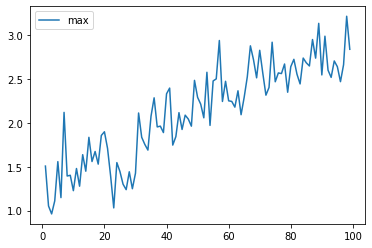

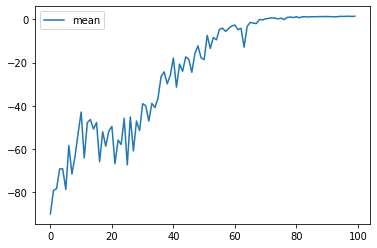

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(genetic_pop.global_info)
print(df)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
plt.plot(df['max'][1:], label='max')
plt.legend()
plt.show()


fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
plt.plot(df['mean'], label='mean')
plt.legend()
plt.show()




## Evaluate

In [35]:
# Environment Initialization
args = {
    'x': x_train, 
    'actions': possible_actions, 
    'state_size': state_size, 
    'start_index': 10000,
    'end_index': 50000,
    'initial_cash': initial_cash,
    'close_col': close_col, 
    'undo_detrend': x_train_undo_detrend, 
    'reward_function': reward_function, 
    'profit_window_size': profit_window_size, 
    'inaction_penalty': inaction_penalty,
    'large_holdings_penalty': large_holdings_penalty
}
env = MarketEnvironmentV1(**args)
env.reset()
state_dim = env.get_state_size()
action_dim = env.get_action_size()

SimpleProfit


In [36]:
def buy():
    states_sell = []
    states_buy = []
    close = []
    
    observation = env.reset()
    done = False
    t = 0 

    while not done:
        close.append(env.get_last_close())
        action = genetic_pop.best_network.act(np.array(observation))
        if action == 1: states_buy.append(t)
        if action == 2: states_sell.append(t)
            
        observation, r, done, _ = env.step(action)
        
        t += 1
        
    info = env.get_info()
    return close, states_buy, states_sell, float(info['total_profit']), float(info['cash_profit'])

In [37]:
close, states_buy, states_sell, total_gains, invest = buy()

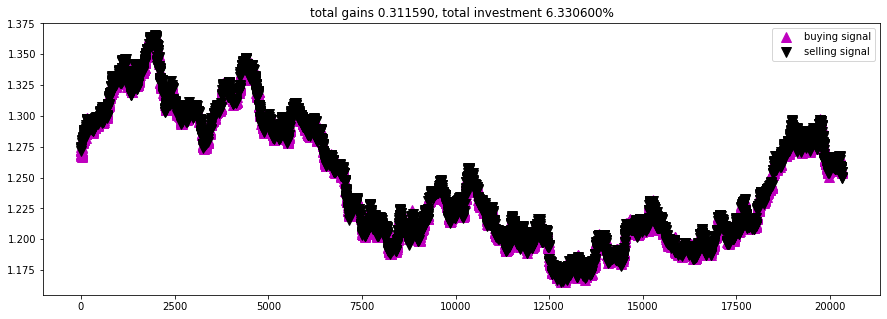

In [38]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

### Choosing best

In [39]:
from tqdm import tqdm
best = (-9999, -1, 'best')
all_runs = []

for i in tqdm(range(len(genetic_pop.global_info))):
    for mode in ['last', 'best']:
        path = 'saved_models/DeepNeuro_Gen_' + mode + '_' + str(i + 1) + '.pkl'
        genetic_pop.load_weights(path)

        close, states_buy, states_sell, total_gains, invest = buy()
        print('Finished run ', i + 1, 'result: ', invest)

        all_runs.append((invest, i + 1, mode))
        if invest >= best[0]: best = (invest, i + 1, mode)
        


  0%|          | 0/100 [00:00<?, ?it/s]

Finished run  1 result:  18.11539999999998



  1%|          | 1/100 [00:11<18:42, 11.34s/it]

Finished run  1 result:  0.0
Finished run  2 result:  18.11539999999998



  2%|▏         | 2/100 [00:18<16:41, 10.22s/it]

Finished run  2 result:  1.7769999999992292
Finished run  3 result:  7.129799999999653



  3%|▎         | 3/100 [00:26<15:17,  9.46s/it]

Finished run  3 result:  18.11539999999998
Finished run  4 result:  -5.470600000000159



  4%|▍         | 4/100 [00:35<14:56,  9.33s/it]

Finished run  4 result:  18.11539999999998
Finished run  5 result:  18.11539999999998



  5%|▌         | 5/100 [00:42<13:36,  8.60s/it]

Finished run  5 result:  1.2861999999999707
Finished run  6 result:  -13.234000000000334



  6%|▌         | 6/100 [00:54<15:14,  9.73s/it]

Finished run  6 result:  18.11539999999998
Finished run  7 result:  2.980399999999994



  7%|▋         | 7/100 [00:57<11:37,  7.50s/it]

Finished run  7 result:  1.2861999999999707
Finished run  8 result:  1.2861999999999707



  8%|▊         | 8/100 [01:04<11:13,  7.32s/it]

Finished run  8 result:  13.98660000000078
Finished run  9 result:  3.6825999999998915



  9%|▉         | 9/100 [01:15<13:05,  8.63s/it]

Finished run  9 result:  18.17199999999999
Finished run  10 result:  12.891000000000275



 10%|█         | 10/100 [01:22<12:15,  8.17s/it]

Finished run  10 result:  0.9472000000001257
Finished run  11 result:  1.2861999999999707



 11%|█         | 11/100 [01:29<11:38,  7.84s/it]

Finished run  11 result:  5.306200000000194
Finished run  12 result:  -0.12120000000022113



 12%|█▏        | 12/100 [01:37<11:23,  7.77s/it]

Finished run  12 result:  1.2861999999999707
Finished run  13 result:  4.598799999999925



 13%|█▎        | 13/100 [01:45<11:19,  7.81s/it]

Finished run  13 result:  0.11959999999882065
Finished run  14 result:  -7.06759999999994



 14%|█▍        | 14/100 [01:53<11:08,  7.77s/it]

Finished run  14 result:  1.2861999999999707
Finished run  15 result:  20.92359999999971



 15%|█▌        | 15/100 [02:00<10:41,  7.54s/it]

Finished run  15 result:  1.2861999999999707
Finished run  16 result:  1.2861999999999707



 16%|█▌        | 16/100 [02:02<08:21,  5.97s/it]

Finished run  16 result:  1.2861999999999707
Finished run  17 result:  5.467599999999839



 17%|█▋        | 17/100 [02:14<10:39,  7.70s/it]

Finished run  17 result:  10.093800000000218
Finished run  18 result:  18.160200000000003



 18%|█▊        | 18/100 [02:23<11:11,  8.18s/it]

Finished run  18 result:  2.7789999999998427
Finished run  19 result:  5.257599999999885



 19%|█▉        | 19/100 [02:30<10:44,  7.96s/it]

Finished run  19 result:  0.9703999999999713
Finished run  20 result:  11.78780000000006



 20%|██        | 20/100 [02:43<12:16,  9.21s/it]

Finished run  20 result:  18.11539999999998
Finished run  21 result:  18.11539999999998



 21%|██        | 21/100 [02:55<13:14, 10.06s/it]

Finished run  21 result:  18.11539999999998
Finished run  22 result:  1.590400000000014



 22%|██▏       | 22/100 [03:02<11:52,  9.13s/it]

Finished run  22 result:  18.11539999999998
Finished run  23 result:  -0.6681999999992194



 23%|██▎       | 23/100 [03:04<09:05,  7.09s/it]

Finished run  23 result:  1.1157999999999557
Finished run  24 result:  23.513999999999456



 24%|██▍       | 24/100 [03:16<10:44,  8.47s/it]

Finished run  24 result:  18.11539999999998
Finished run  25 result:  18.11539999999998



 25%|██▌       | 25/100 [03:28<11:53,  9.52s/it]

Finished run  25 result:  18.11539999999998
Finished run  26 result:  11.396599999999468



 26%|██▌       | 26/100 [03:35<11:06,  9.01s/it]

Finished run  26 result:  15.176399999999779
Finished run  27 result:  23.2418



 27%|██▋       | 27/100 [03:47<11:55,  9.80s/it]

Finished run  27 result:  18.11539999999998
Finished run  28 result:  2.3054000000009456



 28%|██▊       | 28/100 [03:59<12:42, 10.59s/it]

Finished run  28 result:  18.11539999999998
Finished run  29 result:  18.6914000000002



 29%|██▉       | 29/100 [04:11<12:58, 10.97s/it]

Finished run  29 result:  32.698400000000596
Finished run  30 result:  1.2861999999999707



 30%|███       | 30/100 [04:18<11:24,  9.78s/it]

Finished run  30 result:  19.577200000000495
Finished run  31 result:  27.103400000000157



 31%|███       | 31/100 [04:30<11:59, 10.43s/it]

Finished run  31 result:  16.376599999999964
Finished run  32 result:  8.26120000000028



 32%|███▏      | 32/100 [04:43<12:29, 11.02s/it]

Finished run  32 result:  13.052399999999253
Finished run  33 result:  15.495000000000969



 33%|███▎      | 33/100 [04:53<12:13, 10.95s/it]

Finished run  33 result:  2.771400000000357
Finished run  34 result:  -3.410400000001257



 34%|███▍      | 34/100 [05:06<12:34, 11.43s/it]

Finished run  34 result:  -3.4594000000007674
Finished run  35 result:  15.659799999999047



 35%|███▌      | 35/100 [05:18<12:34, 11.60s/it]

Finished run  35 result:  18.11539999999998
Finished run  36 result:  -0.986200000000359



 36%|███▌      | 36/100 [05:22<10:03,  9.44s/it]

Finished run  36 result:  -5.8913999999988365
Finished run  37 result:  5.6522000000001515



 37%|███▋      | 37/100 [05:30<09:17,  8.86s/it]

Finished run  37 result:  10.955399999999148
Finished run  38 result:  0.6909999999997751



 38%|███▊      | 38/100 [05:34<07:42,  7.46s/it]

Finished run  38 result:  2.1435999999988242
Finished run  39 result:  7.963200000000259



 39%|███▉      | 39/100 [05:43<08:06,  7.97s/it]

Finished run  39 result:  29.352599999999242
Finished run  40 result:  13.93219999999975



 40%|████      | 40/100 [05:53<08:35,  8.59s/it]

Finished run  40 result:  18.11539999999998
Finished run  41 result:  9.052599999999789



 41%|████      | 41/100 [06:01<08:05,  8.23s/it]

Finished run  41 result:  3.1662000000003188
Finished run  42 result:  7.73299999999888



 42%|████▏     | 42/100 [06:05<06:51,  7.09s/it]

Finished run  42 result:  1.2651999999999886
Finished run  43 result:  5.642400000000447



 43%|████▎     | 43/100 [06:12<06:46,  7.14s/it]

Finished run  43 result:  1.5227999999999353
Finished run  44 result:  31.870800000001374



 44%|████▍     | 44/100 [06:22<07:26,  7.98s/it]

Finished run  44 result:  5.603799999998937
Finished run  45 result:  -9.999399999998849



 45%|████▌     | 45/100 [06:35<08:28,  9.25s/it]

Finished run  45 result:  11.422599999999994
Finished run  46 result:  9.155599999999753



 46%|████▌     | 46/100 [06:44<08:22,  9.31s/it]

Finished run  46 result:  3.054799999999891
Finished run  47 result:  10.546799999998878



 47%|████▋     | 47/100 [06:48<06:54,  7.83s/it]

Finished run  47 result:  8.442600000000189
Finished run  48 result:  5.780599999998826



 48%|████▊     | 48/100 [06:58<07:11,  8.29s/it]

Finished run  48 result:  11.477599999999955
Finished run  49 result:  25.308200000000202



 49%|████▉     | 49/100 [07:07<07:11,  8.46s/it]

Finished run  49 result:  2.691999999999628
Finished run  50 result:  2.9793999999993215



 50%|█████     | 50/100 [07:09<05:30,  6.61s/it]

Finished run  50 result:  1.2861999999999707
Finished run  51 result:  -7.2299999999999365



 51%|█████     | 51/100 [07:22<06:52,  8.43s/it]

Finished run  51 result:  16.37479999999951
Finished run  52 result:  7.452199999999043



 52%|█████▏    | 52/100 [07:31<06:54,  8.64s/it]

Finished run  52 result:  18.118999999999975
Finished run  53 result:  11.926400000000426



 53%|█████▎    | 53/100 [07:38<06:24,  8.18s/it]

Finished run  53 result:  9.634799999998389
Finished run  54 result:  5.892199999999681



 54%|█████▍    | 54/100 [07:47<06:32,  8.53s/it]

Finished run  54 result:  9.27260000000083
Finished run  55 result:  19.252200000000276



 55%|█████▌    | 55/100 [07:57<06:38,  8.84s/it]

Finished run  55 result:  10.257600000000021
Finished run  56 result:  22.285200000001026



 56%|█████▌    | 56/100 [08:08<07:08,  9.73s/it]

Finished run  56 result:  15.149800000000258
Finished run  57 result:  12.435199999999291



 57%|█████▋    | 57/100 [08:17<06:46,  9.46s/it]

Finished run  57 result:  28.00980000000044
Finished run  58 result:  4.928000000000421



 58%|█████▊    | 58/100 [08:27<06:35,  9.41s/it]

Finished run  58 result:  12.541599999999997
Finished run  59 result:  25.83880000000025



 59%|█████▉    | 59/100 [08:34<06:01,  8.81s/it]

Finished run  59 result:  -1.679799999999787
Finished run  60 result:  7.729800000000742



 60%|██████    | 60/100 [08:43<05:54,  8.86s/it]

Finished run  60 result:  35.71400000000118
Finished run  61 result:  5.747000000000102



 61%|██████    | 61/100 [08:49<05:15,  8.10s/it]

Finished run  61 result:  5.747000000000102
Finished run  62 result:  9.915599999999225



 62%|██████▏   | 62/100 [08:54<04:25,  7.00s/it]

Finished run  62 result:  1.0622000000000797
Finished run  63 result:  3.4712000000003185



 63%|██████▎   | 63/100 [09:00<04:09,  6.73s/it]

Finished run  63 result:  3.4712000000003185
Finished run  64 result:  15.460999999999858



 64%|██████▍   | 64/100 [09:09<04:28,  7.47s/it]

Finished run  64 result:  13.19719999999933
Finished run  65 result:  1.0668000000001232



 65%|██████▌   | 65/100 [09:18<04:40,  8.03s/it]

Finished run  65 result:  30.35520000000109
Finished run  66 result:  27.964800000000032



 66%|██████▌   | 66/100 [09:31<05:16,  9.32s/it]

Finished run  66 result:  18.863399999999153
Finished run  67 result:  6.556600000000223



 67%|██████▋   | 67/100 [09:37<04:37,  8.40s/it]

Finished run  67 result:  17.32160000000078
Finished run  68 result:  14.440199999999837



 68%|██████▊   | 68/100 [09:46<04:38,  8.70s/it]

Finished run  68 result:  11.079000000000327
Finished run  69 result:  14.970799999999507



 69%|██████▉   | 69/100 [09:59<05:05,  9.86s/it]

Finished run  69 result:  15.682799999999553
Finished run  70 result:  -6.04899999999946



 70%|███████   | 70/100 [10:09<04:54,  9.82s/it]

Finished run  70 result:  7.2772000000001835
Finished run  71 result:  3.5231999999997488



 71%|███████   | 71/100 [10:18<04:39,  9.63s/it]

Finished run  71 result:  25.929000000001313
Finished run  72 result:  13.484999999999703



 72%|███████▏  | 72/100 [10:30<04:54, 10.53s/it]

Finished run  72 result:  7.972399999999902
Finished run  73 result:  7.132999999999745



 73%|███████▎  | 73/100 [10:37<04:09,  9.26s/it]

Finished run  73 result:  13.224799999999037
Finished run  74 result:  5.900000000000349



 74%|███████▍  | 74/100 [10:46<03:57,  9.13s/it]

Finished run  74 result:  19.288400000000273
Finished run  75 result:  11.592399999998904



 75%|███████▌  | 75/100 [10:52<03:29,  8.38s/it]

Finished run  75 result:  6.220600000000265
Finished run  76 result:  14.52939999999967



 76%|███████▌  | 76/100 [11:02<03:32,  8.85s/it]

Finished run  76 result:  6.419199999999736
Finished run  77 result:  22.3380000000019



 77%|███████▋  | 77/100 [11:12<03:26,  9.00s/it]

Finished run  77 result:  8.971200000000156
Finished run  78 result:  6.815800000000505



 78%|███████▊  | 78/100 [11:21<03:21,  9.15s/it]

Finished run  78 result:  25.352000000000775
Finished run  79 result:  27.029800000000105



 79%|███████▉  | 79/100 [11:30<03:12,  9.18s/it]

Finished run  79 result:  4.594599999998761
Finished run  80 result:  7.349400000000061



 80%|████████  | 80/100 [11:37<02:46,  8.31s/it]

Finished run  80 result:  6.881199999999454
Finished run  81 result:  5.237599999999576



 81%|████████  | 81/100 [11:43<02:25,  7.66s/it]

Finished run  81 result:  4.441199999999723
Finished run  82 result:  28.667600000001837



 82%|████████▏ | 82/100 [11:52<02:26,  8.16s/it]

Finished run  82 result:  8.369000000000003
Finished run  83 result:  5.563599999999624



 83%|████████▎ | 83/100 [11:58<02:09,  7.62s/it]

Finished run  83 result:  3.338599999999081
Finished run  84 result:  3.040400000001031



 84%|████████▍ | 84/100 [12:05<01:55,  7.24s/it]

Finished run  84 result:  8.670800000000822
Finished run  85 result:  17.258600000001568



 85%|████████▌ | 85/100 [12:17<02:11,  8.76s/it]

Finished run  85 result:  17.258600000001568
Finished run  86 result:  4.668399999999795



 86%|████████▌ | 86/100 [12:24<01:53,  8.09s/it]

Finished run  86 result:  10.925600000000667
Finished run  87 result:  3.771999999999376



 87%|████████▋ | 87/100 [12:30<01:37,  7.54s/it]

Finished run  87 result:  6.3824000000001435
Finished run  88 result:  10.199600000000286



 88%|████████▊ | 88/100 [12:36<01:25,  7.14s/it]

Finished run  88 result:  7.400999999999369
Finished run  89 result:  11.014800000001124



 89%|████████▉ | 89/100 [12:42<01:15,  6.85s/it]

Finished run  89 result:  7.891200000000653
Finished run  90 result:  7.625799999999883



 90%|█████████ | 90/100 [12:48<01:06,  6.67s/it]

Finished run  90 result:  7.625799999999883
Finished run  91 result:  9.899200000000153



 91%|█████████ | 91/100 [12:58<01:07,  7.49s/it]

Finished run  91 result:  29.91540000000068
Finished run  92 result:  9.767200000000177



 92%|█████████▏| 92/100 [13:07<01:03,  7.95s/it]

Finished run  92 result:  24.68240000000026
Finished run  93 result:  6.117800000000573



 93%|█████████▎| 93/100 [13:13<00:51,  7.41s/it]

Finished run  93 result:  8.056200000000047
Finished run  94 result:  13.573399999999358



 94%|█████████▍| 94/100 [13:22<00:47,  8.00s/it]

Finished run  94 result:  24.80240000000031
Finished run  95 result:  34.466200000001066



 95%|█████████▌| 95/100 [13:34<00:45,  9.14s/it]

Finished run  95 result:  28.36220000000096
Finished run  96 result:  6.911200000001605



 96%|█████████▌| 96/100 [13:41<00:33,  8.33s/it]

Finished run  96 result:  7.074400000000591
Finished run  97 result:  7.105999999999679



 97%|█████████▋| 97/100 [13:47<00:23,  7.70s/it]

Finished run  97 result:  8.985400000001498
Finished run  98 result:  6.956200000000412



 98%|█████████▊| 98/100 [13:53<00:14,  7.26s/it]

Finished run  98 result:  12.411399999999473
Finished run  99 result:  24.7286000000005



 99%|█████████▉| 99/100 [14:02<00:07,  7.88s/it]

Finished run  99 result:  5.145799999999712
Finished run  100 result:  6.330600000000919



100%|██████████| 100/100 [14:09<00:00,  8.49s/it]

Finished run  100 result:  6.330600000000919


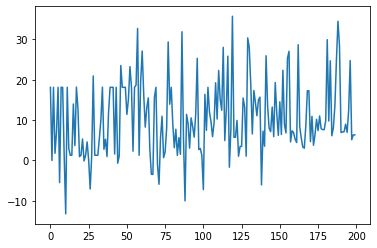

Best  (35.71400000000118, 60, 'best')
Mean profit 10.406489000000052


In [40]:
plt.plot([a[0] for a in all_runs])
plt.show()
print('Best ', best)
print('Mean profit', np.array([a[0] for a in all_runs]).mean())

### Weights

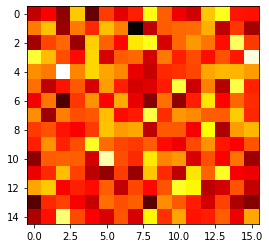

In [41]:
plt.imshow(genetic_pop.best_network.params['weights'][0], cmap='hot', interpolation='nearest')
plt.show()